# **SUMMARY**

In [1103]:
import pymupdf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.signal import savgol_filter  # For smoothing
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

plt.style.use('default')  # Set base style to default
plt.rcParams.update({
    'axes.spines.top': False,      # Remove top boundary
    'axes.spines.right': False,    # Remove right boundary
    'axes.spines.left': True,     # Remove left boundary
    'axes.spines.bottom': True,   # Remove bottom boundary
    'axes.grid': False,            # Disable gridlines
})

# **Experimental XANES for MnOx**

In [1104]:
# Load the Excel files (make sure the paths are correct)
MnO_exp = pd.read_excel(r'C:\Users\Lungelo\OneDrive - University of Cape Town\Desktop\CHE4045\code\MnO.xlsx')  
Mn2O3_exp = pd.read_excel(r'C:\Users\Lungelo\OneDrive - University of Cape Town\Desktop\CHE4045\code\Mn2O3.xlsx')  
MnO2_exp = pd.read_excel(r'C:\Users\Lungelo\OneDrive - University of Cape Town\Desktop\CHE4045\code\MnO2.xlsx')  

# (Optional) Strip spaces from column names if necessary
MnO_exp.columns = MnO_exp.columns.str.strip()
Mn2O3_exp.columns = Mn2O3_exp.columns.str.strip()
MnO2_exp.columns = MnO2_exp.columns.str.strip()

# Create DataFrames for each structure with 'x' (Energy) and 'y' (Absorption) columns
MnO_exp = pd.DataFrame({'x': MnO_exp['Energy (eV)'], 'y': MnO_exp['Absorption']})
Mn2O3_exp = pd.DataFrame({'x': Mn2O3_exp['Energy (eV)'], 'y': Mn2O3_exp['Absorption']})
MnO2_exp = pd.DataFrame({'x': MnO2_exp['Energy (eV)'], 'y': MnO2_exp['Absorption']})

# Apply filtering for each DataFrame individually
MnO_exp = MnO_exp[(MnO_exp["x"] >= 6520) & (MnO_exp["x"] <= 6590)]
Mn2O3_exp = Mn2O3_exp[(Mn2O3_exp["x"] >= 6520) & (Mn2O3_exp["x"] <= 6590)]
MnO2_exp = MnO2_exp[(MnO2_exp["x"] >= 6520) & (MnO2_exp["x"] <= 6590)]


<Figure size 500x500 with 0 Axes>

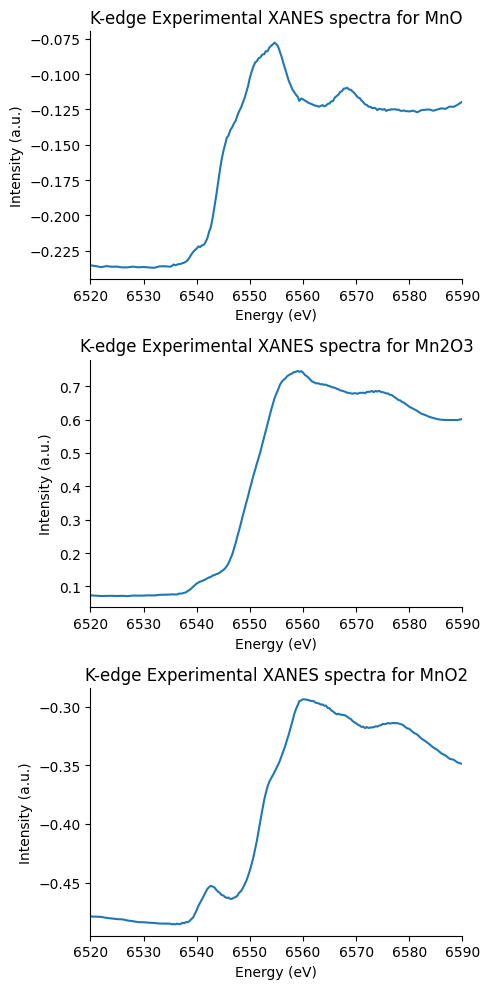

In [1105]:
plt.figure(figsize=(5, 5))  # Set the figure size if needed
# Create subplots with 3 rows, 1 column (one for each dataset)
fig, axes = plt.subplots(3, 1, figsize=(5, 10))  # Adjust the figure size as needed

# MnO
axes[0].plot(MnO_exp["x"], MnO_exp["y"])
axes[0].set_xlim(6520, 6590)
axes[0].set_xlabel('Energy (eV)')
axes[0].set_ylabel('Intensity (a.u.)')
axes[0].set_title('K-edge Experimental XANES spectra for MnO')

# Mn2O3
axes[1].plot(Mn2O3_exp["x"], Mn2O3_exp["y"])
axes[1].set_xlim(6520, 6590)
axes[1].set_xlabel('Energy (eV)')
axes[1].set_ylabel('Intensity (a.u.)')
axes[1].set_title('K-edge Experimental XANES spectra for Mn2O3')

# MnO2
axes[2].plot(MnO2_exp["x"], MnO2_exp["y"])
axes[2].set_xlim(6520, 6590)
axes[2].set_xlabel('Energy (eV)')
axes[2].set_ylabel('Intensity (a.u.)')
axes[2].set_title('K-edge Experimental XANES spectra for MnO2')

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()

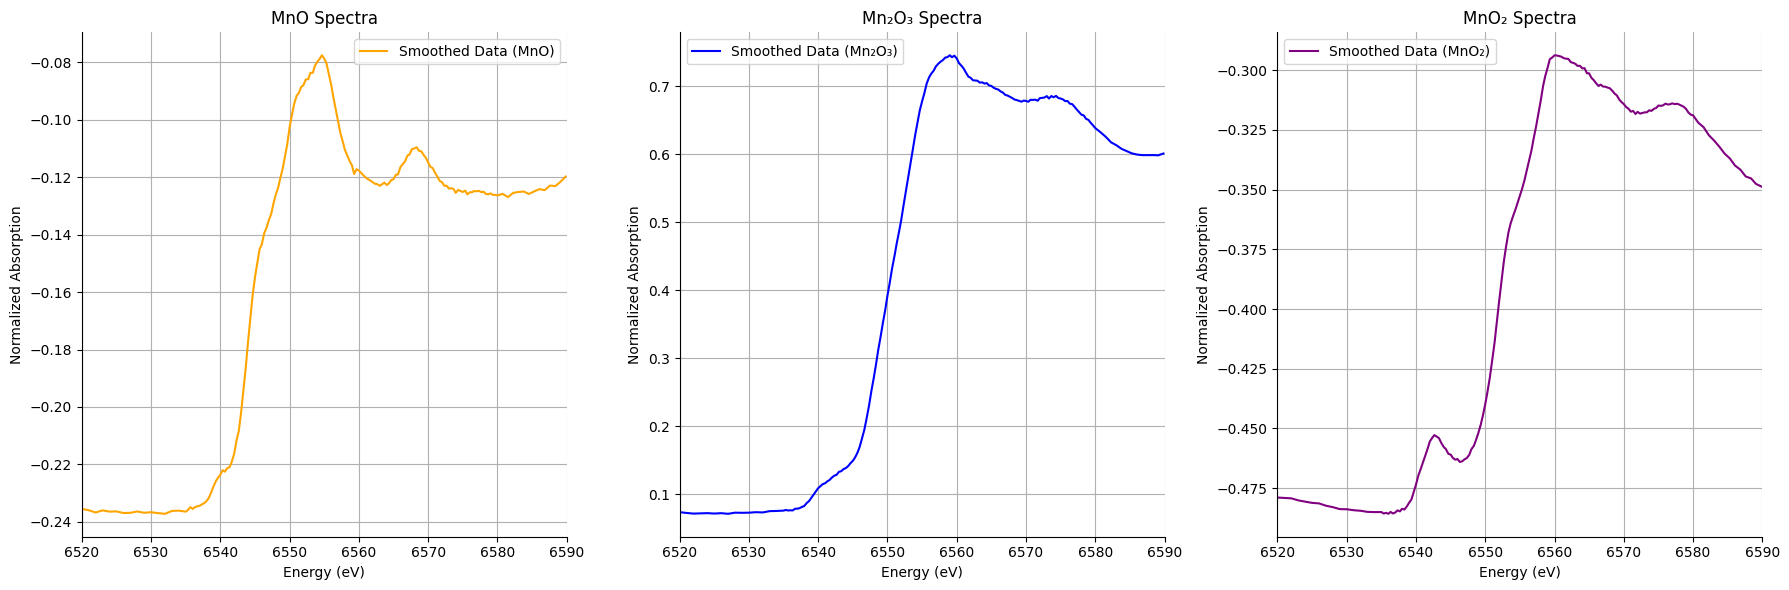

In [1106]:
# Function to process each structure (smoothing, overwriting, and plotting)
def process_structure(ax, data, label, color):
    # Access the 'x' and 'y' columns
    x = data["x"].values
    y = data["y"].values

    # Smooth the data to reduce noise
    y_smooth = gaussian_filter1d(y, sigma=0.0001)

    # Overwrite the original data with the smoothed data
    data["y"] = y_smooth

    # Plot on the provided axis
    ax.plot(x, y_smooth, label=f'Smoothed Data ({label})', color=color)
    ax.set_title(f'{label} Spectra')
    ax.set_xlabel('Energy (eV)')
    ax.set_ylabel('Normalized Absorption')
    ax.legend()
    ax.grid(True)
    ax.set_xlim([6520, 6590])  # Focus on the relevant energy range

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figure size

# Process MnO_exp on the first axis and overwrite the data
process_structure(axs[0], MnO_exp, label="MnO", color='orange')

# Process Mn2O3_exp on the second axis and overwrite the data
process_structure(axs[1], Mn2O3_exp, label="Mn₂O₃", color='blue')

# Process MnO2_exp on the third axis and overwrite the data
process_structure(axs[2], MnO2_exp, label="MnO₂", color='purple')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


MnO E₀: 6544.014 eV


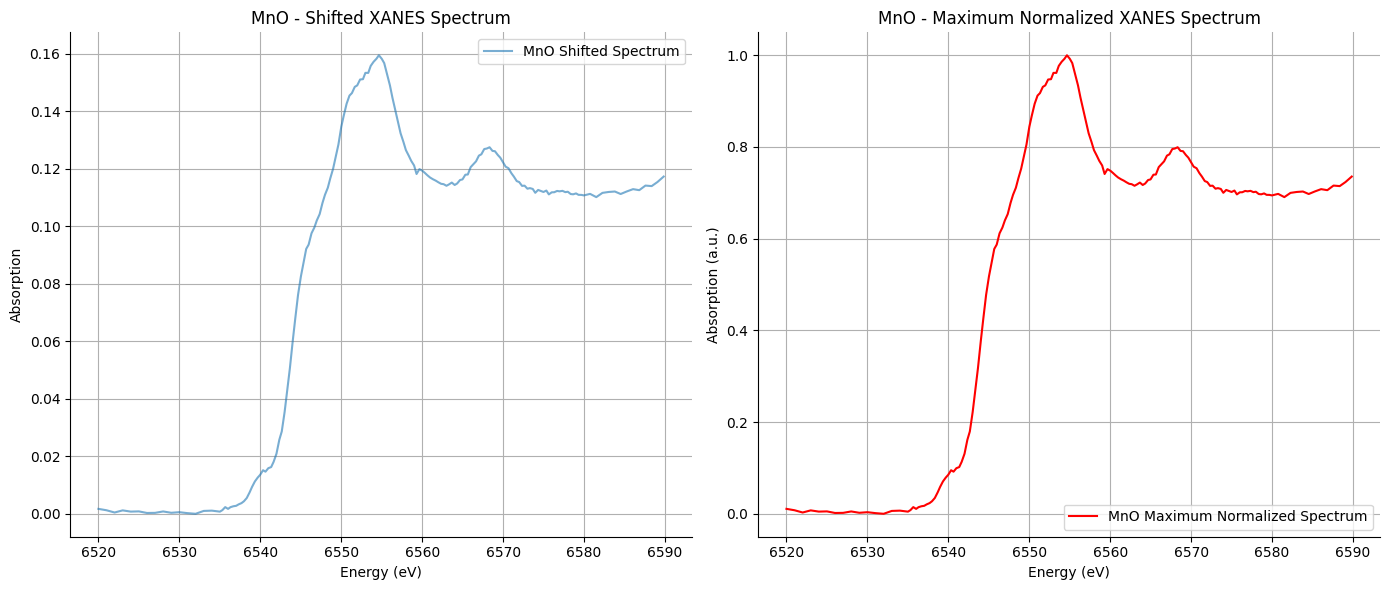

Mn2O3 E₀: 6548.347 eV


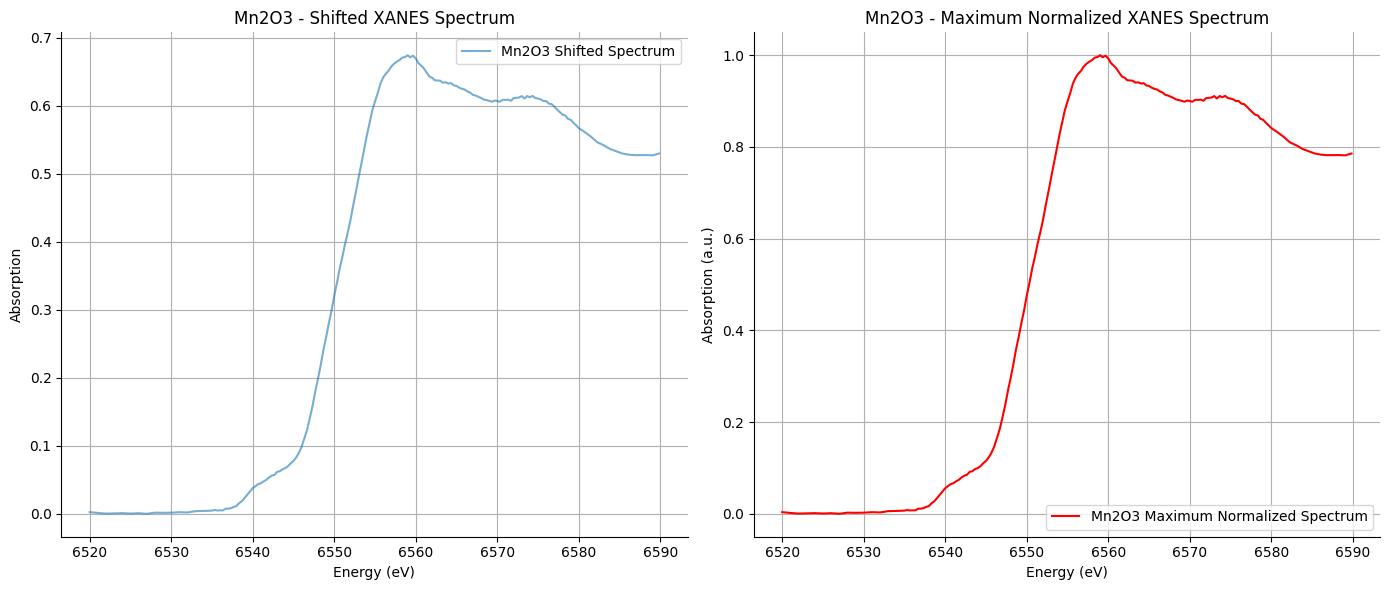

MnO2 E₀: 6551.676 eV


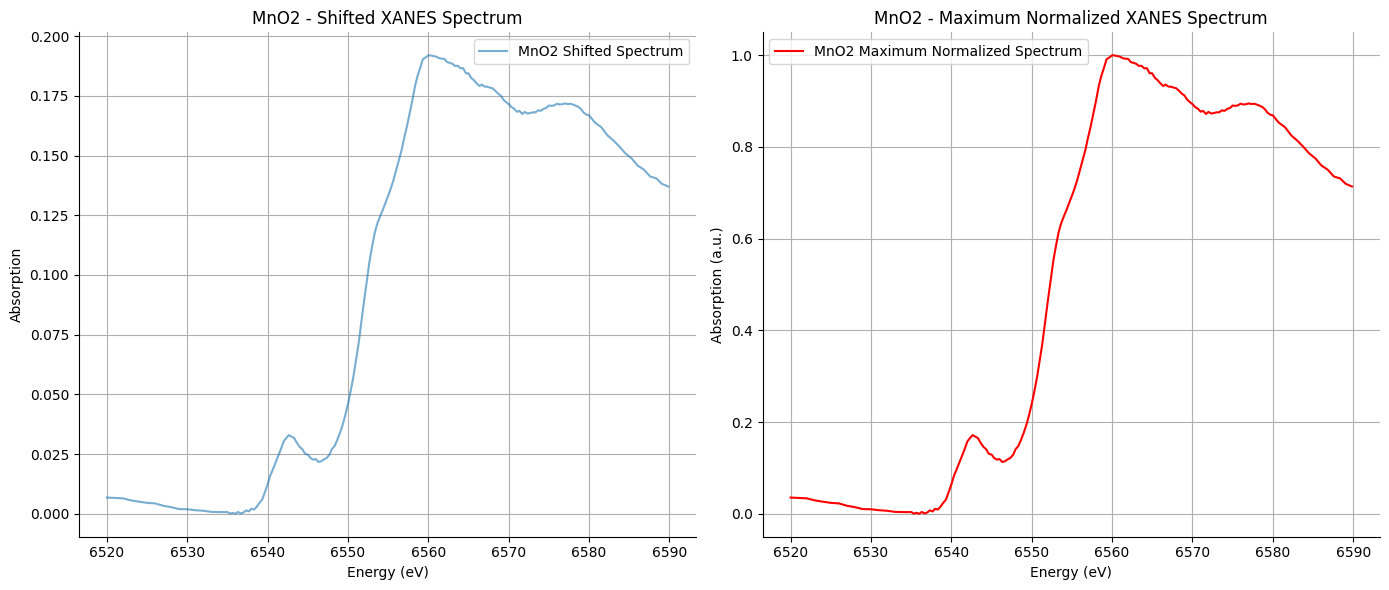

In [1107]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0

# Function to shift the graph up or down to ensure the minimum value is 0
def shift_to_zero(y):
    min_y = np.min(y)
    if min_y < 0:
        # Shift the graph upwards so the minimum value becomes 0
        y_shifted = y + abs(min_y)
    else:
        # If already above zero, shift down to make the minimum value 0
        y_shifted = y - min_y
    return y_shifted

# Function to normalize the absorption data using maximum normalization
def normalize_max(y):
    # Normalize by dividing by the maximum value
    y_max = np.max(y)
    normalized_y = y / y_max
    return normalized_y

# Global variables for E0 values
E0_MnO_exp = None
E0_Mn2O3_exp = None
E0_MnO2_exp = None

# Function to normalize and plot for each structure on separate axes
def normalize_and_plot_structure_max(x, y, structure_name):
    global E0_MnO_exp, E0_Mn2O3_exp, E0_MnO2_exp  # Use global variables

    # Calculate E₀ from the first derivative
    E0 = calculate_E0(x, y)
    
    # Store E0 values in the appropriate global variable
    if structure_name == "MnO":
        E0_MnO_exp = E0
    elif structure_name == "Mn2O3":
        E0_Mn2O3_exp = E0
    elif structure_name == "MnO2":
        E0_MnO2_exp = E0

    print(f"{structure_name} E₀: {E0} eV")
    
    # Shift data to ensure the minimum value is 0
    shifted_y = shift_to_zero(y)
    
    # Perform maximum normalization after shifting the data
    normalized_y = normalize_max(shifted_y)
    
    # Overwrite the old data with the normalized data
    if structure_name == "MnO":
        MnO_exp['y'] = normalized_y
    elif structure_name == "Mn2O3":
        Mn2O3_exp['y'] = normalized_y
    elif structure_name == "MnO2":
        MnO2_exp['y'] = normalized_y

    # Create two subplots: one for original and one for normalized
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the shifted spectrum on the first axis
    ax1.plot(x, shifted_y, label=f'{structure_name} Shifted Spectrum', alpha=0.6)
    ax1.set_xlabel('Energy (eV)')
    ax1.set_ylabel('Absorption')
    ax1.set_title(f'{structure_name} - Shifted XANES Spectrum')
    ax1.grid(True)
    ax1.legend()

    # Plot the normalized spectrum on the second axis
    ax2.plot(x, normalized_y, label=f'{structure_name} Maximum Normalized Spectrum', color='red')
    ax2.set_xlabel('Energy (eV)')
    ax2.set_ylabel('Absorption (a.u.)')
    ax2.set_title(f'{structure_name} - Maximum Normalized XANES Spectrum')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()  # Ensure proper spacing between plots

    plt.show()

# Select the columns of interest for each structure
# Example DataFrames: MnO_exp, Mn2O3_exp, MnO2_exp

# MnO
x_MnO = MnO_exp['x']
y_MnO = MnO_exp['y']
normalize_and_plot_structure_max(x_MnO, y_MnO, "MnO")

# Mn2O3
x_Mn2O3 = Mn2O3_exp['x']
y_Mn2O3 = Mn2O3_exp['y']
normalize_and_plot_structure_max(x_Mn2O3, y_Mn2O3, "Mn2O3")

# MnO2
x_MnO2 = MnO2_exp['x']
y_MnO2 = MnO2_exp['y']
normalize_and_plot_structure_max(x_MnO2, y_MnO2, "MnO2")


# **Extracting E₀**

Minimum in pre-edge region for MnO:
  Minimum: x = 6544.67, y = 0.4775


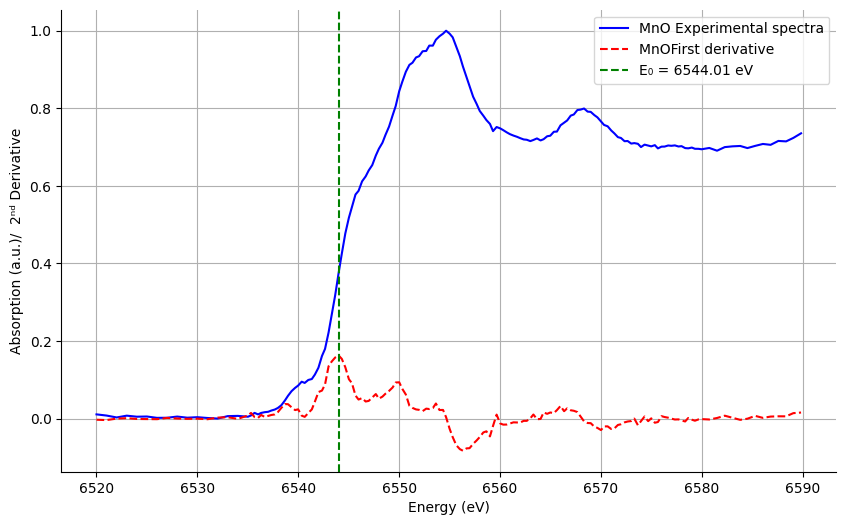

Minimum in pre-edge region for Mn₂O₃:
  Minimum: x = 6556.02, y = 0.9522


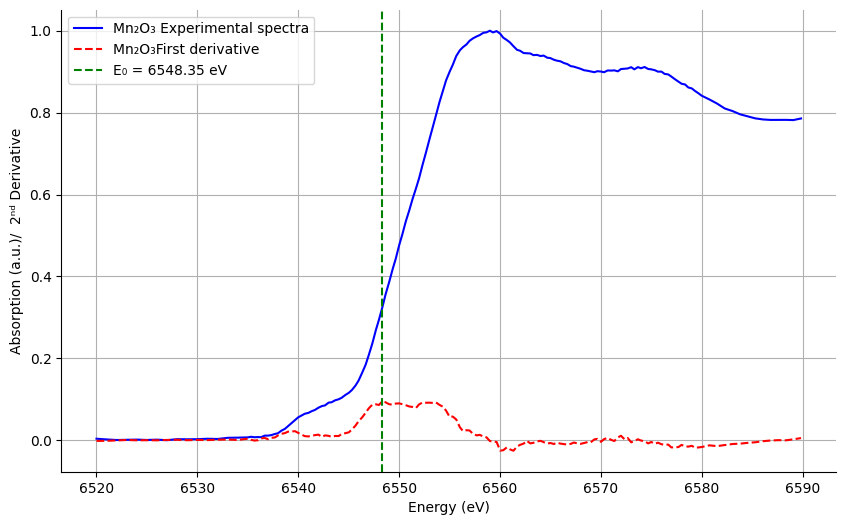

Minimum in pre-edge region for MnO₂:
  Minimum: x = 6553.34, y = 0.6135


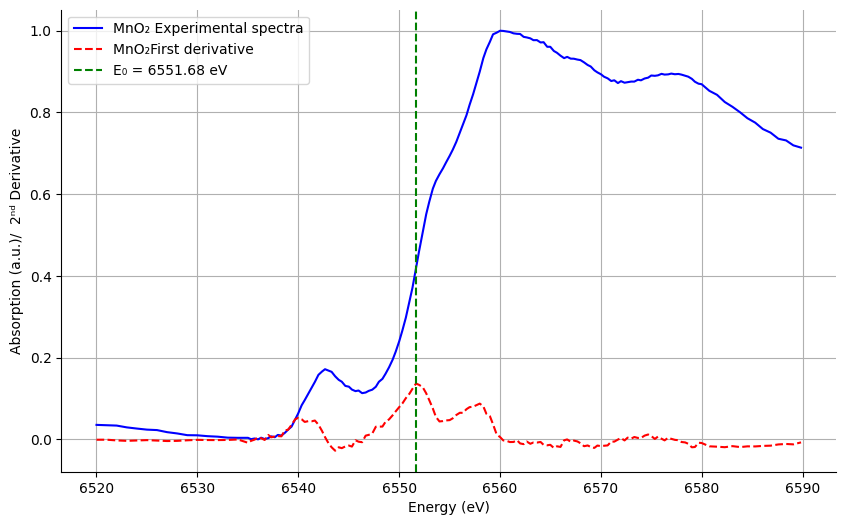

In [1108]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Find the white line position (where y is maximum)
    white_line = x[np.argmax(y)]*.9998
    
    # Restrict to pre-edge region (between E₀ and white_line)
    pre_edge_mask = (x > E0) & (x < white_line)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    pre_edge_y = y[pre_edge_mask]

    # Find the true minimum point in the pre-edge region of the second derivative
    if len(pre_edge_x) > 0:
        min_index = np.argmin(pre_edge_d2y_dx2)
        x_min = pre_edge_x[min_index]
        y_min = pre_edge_y[min_index]

        # Display the minimum x and y values
        print(f"Minimum in pre-edge region for {structure_name}:")
        print(f"  Minimum: x = {x_min:.2f}, y = {y_min:.4f}")
    else:
        print(f"No valid pre-edge region found for {structure_name} between E₀ and the white line.")

    # Plot the original data, the second derivative, and the minimum point
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} Experimental spectra', color='blue')
    plt.plot(x, dy_dx, label=f'{structure_name}First derivative', linestyle= '--',color='red')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.)/  2ⁿᵈ Derivative')
    plt.axvline(E0, color='green', linestyle='--', label=f'E₀ = {E0:.2f} eV')
    plt.legend()
    plt.grid(True)
    plt.show()

# MnO
x_MnO = MnO_exp['x'].values
y_MnO = MnO_exp['y'].values
E0_MnO, _ = calculate_E0(x_MnO, y_MnO)
find_pre_edge_minima(x_MnO, y_MnO, E0_MnO, "MnO")

# Mn2O3
x_Mn2O3 = Mn2O3_exp['x'].values
y_Mn2O3 = Mn2O3_exp['y'].values
E0_Mn2O3, _ = calculate_E0(x_Mn2O3, y_Mn2O3)
find_pre_edge_minima(x_Mn2O3, y_Mn2O3, E0_Mn2O3, "Mn₂O₃")

# MnO2
x_MnO2 = MnO2_exp['x'].values
y_MnO2 = MnO2_exp['y'].values
E0_MnO2, _ = calculate_E0(x_MnO2, y_MnO2)
find_pre_edge_minima(x_MnO2, y_MnO2, E0_MnO2, "MnO₂")

# **EXTRACTING PRE-EDGE**

MnO error level: 0.0418
Minimum in pre-edge region for MnO:
  Minimum: x = 6540.34, y = 0.0950


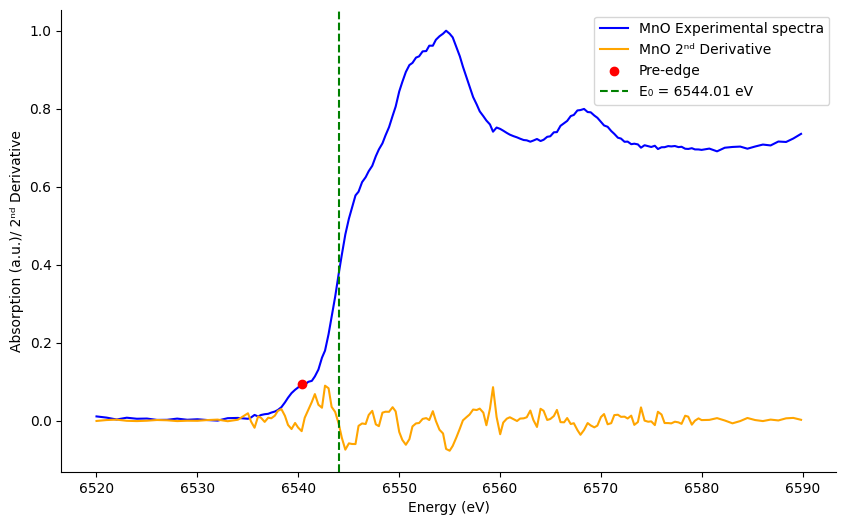

Mn₂O₃ error level: 0.0334
Minimum in pre-edge region for Mn₂O₃:
  Minimum: x = 6539.99, y = 0.0557


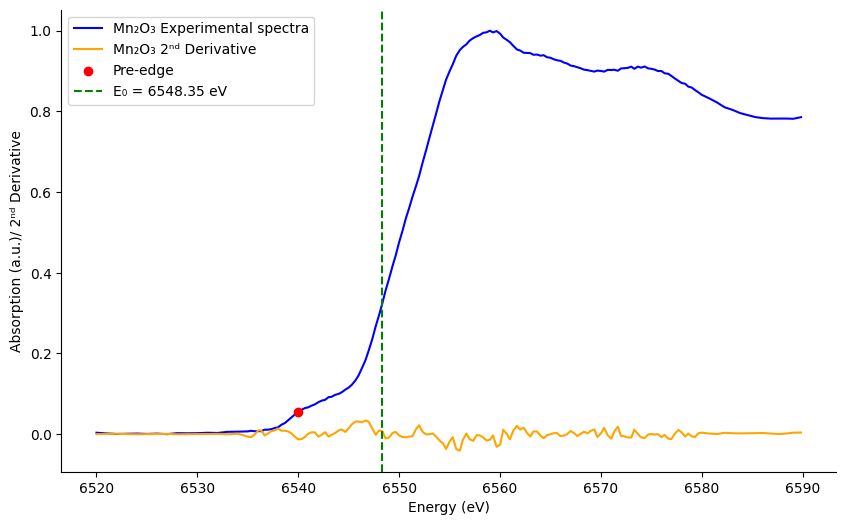

MnO₂ error level: 0.0365
Minimum in pre-edge region for MnO₂:
  Minimum: x = 6542.65, y = 0.1717


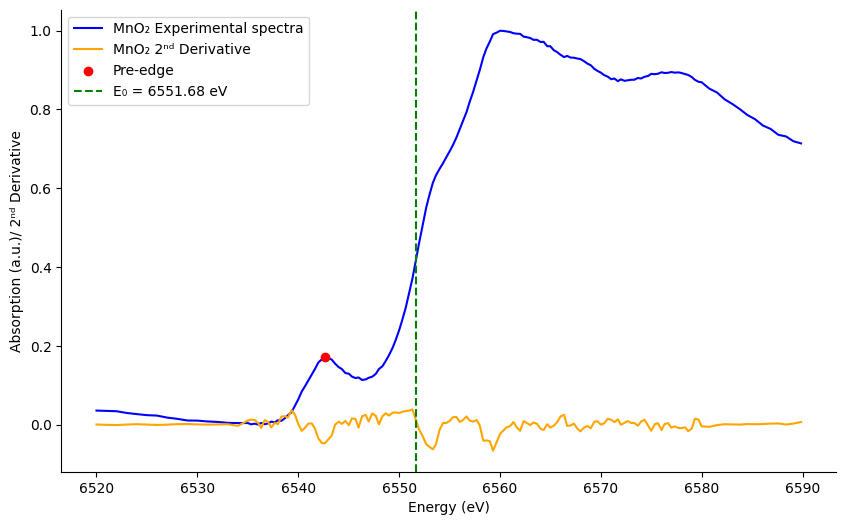

In [1109]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    
    
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)

    # Restrict to pre-edge region (before E₀)
    pre_edge_mask = (x < E0)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    
    # Find the true minimum points in the pre-edge region of the second derivative
    min_index = np.argmin(pre_edge_d2y_dx2)  # Index of the absolute minimum
    x_min = pre_edge_x[min_index]
    y_min = y[pre_edge_mask][min_index]
    
    # Display the minimum x and y values
    print(f"Minimum in pre-edge region for {structure_name}:")
    print(f"  Minimum: x = {x_min:.2f}, y = {y_min:.4f}")

    # Plot the original data, the second derivative, and the minimum point
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} Experimental spectra', color='blue')
    
    # Plot the second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    
    # Mark the minimum point
    plt.scatter(x_min, y_min, color='red', label='Pre-edge', zorder=5)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.)/ 2ⁿᵈ Derivative')
    plt.axvline(E0, color='green', linestyle='--', label=f'E₀ = {E0:.2f} eV')
    plt.legend()
    plt.show()

# Example usage
# Select the columns of interest for each structure

# MnO
x_MnO = MnO_exp['x']
y_MnO = MnO_exp['y']
E0_MnO, _ = calculate_E0(x_MnO, y_MnO)
find_pre_edge_minima(x_MnO, y_MnO, E0_MnO, "MnO")

# Mn2O3
x_Mn2O3 = Mn2O3_exp['x']
y_Mn2O3 = Mn2O3_exp['y']
E0_Mn2O3, _ = calculate_E0(x_Mn2O3, y_Mn2O3)
find_pre_edge_minima(x_Mn2O3, y_Mn2O3, E0_Mn2O3, "Mn₂O₃")

# MnO2
x_MnO2 = MnO2_exp['x']
y_MnO2 = MnO2_exp['y']
E0_MnO2, _ = calculate_E0(x_MnO2, y_MnO2)
find_pre_edge_minima(x_MnO2, y_MnO2, E0_MnO2, "MnO₂")

# **Extracting shoulders**

MnO error level: 0.0398
Minimum in pre-edge region for MnO:
  Minimum: x = 6545.32, 2nd Derivative y = -0.0502


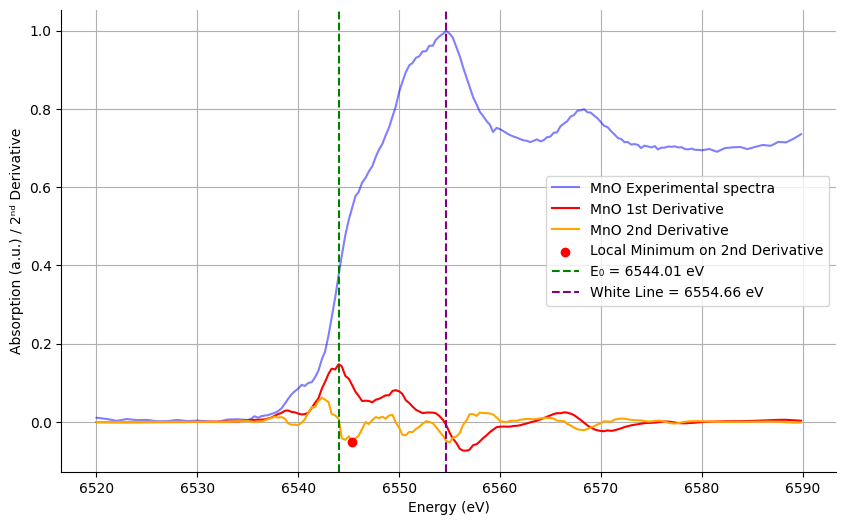

Mn₂O₃ error level: 0.0331
Minimum in pre-edge region for Mn₂O₃:
  Minimum: x = 6555.31, 2nd Derivative y = -0.0292


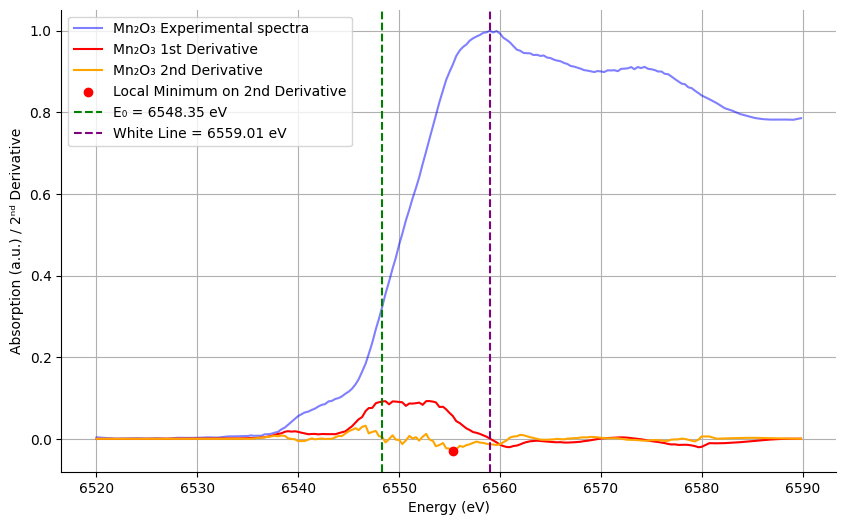

MnO₂ error level: 0.0355
Minimum in pre-edge region for MnO₂:
  Minimum: x = 6552.99, 2nd Derivative y = -0.0431


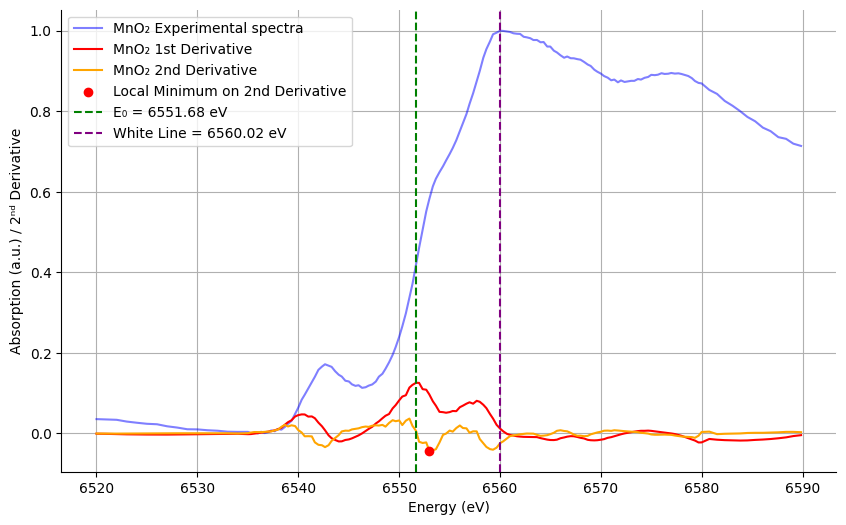

In [1110]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name, sigma=2):
    # Smooth the y data with Gaussian filter
    y_smooth = gaussian_filter1d(y, sigma=sigma)
    
    # Compute the first derivative (dy/dx) after smoothing
    dy_dx = np.gradient(y_smooth, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
        
    # Compute the second derivative (d²y/dx²) after smoothing
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Find the white line position (where y is maximum)
    white_line = x[np.argmax(y)]
    
    # Restrict to pre-edge region (between E₀ and white_line)
    pre_edge_mask = (x > E0) & (x < white_line)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]

    # Find the true minimum point in the pre-edge region of the second derivative
    if len(pre_edge_x) > 0:
        min_index = np.argmin(pre_edge_d2y_dx2)
        x_min = pre_edge_x[min_index]
        y_min_d2 = pre_edge_d2y_dx2[min_index]  # Minimum value in second derivative

        # Display the minimum x and y values
        print(f"Minimum in pre-edge region for {structure_name}:")
        print(f"  Minimum: x = {x_min:.2f}, 2nd Derivative y = {y_min_d2:.4f}")
    else:
        print(f"No valid pre-edge region found for {structure_name} between E₀ and the white line.")

    # Plot the original data, smoothed data, the second derivative, and the minimum point on the second derivative
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum and smoothed spectrum
    plt.plot(x, y, label=f'{structure_name} Experimental spectra', color='blue', alpha=0.5)
    
    # Plot the first derivative
    plt.plot(x, dy_dx, label=f'{structure_name} 1st Derivative', color='red')
    
    # Plot the second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2nd Derivative', color='orange')
    
    # Mark the minimum point on the second derivative if found
    if len(pre_edge_x) > 0:
        plt.scatter(x_min, y_min_d2, color='red', label='Local Minimum on 2nd Derivative', zorder=5)
    
    # Mark E₀ and white line
    plt.axvline(E0, color='green', linestyle='--', label=f'E₀ = {E0:.2f} eV')
    plt.axvline(white_line, color='purple', linestyle='--', label=f'White Line = {white_line:.2f} eV')
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.) / 2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage for different manganese oxides
# MnO
x_MnO = MnO_exp['x'].values
y_MnO = MnO_exp['y'].values
E0_MnO, _ = calculate_E0(x_MnO, y_MnO)
find_pre_edge_minima(x_MnO, y_MnO, E0_MnO, "MnO")

# Mn2O3
x_Mn2O3 = Mn2O3_exp['x'].values
y_Mn2O3 = Mn2O3_exp['y'].values
E0_Mn2O3, _ = calculate_E0(x_Mn2O3, y_Mn2O3)
find_pre_edge_minima(x_Mn2O3, y_Mn2O3, E0_Mn2O3, "Mn₂O₃")

# MnO2
x_MnO2 = MnO2_exp['x'].values
y_MnO2 = MnO2_exp['y'].values
E0_MnO2, _ = calculate_E0(x_MnO2, y_MnO2)
find_pre_edge_minima(x_MnO2, y_MnO2, E0_MnO2, "MnO₂")


# **EXTRACT WHITE-LINE**

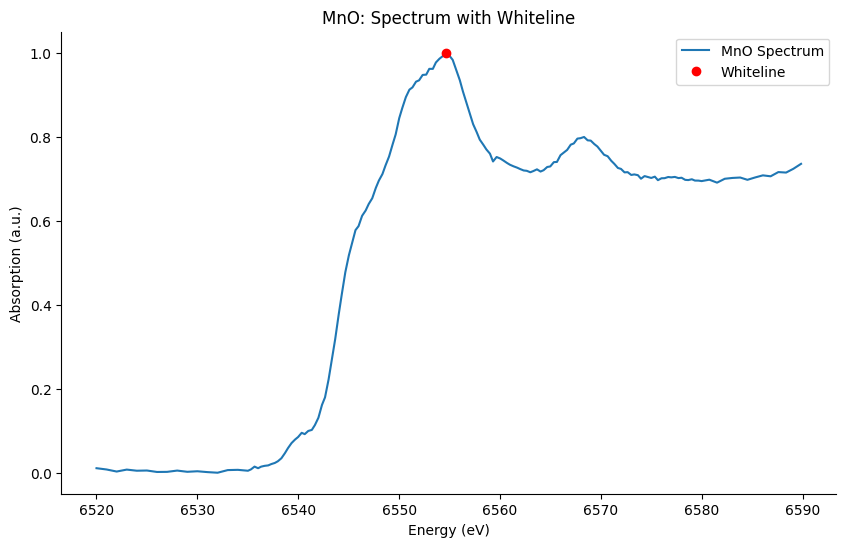

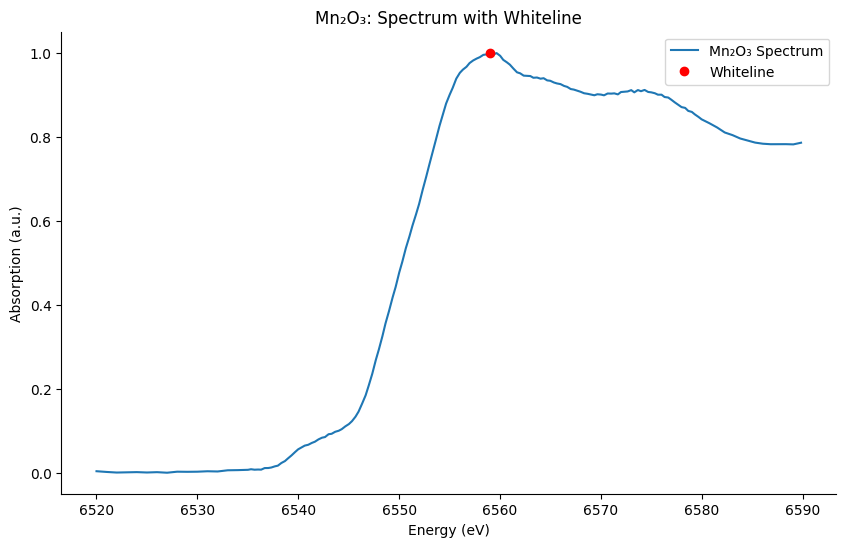

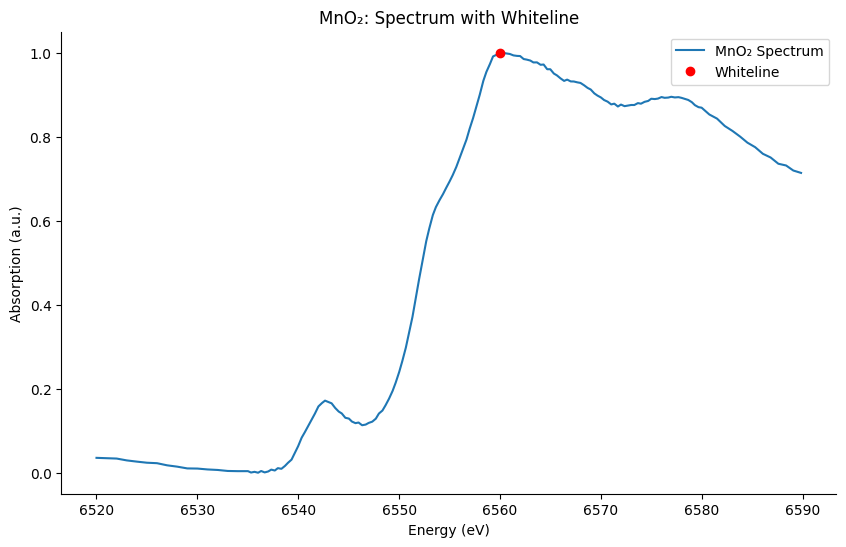

In [1111]:
# Function to plot spectra and mark the absolute maximum (whiteline)
def plot_spectrum_with_whiteline(data, structure_name):
    # Extract the x and y values from the DataFrame
    x = data['x']
    y = data['y']

    # Find the index of the absolute maximum in the y column
    abs_max_index = y.idxmax()
    # Get the corresponding x and y values for the whiteline
    x_abs_max = x[abs_max_index]
    y_abs_max = y[abs_max_index]

    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} Spectrum')
    plt.plot(x_abs_max, y_abs_max, 'ro', label='Whiteline')  # Mark the whiteline

    # Label the plot
    plt.title(f'{structure_name}: Spectrum with Whiteline')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.)')
    plt.legend()
    plt.show()

# Plot each spectrum with whiteline marked
plot_spectrum_with_whiteline(MnO_exp, "MnO")
plot_spectrum_with_whiteline(Mn2O3_exp, "Mn₂O₃")
plot_spectrum_with_whiteline(MnO2_exp, "MnO₂")

# **EXTRACT FIRST MAXIMUM POST-EDGE**

MnO error level: 0.0414
Maxima for MnO (x > white line at 6554.66):
  Maximum 1: x = 6568.333, y = 0.7959400617913133
  Maximum 2: x = 6576.978, y = 0.7034914741033779
  Maximum 3: x = 6583.812, y = 0.7011146274752269
Maximum value of the first derivative for MnO: 0.16140422825103928


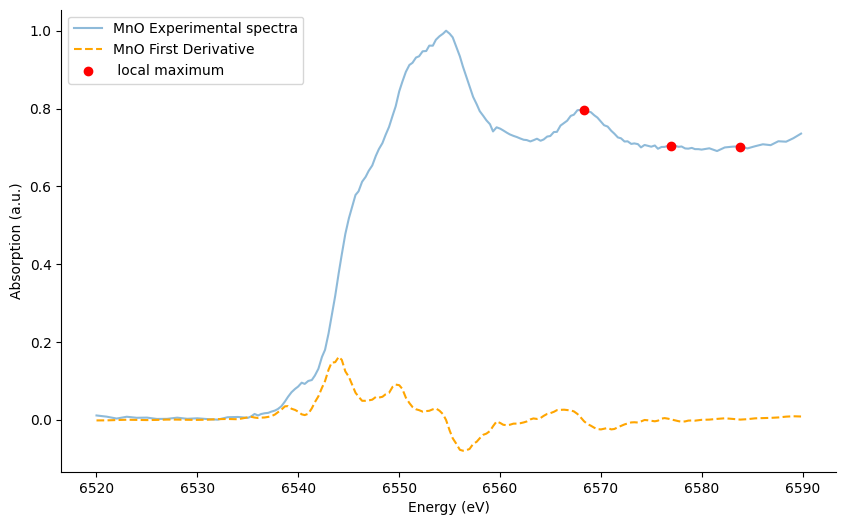

Mn₂O₃ error level: 0.0335
Maxima for Mn₂O₃ (x > white line at 6559.01):
  Maximum 1: x = 6569.654, y = 0.900182260416079
  Maximum 2: x = 6573.008, y = 0.9086646661698279
  Maximum 3: x = 6573.975, y = 0.909525914705067
Maximum value of the first derivative for Mn₂O₃: 0.09396564423580922


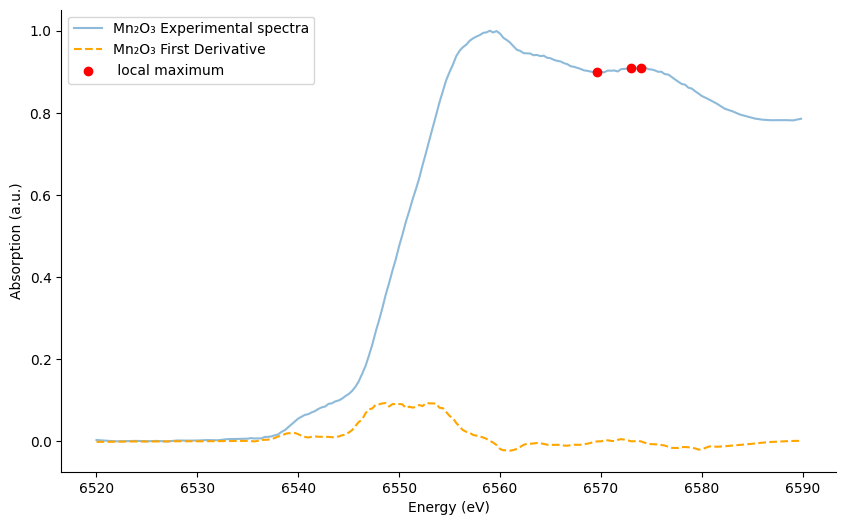

MnO₂ error level: 0.0366
Maxima for MnO₂ (x > white line at 6560.32):
  Maximum 1: x = 6576.978, y = 0.8940567704142146
Maximum value of the first derivative for MnO₂: 0.13484790570549443


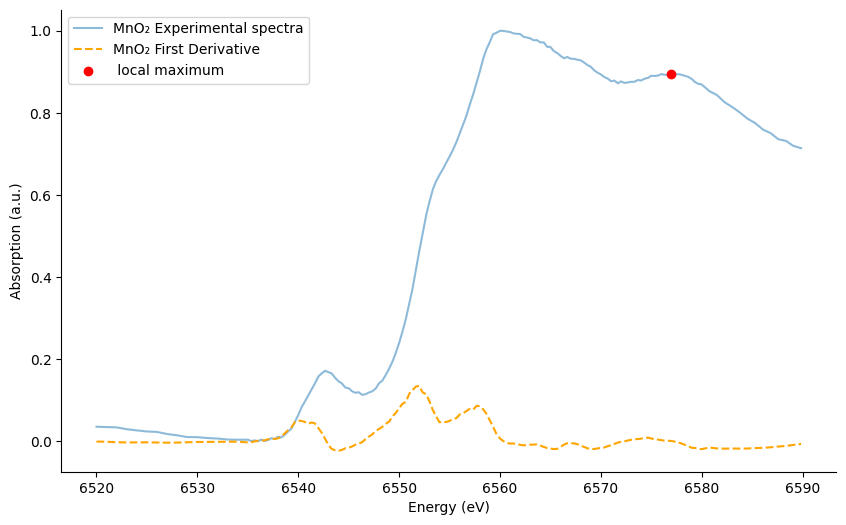

In [1112]:
# Function to find maxima based on the first derivative and plot both original data and first derivative
def find_maxima(x, y, structure_name, sigma=1):
    # Smooth the y data using a Gaussian filter
    y_smooth = gaussian_filter1d(y, sigma=sigma)
    
    # Compute the first derivative of the smoothed data (dy/dx)
    dy_dx = np.gradient(y_smooth, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    
    
    # Find the maximum intensity ("white line") and its x-coordinate on the smoothed data
    white_line_y = np.max(y_smooth)
    white_line_x = x[np.argmax(y_smooth)]
    
    # Find peaks in the smoothed y data
    peaks, _ = find_peaks(y_smooth, height=0)  # Find all peaks
    
    # Extract the x and y coordinates of the detected peaks
    x_peaks = x[peaks]
    y_peaks = y_smooth[peaks]

    # Filter peaks to only include those where x > white_line_x
    mask = x_peaks > white_line_x
    x_max_filtered = x_peaks[mask]
    y_max_filtered = y_peaks[mask]

    # Record the maximum value of the first derivative
    max_first_derivative = np.max(dy_dx)
    
    # Print the maxima and the maximum value of the first derivative
    print(f"Maxima for {structure_name} (x > white line at {white_line_x:.2f}):")
    for i, (x_val, y_val) in enumerate(zip(x_max_filtered, y_max_filtered)):
        print(f"  Maximum {i+1}: x = {x_val}, y = {y_val}")
    print(f"Maximum value of the first derivative for {structure_name}: {max_first_derivative}")

    # Plot the original data, the smoothed data, the first derivative, and the maximum points above the white line
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} Experimental spectra', alpha=0.5)
    plt.plot(x, dy_dx, label=f'{structure_name} First Derivative', linestyle='--', color='orange')  # Plot first derivative
    plt.scatter(x_max_filtered, y_max_filtered, color='red', label=' local maximum', zorder=5)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.)')
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.show()

# Example data for MnO, Mn2O3, and MnO2
# MnO
x_MnO = MnO_exp['x']
y_MnO = MnO_exp['y']
find_maxima(x_MnO, y_MnO, "MnO")

# Mn2O3
x_Mn2O3 = Mn2O3_exp['x']
y_Mn2O3 = Mn2O3_exp['y']
find_maxima(x_Mn2O3, y_Mn2O3, "Mn₂O₃")

# MnO2
x_MnO2 = MnO2_exp['x']
y_MnO2 = MnO2_exp['y']
find_maxima(x_MnO2, y_MnO2, "MnO₂")

# **FIRST POST-EDGE MAXIMUM**

MnO error level: 0.0414
Local minima in second derivative (x > white line) for MnO:
  x = 6557.69, y = 0.0234
  x = 6558.65, y = 0.0139
  x = 6560.02, y = -0.0132
  x = 6561.69, y = 0.0018
  x = 6563.66, y = 0.0015
  x = 6564.98, y = 0.0078
  x = 6567.98, y = -0.0284
  x = 6571.02, y = -0.0030
  x = 6573.31, y = -0.0001
  x = 6574.99, y = -0.0038
  x = 6576.98, y = -0.0063
  x = 6579.02, y = -0.0005
  x = 6580.75, y = 0.0016
  x = 6583.05, y = -0.0022
  x = 6586.06, y = 0.0008


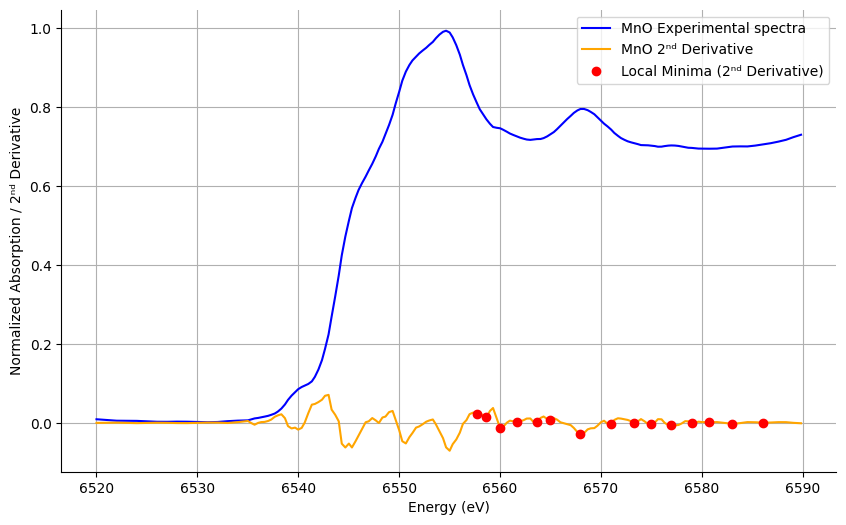

Mn2O3 error level: 0.0335
Local minima in second derivative (x > white line) for Mn2O3:
  x = 6559.66, y = -0.0225
  x = 6563.01, y = 0.0010
  x = 6564.32, y = -0.0054
  x = 6566.35, y = -0.0031
  x = 6567.67, y = -0.0002
  x = 6569.65, y = 0.0018
  x = 6571.02, y = -0.0028
  x = 6572.65, y = -0.0061
  x = 6574.33, y = -0.0085
  x = 6576.67, y = -0.0086
  x = 6579.32, y = -0.0067
  x = 6581.52, y = 0.0002
  x = 6583.81, y = 0.0021


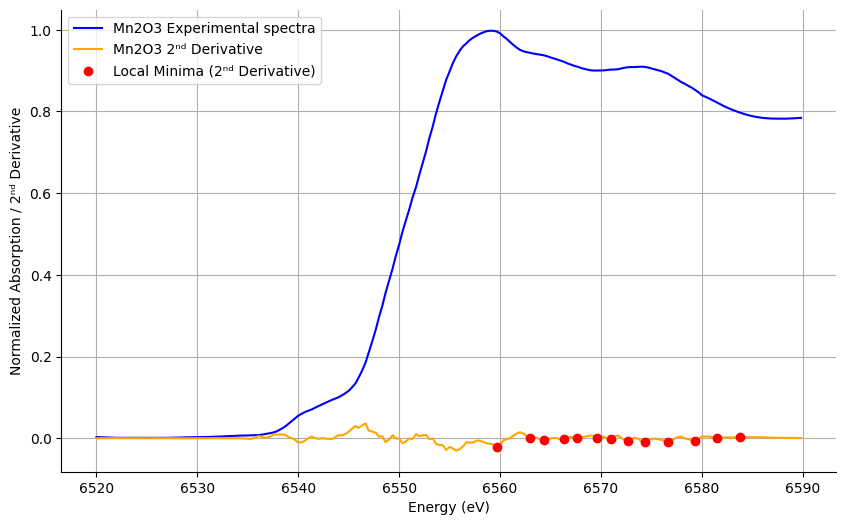

MnO2 error level: 0.0366
Local minima in second derivative (x > white line) for MnO2:
  x = 6561.69, y = -0.0053
  x = 6564.02, y = -0.0091
  x = 6567.98, y = -0.0103
  x = 6570.01, y = 0.0031
  x = 6572.35, y = 0.0047
  x = 6573.67, y = 0.0023
  x = 6574.99, y = -0.0066
  x = 6576.01, y = -0.0042
  x = 6578.66, y = -0.0107
  x = 6579.68, y = -0.0041
  x = 6581.52, y = -0.0018
  x = 6583.81, y = 0.0000


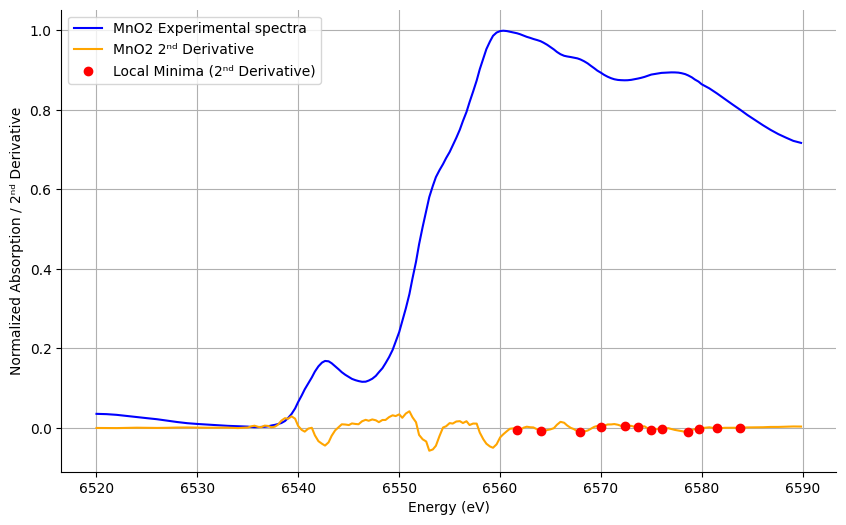

In [1113]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for x > white line
def find_post_white_line_minima(x, y, x_white_line, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    # Calculate the second derivative
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Restrict the search to x > white line
    post_white_line_mask = (x > x_white_line)
    post_white_line_x = x[post_white_line_mask]
    post_white_line_d2y_dx2 = d2y_dx2[post_white_line_mask]
    
    # Find local minima (peaks of -d2y_dx2) in the second derivative for x > white line
    minima_indices, _ = find_peaks(-post_white_line_d2y_dx2)
    local_minima_x = post_white_line_x[minima_indices]
    local_minima_y = post_white_line_d2y_dx2[minima_indices]
    
    # Display the minima x-values and corresponding y-values
    print(f"Local minima in second derivative (x > white line) for {structure_name}:")
    for x_min, y_min in zip(local_minima_x, local_minima_y):
        print(f"  x = {x_min:.2f}, y = {y_min:.4f}")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    # Plot original spectrum
    plt.plot(x, y, label=f'{structure_name} Experimental spectra', color='blue')
    
    # Plot second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    
    # Mark the minima points on the second derivative graph
    plt.scatter(local_minima_x, local_minima_y, color='red', label='Local Minima (2ⁿᵈ Derivative)', zorder=5)
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption / 2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to find the white-line and local maxima in the first derivative
def find_white_line_and_local_maxima_and_minima(x, y, structure_name):
    # Smooth the data before calculating derivatives
    y_smooth = gaussian_filter1d(y, sigma=1)
    
    # Calculate the first derivative
    dy_dx = np.gradient(y_smooth, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    
    # Find the white-line maximum in the smoothed spectrum
    abs_max_index = y_smooth.argmax()
    x_white_line = x[abs_max_index]
    y_white_line = y_smooth[abs_max_index]
     
    # Restrict to x < white line for local maxima in first derivative
    mask = x < x_white_line
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]
    
    # Find local maxima in the first derivative where x < white line
    peaks, _ = find_peaks(dy_dx_below_white_line)
    local_maxima_x = x_below_white_line[peaks]
       
    # Call function to find local minima in second derivative where x > white line
    find_post_white_line_minima(x, y_smooth, x_white_line, structure_name)


# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'x' in df.columns and 'y' in df.columns:
        x = df['x'].values
        y = df['y'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Analysis for each structure
# MnO
x_MnO_exp, y_MnO_exp = extract_data(MnO_exp, "MnO")
if x_MnO_exp is not None and y_MnO_exp is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_exp, y_MnO_exp, "MnO")

# Mn2O3
x_Mn2O3_exp, y_Mn2O3_exp = extract_data(Mn2O3_exp, "Mn2O3")
if x_Mn2O3_exp is not None and y_Mn2O3_exp is not None:
    find_white_line_and_local_maxima_and_minima(x_Mn2O3_exp, y_Mn2O3_exp, "Mn2O3")

# MnO2
x_MnO2_exp, y_MnO2_exp = extract_data(MnO2_exp, "MnO2")
if x_MnO2_exp is not None and y_MnO2_exp is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO2_exp, y_MnO2_exp, "MnO2")


# **Load DFT XANES for MnOx**

In [1114]:
# Load the data for MnO
MnO_data = np.loadtxt('MnO_K_ed_CORE_DIELECTRIC_IMAG.dat')
MnO_DFT = pd.DataFrame(MnO_data, columns=['Energy (eV)', 'Absorption'])

# Load the data for Mn2O3
Mn2O3_data = np.loadtxt('Mn2O3_CLN_1_CORE_DIELECTRIC_IMAG.dat')
Mn2O3_DFT = pd.DataFrame(Mn2O3_data, columns=['Energy (eV)', 'Absorption'])

# Load the data for MnO2
MnO2_data = np.loadtxt('MnO2_CLL_1_CLL_0_CORE_DIELECTRIC_IMAG.dat')
MnO2_DFT = pd.DataFrame(MnO2_data, columns=['Energy (eV)', 'Absorption'])

# Load the data for Mn2O7
Mn2O7_data = np.loadtxt('Mn2O7_CLN1_CLL_0_CORE_DIELECTRIC_IMAG.dat')
Mn2O7_DFT = pd.DataFrame(Mn2O7_data, columns=['Energy (eV)', 'Absorption'])


MnO E₀: 6441.510186100117 eV


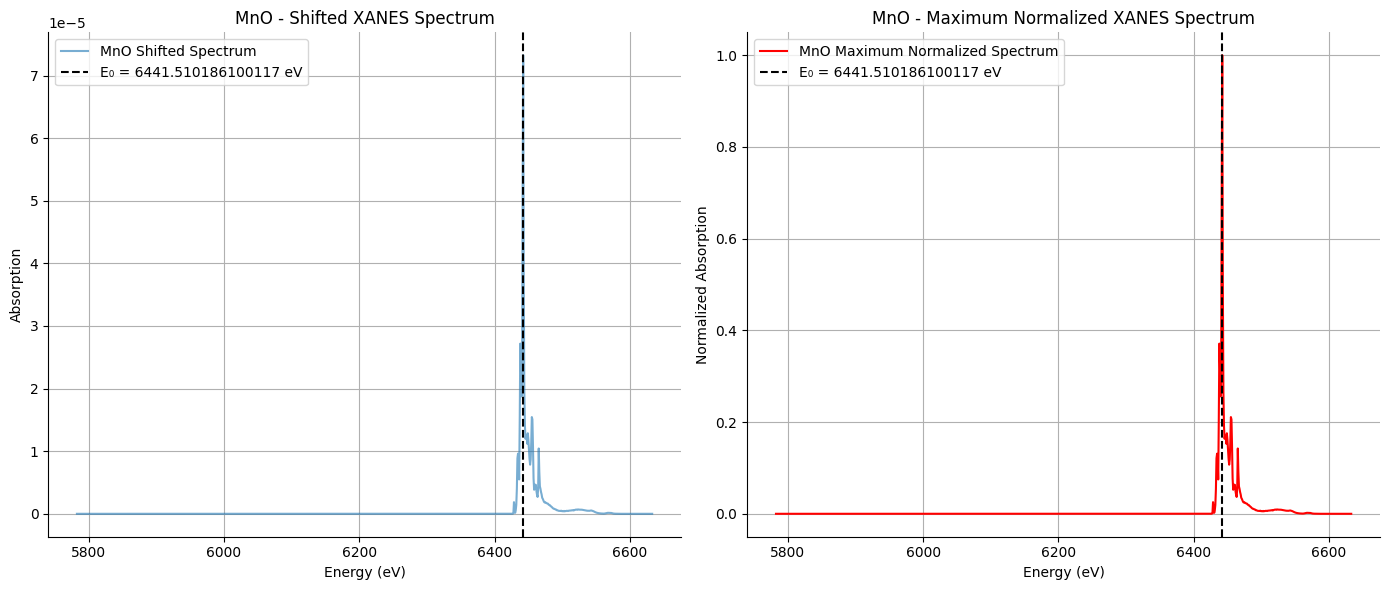

Mn2O3 E₀: 6440.073051669354 eV


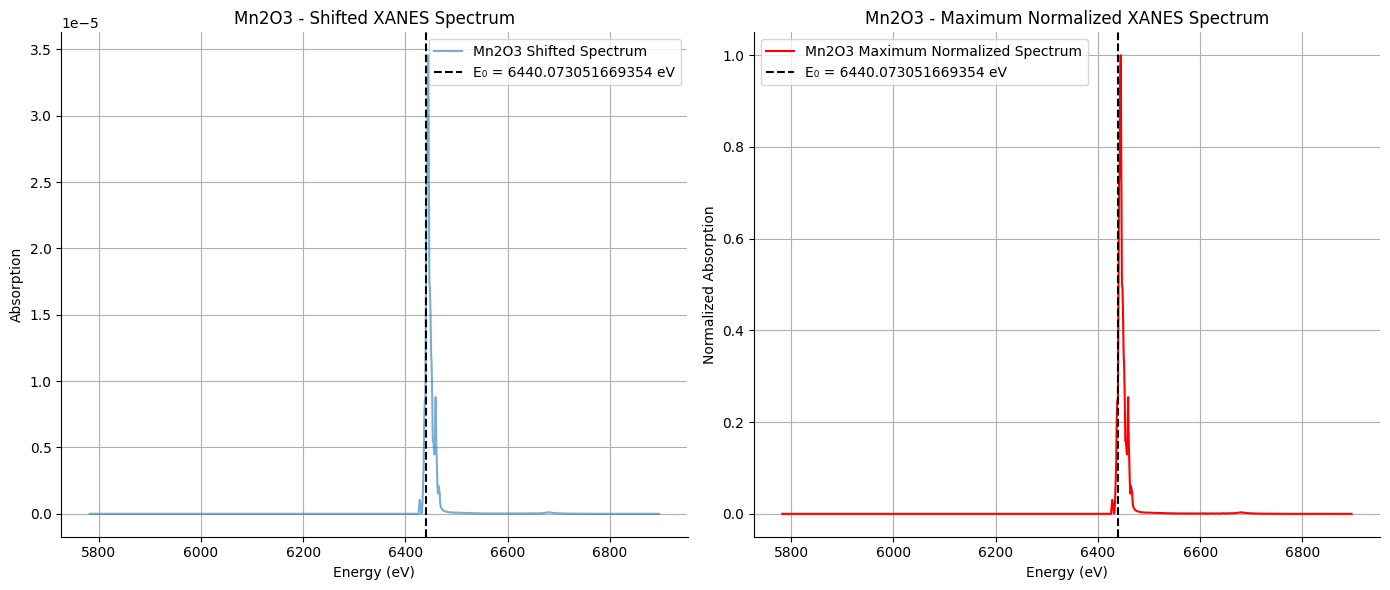

MnO2 E₀: 6443.480655503952 eV


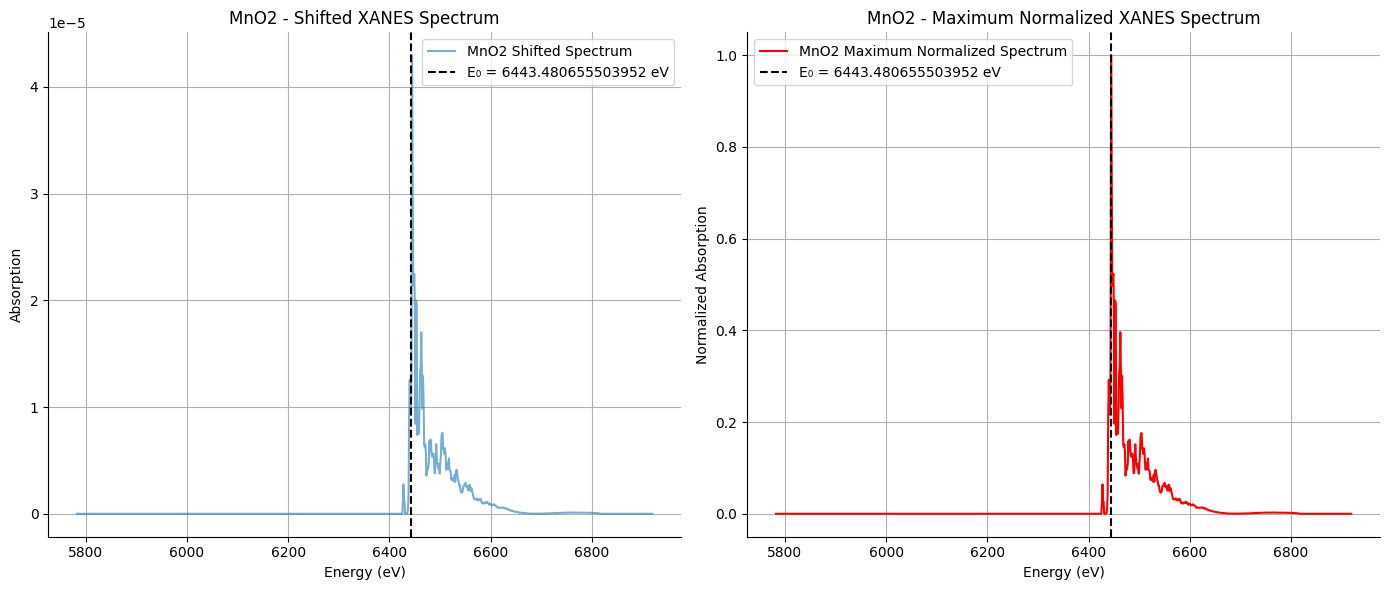

Mn2O7 E₀: 6422.313135637332 eV


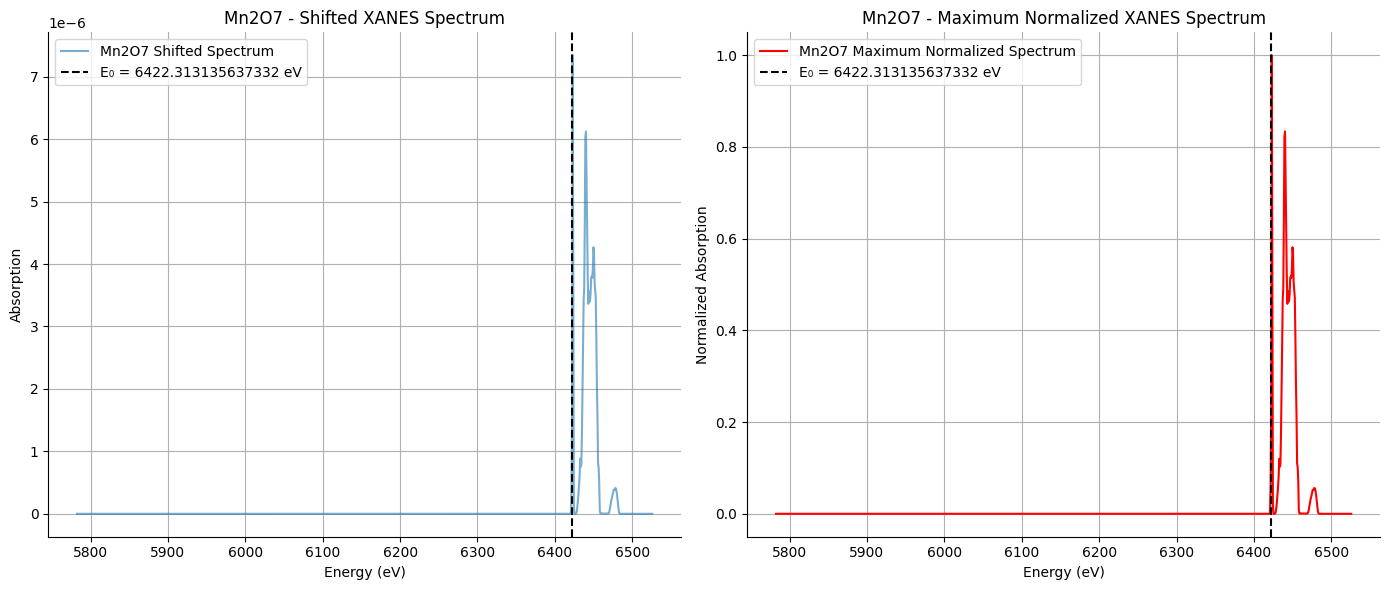

In [1115]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0

# Function to shift the graph up to ensure all values are above 0
def shift_above_zero(y):
    min_y = np.min(y)
    if min_y < 0:
        # Shift the graph upwards so the minimum value becomes 0
        y_shifted = y + abs(min_y)
        return y_shifted
    return y  # If already above zero, return the original data

# Function to normalize the absorption data using maximum normalization
def normalize_max(y):
    # Normalize by dividing by the maximum value
    y_max = np.max(y)
    normalized_y = y / y_max
    return normalized_y

# Global variables for E0 values
E0_MnO_DFT = None
E0_Mn2O3_DFT = None
E0_MnO2_DFT = None
E0_Mn2O7_DFT = None
# Function to normalize and plot for each structure on separate axes
def normalize_and_plot_structure_max(x, y, structure_name):
    global E0_MnO_DFT, E0_Mn2O3_DFT, E0_MnO2_DFT, E0_Mn2O7_DFT  # Use global variables

    # Calculate E₀ from the first derivative
    E0 = calculate_E0(x, y)
    
    # Store E0 values in the appropriate global variable
    if structure_name == "MnO":
        E0_MnO_DFT = E0
    elif structure_name == "Mn2O3":
        E0_Mn2O3_DFT = E0
    elif structure_name == "MnO2":
        E0_MnO2_DFT = E0
    elif structure_name == "Mn2O7":
        E0_Mn2O7_DFT = E0

    print(f"{structure_name} E₀: {E0} eV")
    
    # Shift data upwards if any values are below zero
    shifted_y = shift_above_zero(y)
    
    # Perform maximum normalization after shifting the data
    normalized_y = normalize_max(shifted_y)
    
    # Overwrite the old data with the normalized data
    if structure_name == "MnO":
        MnO_DFT['Absorption'] = normalized_y
    elif structure_name == "Mn2O3":
        Mn2O3_DFT['Absorption'] = normalized_y
    elif structure_name == "MnO2":
        MnO2_DFT['Absorption'] = normalized_y
    elif structure_name == "Mn2O7":
        Mn2O7_DFT['Absorption'] = normalized_y

    # Create two subplots: one for shifted and one for normalized
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the shifted spectrum on the first axis
    ax1.plot(x, shifted_y, label=f'{structure_name} Shifted Spectrum', alpha=0.6)
    ax1.axvline(E0, color='k', linestyle='--', label=f'E₀ = {E0} eV')
    ax1.set_xlabel('Energy (eV)')
    ax1.set_ylabel('Absorption')
    ax1.set_title(f'{structure_name} - Shifted XANES Spectrum')
    ax1.grid(True)
    ax1.legend()

    # Plot the normalized spectrum on the second axis
    ax2.plot(x, normalized_y, label=f'{structure_name} Maximum Normalized Spectrum', color='red')
    ax2.axvline(E0, color='k', linestyle='--', label=f'E₀ = {E0} eV')
    ax2.set_xlabel('Energy (eV)')
    ax2.set_ylabel('Normalized Absorption')
    ax2.set_title(f'{structure_name} - Maximum Normalized XANES Spectrum')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()  # Ensure proper spacing between plots
    plt.show()

# Select the columns of interest for each structure
# MnO
x_MnO = MnO_DFT['Energy (eV)']
y_MnO = MnO_DFT['Absorption']
normalize_and_plot_structure_max(x_MnO, y_MnO, "MnO")

# Mn2O3
x_Mn2O3 = Mn2O3_DFT['Energy (eV)']
y_Mn2O3 = Mn2O3_DFT['Absorption']
normalize_and_plot_structure_max(x_Mn2O3, y_Mn2O3, "Mn2O3")

# MnO2
x_MnO2 = MnO2_DFT['Energy (eV)']
y_MnO2 = MnO2_DFT['Absorption']
normalize_and_plot_structure_max(x_MnO2, y_MnO2, "MnO2")

# MnO2
x_Mn2O7 = Mn2O7_DFT['Energy (eV)']
y_Mn2O7 = Mn2O7_DFT['Absorption']
normalize_and_plot_structure_max(x_Mn2O7, y_Mn2O7, "Mn2O7")


In [1116]:
# Find the energy shifts using White-line 
max_MnO_exp = MnO_exp['y'].idxmax()
max_MnO_DFT = MnO_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_MnO_exp = MnO_exp.loc[max_MnO_exp, 'x']
x_max_MnO_DFT = MnO_DFT.loc[max_MnO_DFT, 'Energy (eV)']
shift_value_MnO =x_max_MnO_exp - x_max_MnO_DFT
MnO_DFT['Energy (eV)'] += shift_value_MnO

# Locate the index of the maximum Y value for the Mn2O3 experimental and DFT data
max_Mn2O3_exp = Mn2O3_exp['y'].idxmax()
max_Mn2O3_DFT = Mn2O3_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_Mn2O3_exp = Mn2O3_exp.loc[max_Mn2O3_exp, 'x']
x_max_Mn2O3_DFT = Mn2O3_DFT.loc[max_Mn2O3_DFT, 'Energy (eV)']
shift_value_Mn2O3 =x_max_Mn2O3_exp - x_max_Mn2O3_DFT 
Mn2O3_DFT['Energy (eV)'] += shift_value_Mn2O3

# Locate the index of the maximum Y value for the MnO2 experimental and DFT data
max_MnO2_exp = MnO2_exp['y'].idxmax()
max_MnO2_DFT = MnO2_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_MnO2_exp = MnO2_exp.loc[max_MnO2_exp, 'x']
x_max_MnO2_DFT = MnO2_DFT.loc[max_MnO2_DFT, 'Energy (eV)']
shift_value_MnO2 =x_max_MnO2_exp - x_max_MnO2_DFT 
MnO2_DFT['Energy (eV)'] += shift_value_MnO2

# Locate the index of the maximum Y value for the MnO experimental and DFT data
max_Mn2O7_exp = 6544
max_Mn2O7_DFT = Mn2O7_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_Mn2O7_exp = 6544
x_max_Mn2O7_DFT = Mn2O7_DFT.loc[max_Mn2O7_DFT, 'Energy (eV)']
shift_value_Mn2O7 =x_max_Mn2O7_exp - x_max_Mn2O7_DFT
Mn2O7_DFT['Energy (eV)'] += shift_value_Mn2O7

# Print the max X values
# print(f'MnO2_experiment max Y at Energy (eV): {x_max_MnO2_exp}')

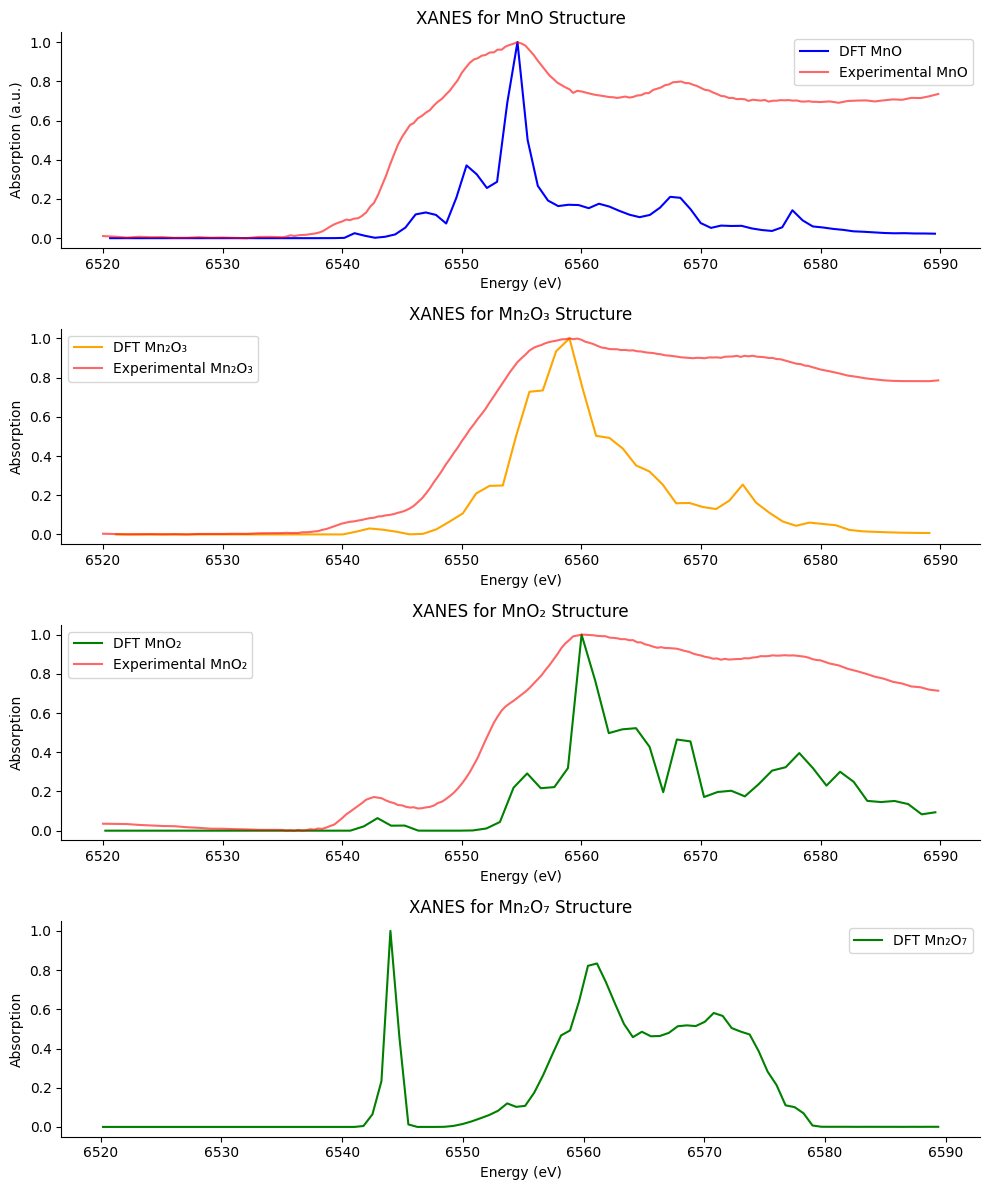

In [1117]:
# Filter the DataFrame to only include rows where Energy >= 6520
MnO_DFT = MnO_DFT[(MnO_DFT["Energy (eV)"] >= 6520) & (MnO_DFT["Energy (eV)"] <= 6590)]
Mn2O3_DFT = Mn2O3_DFT[(Mn2O3_DFT["Energy (eV)"] >= 6520) & (Mn2O3_DFT["Energy (eV)"] <= 6590)]
MnO2_DFT = MnO2_DFT[(MnO2_DFT["Energy (eV)"] >= 6520) & (MnO2_DFT["Energy (eV)"] <= 6590)]
Mn2O7_DFT = Mn2O7_DFT[(Mn2O7_DFT["Energy (eV)"] >= 6520) & (Mn2O7_DFT["Energy (eV)"] <= 6590)]

# Create a figure with three subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))  # 3 rows, 1 column

# Plot for MnO
axs[0].plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='DFT MnO')
axs[0].plot(MnO_exp['x'], MnO_exp['y'], color='red', label='Experimental MnO', alpha=0.6)  # Add experimental data
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Absorption (a.u.)')
axs[0].set_title('XANES for MnO Structure')
axs[0].legend()

# Plot for Mn2O3
axs[1].plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='orange', label='DFT Mn₂O₃')
axs[1].plot(Mn2O3_exp['x'], Mn2O3_exp['y'], color='red', label='Experimental Mn₂O₃', alpha=0.6)  # Add experimental data
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel('Absorption')
axs[1].set_title('XANES for Mn₂O₃ Structure')
axs[1].legend()

# Plot for MnO2
axs[2].plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='green', label='DFT MnO₂')
axs[2].plot(MnO2_exp['x'], MnO2_exp['y'], color='red', label='Experimental MnO₂', alpha=0.6)  # Add experimental data
axs[2].set_xlabel('Energy (eV)')
axs[2].set_ylabel('Absorption')
axs[2].set_title('XANES for MnO₂ Structure')
axs[2].legend()

axs[3].plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='green', label='DFT Mn₂O₇')
axs[3].set_xlabel('Energy (eV)')
axs[3].set_ylabel('Absorption')
axs[3].set_title('XANES for Mn₂O₇ Structure')
axs[3].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plots
plt.show()

# Optimisation of Heaviside and Gaussian broadening parameters

MnO White Line (Energy): 6554.656 eV


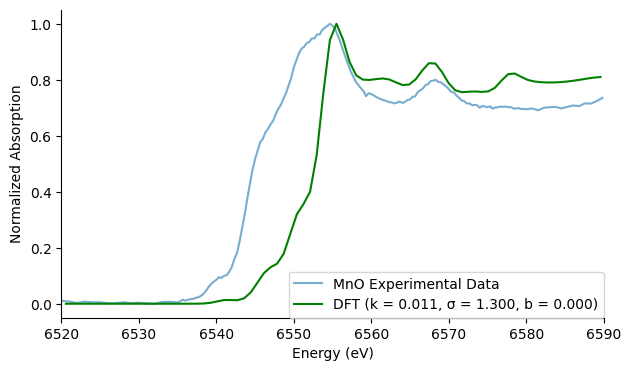

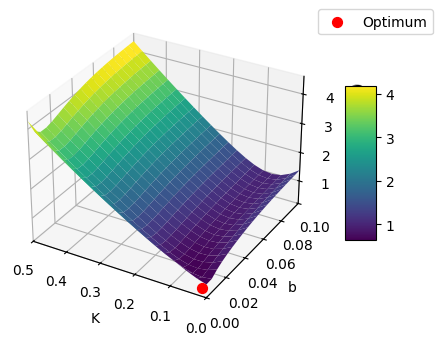

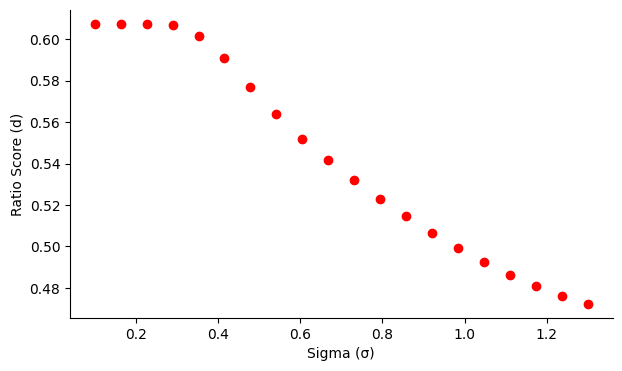

Mn₂O₃ White Line (Energy): 6559.005 eV


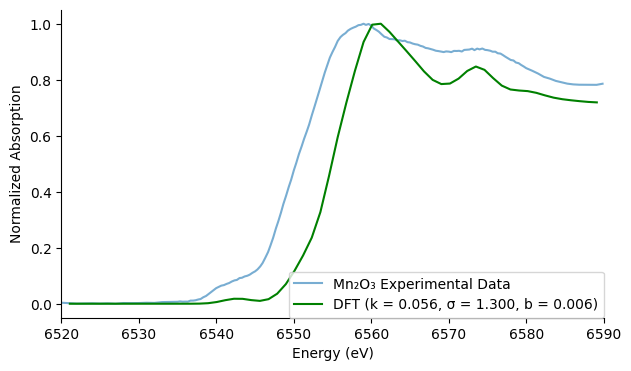

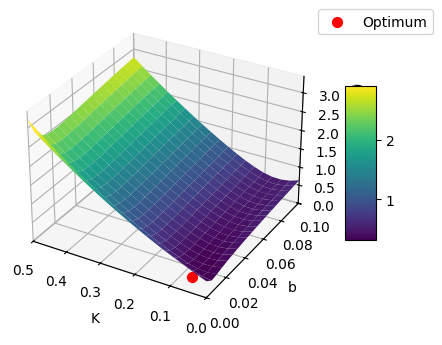

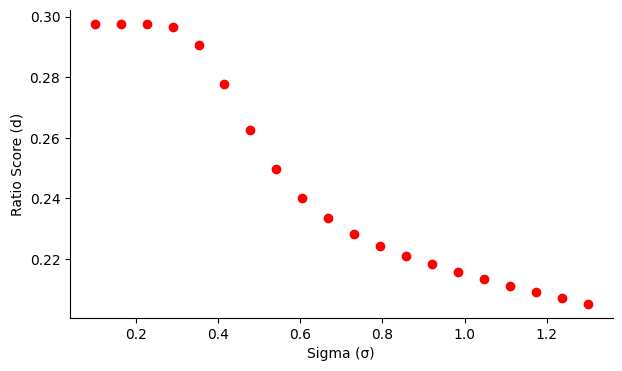

MnO₂ White Line (Energy): 6560.018 eV


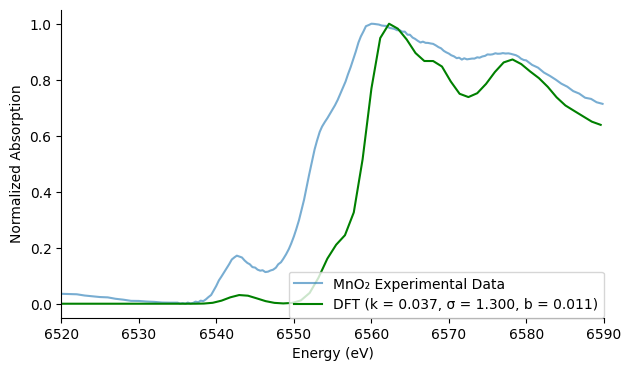

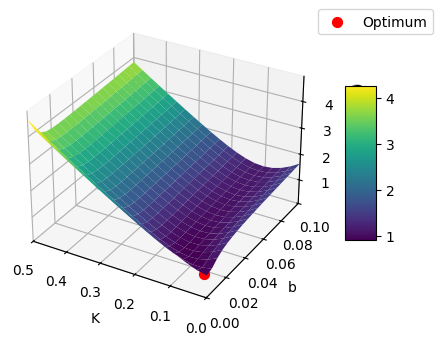

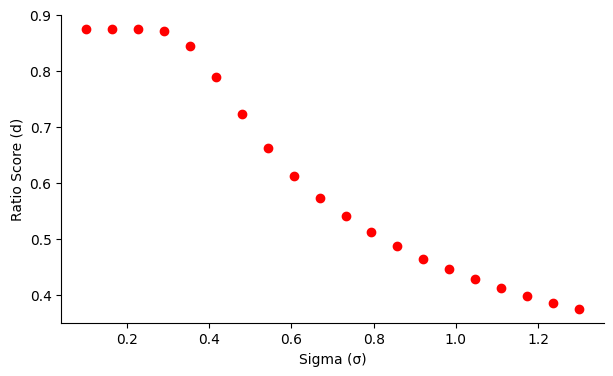

In [1118]:
# Define the Heaviside step function expression with a reduction term
def expression(E, K, white_line, b):
    return (0.5 + 0.5 * np.tanh(K * (E - white_line))) - b * (E - white_line)

# Gaussian broadening function
def apply_gaussian_broadening(y_dft, sigma):
    return gaussian_filter1d(y_dft, sigma)

# Function to compute cosine similarity using gradient (slope) and taking absolute value
def cosine_similarity_gradient(y1, y2, x):
    gradient_y1 = np.gradient(y1, x)
    gradient_y2 = np.gradient(y2, x)
    return (np.dot(gradient_y1, gradient_y2) / (np.linalg.norm(gradient_y1) * np.linalg.norm(gradient_y2)))

# Function to calculate RMSE (Root Mean Squared Error) using standard equation
def calculate_rmse(params, x_dft, x_exp, y_exp, y_dft):
    K, sigma, b = params
    white_line = x_dft[np.argmax(y_dft)]  # Energy where absorption is maximum

    # Calculate Heaviside values and apply above the white line
    heaviside_values = expression(x_dft, K, white_line, b)
    modified_y_dft = np.copy(y_dft)
    modified_y_dft[x_dft > white_line] += heaviside_values[x_dft > white_line]

    # Apply Gaussian broadening after Heaviside modification
    y_dft_broadened = apply_gaussian_broadening(modified_y_dft, sigma)

    # Synchronize x_dft and x_exp to common range and lengths
    common_x_min = max(x_dft.min(), x_exp.min())
    common_x_max = min(x_dft.max(), x_exp.max())
    
    # Restrict x_dft and x_exp to the common range
    common_mask_dft = (x_dft >= common_x_min) & (x_dft <= common_x_max)
    common_mask_exp = (x_exp >= common_x_min) & (x_exp <= common_x_max)
    
    # Apply masks and interpolate y_exp to match DFT x-coordinates
    x_dft_common = x_dft[common_mask_dft]
    y_dft_broadened_common = y_dft_broadened[common_mask_dft]
    x_exp_common = x_exp[common_mask_exp]
    y_exp_common = y_exp[common_mask_exp]
    y_exp_interp = np.interp(x_dft_common, x_exp_common, y_exp_common)

    # Calculate RMSE between the modified DFT and experimental data
    residuals = y_dft_broadened_common - y_exp_interp
    rmse = np.sqrt(np.mean(residuals ** 2))  # Standard RMSE calculation
    return rmse

# Function to apply Heaviside, optimize K, sigma, and b, and plot results
def optimize_K_sigma_b(dft_df, exp_df, structure_name):
    x_dft = dft_df['Energy (eV)'].values
    y_dft = dft_df['Absorption'].values
    x_exp = exp_df['x'].values
    y_exp = exp_df['y'].values

    # Identify the white line (maximum absorption energy in DFT data)
    white_line = x_dft[np.argmax(y_dft)]
    print(f"{structure_name} White Line (Energy): {white_line} eV")

    # Initial guess for the K, sigma, and b parameters
    initial_guess = [0.1, 0.5, 0.01]

    # Define the ratio score objective function (RMSE / absolute cosine similarity gradient)
    def ratio_score(params):
        K, sigma, b = params

        # Apply Heaviside function first, then Gaussian broadening
        heaviside_values = expression(x_dft, K, white_line, b)
        modified_y_dft = np.copy(y_dft)
        modified_y_dft[x_dft > white_line] += heaviside_values[x_dft > white_line]
        
        y_dft_broadened = apply_gaussian_broadening(modified_y_dft, sigma)

        # Cosine similarity calculation using gradients and absolute value
        y_dft_interp = np.interp(x_exp, x_dft, y_dft_broadened)
        cos_sim_gradient = cosine_similarity_gradient(y_exp, y_dft_interp, x_exp)

        # Calculate RMSE and ratio score
        rmse = calculate_rmse(params, x_dft, x_exp, y_exp, y_dft)
        ratio = rmse / cos_sim_gradient if cos_sim_gradient != 0 else np.inf
        return ratio

    # Optimize K, sigma, and b
    result = minimize(ratio_score, initial_guess, bounds=[(0, 0.5), (0.1, 1.3), (0, 0.1)])
    optimal_K, optimal_sigma, optimal_b = result.x

    # Apply Heaviside and Gaussian broadening with optimized parameters
    heaviside_values = expression(x_dft, optimal_K, white_line, optimal_b)
    modified_y_dft = np.copy(y_dft)
    modified_y_dft[x_dft > white_line] += heaviside_values[x_dft > white_line]
    y_dft_broadened = apply_gaussian_broadening(modified_y_dft, optimal_sigma)
    
    # Normalize for plotting
    y_dft_normalized = y_dft_broadened / np.max(y_dft_broadened)

    # Plot experimental data and modified DFT data
    plt.figure(figsize=(7, 4))
    plt.plot(x_exp, y_exp, label=f'{structure_name} Experimental Data', alpha=0.6)
    plt.plot(x_dft, y_dft_normalized, label=f'DFT (k = {optimal_K:.3f}, σ = {optimal_sigma:.3f}, b = {optimal_b:.3f})', color='green', linestyle='-')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption')
    plt.legend(loc='lower right', borderaxespad=0)
    plt.xlim(6520, 6590)
    plt.show()

    # 3D Surface Plot of Ratio Scores across K and b values with fixed sigma slice
    ratio_scores = []
    k_values = np.linspace(0, 0.5, 20)
    sigma_values = np.linspace(0.1, 1.3, 20)
    b_values = np.linspace(0, 0.1, 20)

    for k in k_values:
        for sigma in sigma_values:
            for b in b_values:
                ratio = ratio_score([k, sigma, b])
                ratio_scores.append(ratio)

    ratio_scores = np.array(ratio_scores).reshape(len(k_values), len(sigma_values), len(b_values))

    K, b = np.meshgrid(k_values, b_values)
    Ratio = ratio_scores[:, 0, :]

    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(K, b, Ratio, cmap='viridis', edgecolor='none')
    ax.scatter(optimal_K, optimal_b, ratio_score([optimal_K, optimal_sigma, optimal_b]), color='red', s=50, label='Optimum', zorder=5)
    ax.set_xlim(max(k_values), min(k_values))
    ax.set_ylim(min(b_values), max(b_values))
    ax.set_xlabel('K')
    ax.set_ylabel('b')
    ax.set_zlabel('Ratio Score (d)')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
    plt.show()

    # 2D Plot of Ratio vs Sigma
    ratios_for_sigma = [ratio_score([optimal_K, sigma, optimal_b]) for sigma in sigma_values]
    plt.figure(figsize=(7, 4))
    plt.scatter(sigma_values, ratios_for_sigma, color='red', marker='o')
    plt.xlabel('Sigma (σ)')
    plt.ylabel('Ratio Score (d)')
    plt.show()

    # Update normalized values in dataframes
    dft_df['Absorption'] = y_dft_normalized

# Run optimization for MnO, Mn2O3, and MnO2 structures
optimize_K_sigma_b(MnO_DFT, MnO_exp, "MnO")
optimize_K_sigma_b(Mn2O3_DFT, Mn2O3_exp, "Mn₂O₃")
optimize_K_sigma_b(MnO2_DFT, MnO2_exp, "MnO₂")

In [1119]:
# Find the energy shifts using White-line 
max_MnO_exp = MnO_exp['y'].idxmax()
max_MnO_DFT = MnO_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_MnO_exp = MnO_exp.loc[max_MnO_exp, 'x']
x_max_MnO_DFT = MnO_DFT.loc[max_MnO_DFT, 'Energy (eV)']
shift_value_MnO =x_max_MnO_exp - x_max_MnO_DFT
MnO_DFT['Energy (eV)'] += shift_value_MnO

# Locate the index of the maximum Y value for the Mn2O3 experimental and DFT data
max_Mn2O3_exp = Mn2O3_exp['y'].idxmax()
max_Mn2O3_DFT = Mn2O3_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_Mn2O3_exp = Mn2O3_exp.loc[max_Mn2O3_exp, 'x']
x_max_Mn2O3_DFT = Mn2O3_DFT.loc[max_Mn2O3_DFT, 'Energy (eV)']
shift_value_Mn2O3 =x_max_Mn2O3_exp - x_max_Mn2O3_DFT 
Mn2O3_DFT['Energy (eV)'] += shift_value_Mn2O3

# Locate the index of the maximum Y value for the MnO2 experimental and DFT data
max_MnO2_exp = MnO2_exp['y'].idxmax()
max_MnO2_DFT = MnO2_DFT['Absorption'].idxmax()

# Find the corresponding X values
x_max_MnO2_exp = MnO2_exp.loc[max_MnO2_exp, 'x']
x_max_MnO2_DFT = MnO2_DFT.loc[max_MnO2_DFT, 'Energy (eV)']
shift_value_MnO2 =x_max_MnO2_exp - x_max_MnO2_DFT 
MnO2_DFT['Energy (eV)'] += shift_value_MnO2

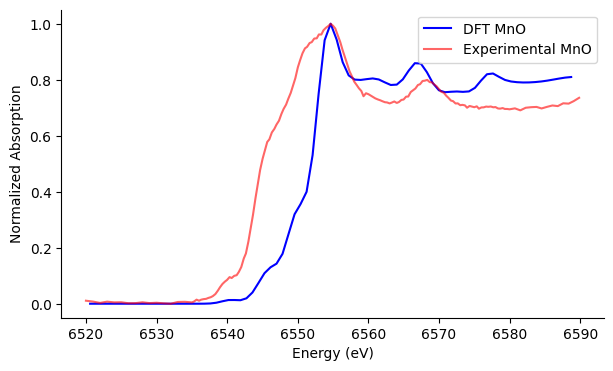

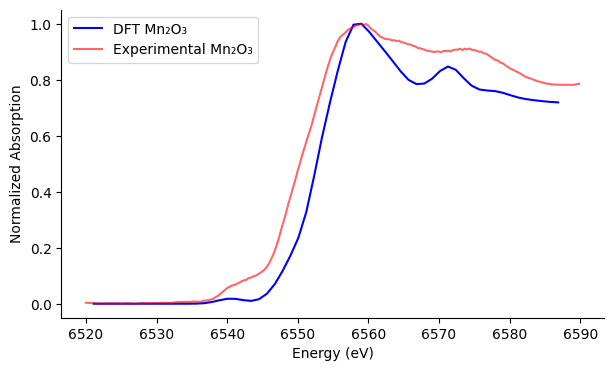

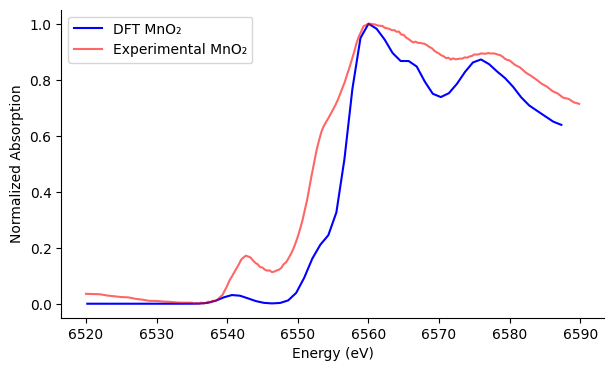

In [1120]:
# Filter the DataFrame to only include rows where Energy >= 6520
MnO_DFT = MnO_DFT[(MnO_DFT["Energy (eV)"] >= 6520) & (MnO_DFT["Energy (eV)"] <= 6590)]
Mn2O3_DFT = Mn2O3_DFT[(Mn2O3_DFT["Energy (eV)"] >= 6520) & (Mn2O3_DFT["Energy (eV)"] <= 6590)]
MnO2_DFT = MnO2_DFT[(MnO2_DFT["Energy (eV)"] >= 6520) & (MnO2_DFT["Energy (eV)"] <= 6590)]
Mn2O7_DFT = Mn2O7_DFT[(Mn2O7_DFT["Energy (eV)"] >= 6520) & (Mn2O7_DFT["Energy (eV)"] <= 6590)]

# Plot for MnO
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='DFT MnO')
plt.plot(MnO_exp['x'], MnO_exp['y'], color='red', label='Experimental MnO', alpha=0.6)
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# Plot for Mn2O3
plt.figure(figsize=(7, 4))
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='blue', label='DFT Mn₂O₃')
plt.plot(Mn2O3_exp['x'], Mn2O3_exp['y'], color='red', label='Experimental Mn₂O₃', alpha=0.6)
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# Plot for MnO2
plt.figure(figsize=(7, 4))
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='blue', label='DFT MnO₂')
plt.plot(MnO2_exp['x'], MnO2_exp['y'], color='red', label='Experimental MnO₂', alpha=0.6)
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# Apply average optimised parameters for Mn₂O₇

Mn2O7 White Line (Energy): 6544.0 eV


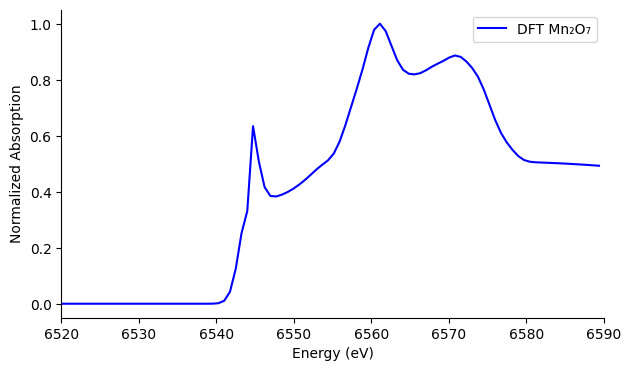

In [1121]:
# Function for applying Gaussian broadening
def apply_gaussian_broadening(y_dft, sigma):
    return gaussian_filter1d(y_dft, sigma)

# Heaviside step function for K optimization
def expression(E, K, white_line,b):
    return 0.5 + 0.5 * np.tanh(K * (E - white_line))-b*(E-white_line)

# Apply Heaviside and Gaussian broadening with average K and sigma
def apply_broadening_to_Mn2O7(dft_df, K_avg, sigma_avg,b_avg):
    x_dft = dft_df['Energy (eV)'].values
    y_dft = dft_df['Absorption'].values

    # Find the white line (energy corresponding to maximum absorption in DFT data)
    white_line = x_dft[np.argmax(y_dft)]
    print(f"Mn2O7 White Line (Energy): {white_line} eV")

    # Apply Gaussian broadening
    y_dft_broadened = apply_gaussian_broadening(y_dft, sigma_avg)

    # Apply Heaviside values above the white line
    heaviside_values = expression(x_dft, K_avg, white_line,b_avg)

    # Modify only the values above the white line
    modified_y_dft = np.copy(y_dft_broadened)
    modified_y_dft[x_dft > white_line] += heaviside_values[x_dft > white_line]

    # Normalize the modified DFT absorption data
    renormalized_y_dft = modified_y_dft / np.max(modified_y_dft)
    
    # Plot the modified DFT data
    plt.figure(figsize=(7, 4))
    plt.plot(x_dft, renormalized_y_dft, color='blue', label='DFT Mn₂O₇')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption')
    plt.legend()
    plt.xlim(6520,6590)
    plt.show()

    # Save the renormalized data back into the DataFrame
    dft_df['Absorption'] = renormalized_y_dft

# Compute average K and sigma from previous results
K_avg = (0.011+0.056+0.037) / 3  # Replace these values with actual optimized K values
sigma_avg = (1.3 + 1.3 + 1.3) / 3  # Replace these values with actual optimized sigma values
b_avg = (0+0.006+.011)/3        # Replace these values with actual optimized b values
# Apply the broadening to Mn2O7 DFT data
apply_broadening_to_Mn2O7(Mn2O7_DFT, K_avg, sigma_avg,b_avg)


# **PRE-EDGE & E₀** 

MnO error level: 0.0452
 MnO pre-edge: x = 6540.18, y = 0.0132


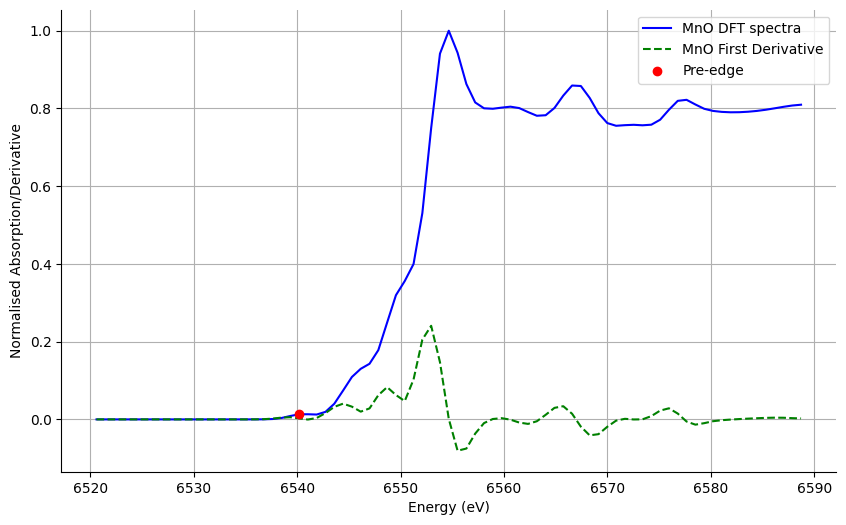

First derivative local maxima (E₀) of MnO: [6539.32853233 6544.43768822 6548.69531813 6552.95294804]
Mn₂O₃ error level: 0.0360
 Mn₂O₃ pre-edge: x = 6540.06, y = 0.0178


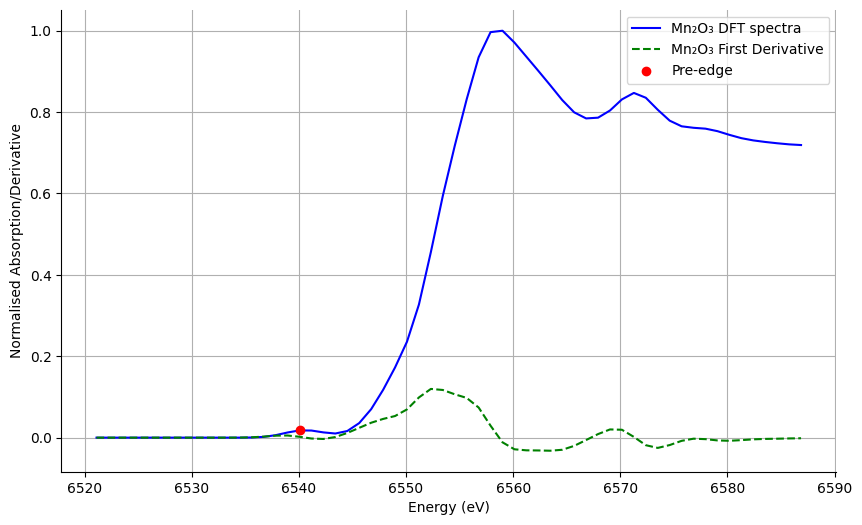

First derivative local maxima (E₀) of Mn₂O₃: [6538.94128549 6552.31709516]
MnO₂ error level: 0.0446
 MnO₂ pre-edge: x = 6540.68, y = 0.0310


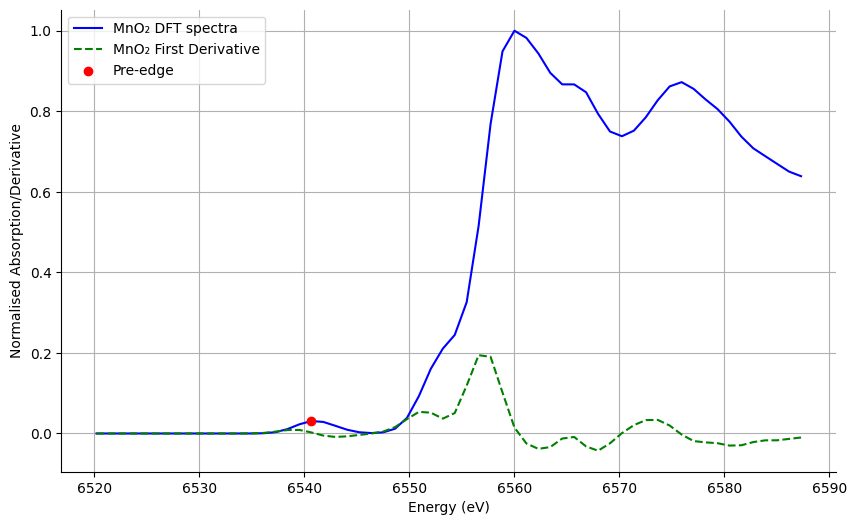

First derivative local maxima (E₀) of MnO₂: [6539.53791665 6550.91574073 6556.60465277]


In [1122]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)
    E1 = E0 * 0.9985
    # Restrict to pre-edge region (before E₀)
    pre_edge_mask = (x < E1)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    
    # Check if pre-edge region has values
    if len(pre_edge_x) == 0 or len(pre_edge_d2y_dx2) == 0:
        print(f"Warning: No data points found in pre-edge region for {structure_name}.")
        return
    
    # Find the true minimum points in the pre-edge region of the second derivative
    min_index = np.argmin(pre_edge_d2y_dx2)  # Index of the absolute minimum
    x_min = pre_edge_x[min_index]
    y_min = y[pre_edge_mask][min_index]
    
    # Display the minimum x and y values
    print(f" {structure_name} pre-edge: x = {x_min:.2f}, y = {y_min:.4f}")

    # Plot the original data, the second derivative, and the minimum point
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    
    # Plot the second derivative
    plt.plot(x, dy_dx, label=f'{structure_name} First Derivative', linestyle='--', color='green')
    # Mark the minimum point
    plt.scatter(x_min, y_min, color='red', label='Pre-edge', zorder=5)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption/Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to find the white-line and local maxima in the first derivative
def find_white_line_and_local_maxima(x, y,structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the index of the absolute maximum in the y column (white-line)
    abs_max_index = y.argmax()
    x_abs_max = x[abs_max_index]
    y_abs_max = y[abs_max_index]

    # Restrict the first derivative to values where x < white-line
    mask = x < x_abs_max
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]

    # Find local maxima in the first derivative for x values < white-line
    peaks, _ = find_peaks(dy_dx_below_white_line)
    local_maxima_x = x_below_white_line[peaks]
    
    # Print the x-values of local maxima in the first derivative before the white-line
    print(f'First derivative local maxima (E₀) of {structure_name}: {local_maxima_x}')

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Select the columns of interest for each structure
# MnO
x_MnO, y_MnO = extract_data(MnO_DFT, "MnO")
if x_MnO is not None and y_MnO is not None:
    E0_MnO, dy_dx_MnO = calculate_E0(x_MnO, y_MnO)
    find_pre_edge_minima(x_MnO, y_MnO, E0_MnO, "MnO")
    find_white_line_and_local_maxima(x_MnO, y_MnO,"MnO")

# Mn2O3
x_Mn2O3, y_Mn2O3 = extract_data(Mn2O3_DFT, "Mn₂O₃")
if x_Mn2O3 is not None and y_Mn2O3 is not None:
    E0_Mn2O3, dy_dx_Mn2O3 = calculate_E0(x_Mn2O3, y_Mn2O3)
    find_pre_edge_minima(x_Mn2O3, y_Mn2O3, E0_Mn2O3, "Mn₂O₃")
    find_white_line_and_local_maxima(x_Mn2O3, y_Mn2O3,"Mn₂O₃")

# MnO2
x_MnO2, y_MnO2 = extract_data(MnO2_DFT, "MnO₂")
if x_MnO2 is not None and y_MnO2 is not None:
    E0_MnO2, dy_dx_MnO2 = calculate_E0(x_MnO2, y_MnO2)
    find_pre_edge_minima(x_MnO2, y_MnO2, E0_MnO2, "MnO₂")
    find_white_line_and_local_maxima(x_MnO2, y_MnO2,"MnO₂")


Minimum in pre-edge region for Mn₂O₇:
  Minimum: x = 6544.74, y = 0.6341


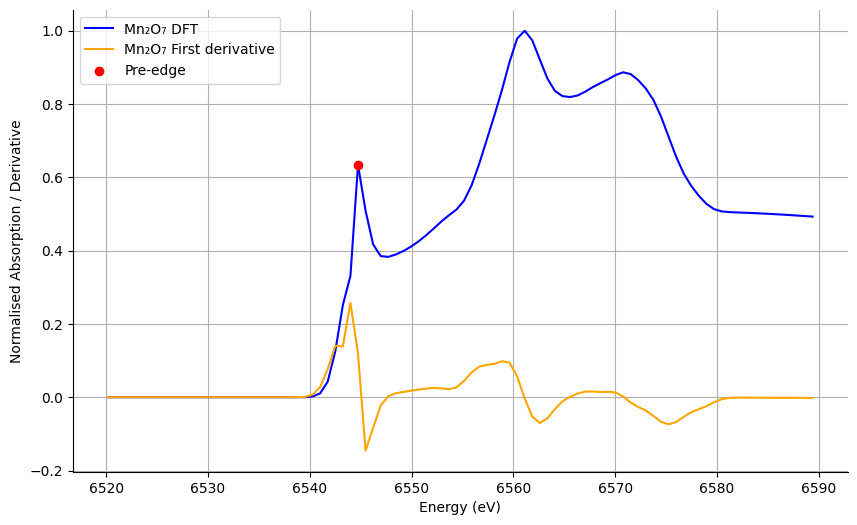

In [1123]:
#Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]*1.001
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    
    # Compute the 2ⁿᵈ Derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)

    # Restrict to pre-edge region (before E₀)
    pre_edge_mask = (x < E0)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    
    # Find the true minimum points in the pre-edge region of the second derivative
    min_index = np.argmin(pre_edge_d2y_dx2)  # Index of the absolute minimum
    x_min = pre_edge_x[min_index]
    y_min = y[pre_edge_mask][min_index]
    
    # Display the minimum x and y values
    print(f"Minimum in pre-edge region for {structure_name}:")
    print(f"  Minimum: x = {x_min:.2f}, y = {y_min:.4f}")

    # Plot the original data, the First derivative, and the minimum point
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT ', color='blue')
    
    # Plot the second derivative
    plt.plot(x, dy_dx, label=f'{structure_name} First derivative', color='orange')
    
    # Mark the minimum point
    plt.scatter(x_min, y_min, color='red', label='Pre-edge', zorder=5)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption / Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()


# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Mn2O7
x_Mn2O7, y_Mn2O7 = extract_data(Mn2O7_DFT, "Mn₂O₇")
if x_Mn2O7 is not None and y_Mn2O3 is not None:
    E0_Mn2O7, _ = calculate_E0(x_Mn2O7, y_Mn2O7)
    find_pre_edge_minima(x_Mn2O7, y_Mn2O7, E0_Mn2O7, "Mn₂O₇")


# **PRE-EDGE & SHOULDERS**

MnO ring error level: 0.0386
MnO ring error level: 0.0386
Local minima in second derivative (x > white line) for MnO ring:
  x = 6540.18, y = -0.0008
  x = 6545.29, y = -0.0030
  x = 6549.55, y = 0.0046


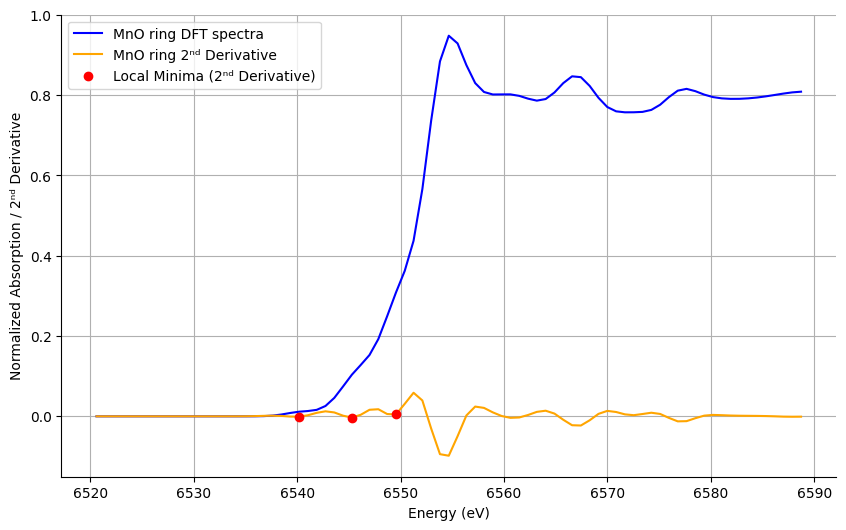

Mn2O3 error level: 0.0342
Mn2O3 error level: 0.0342
Local minima in second derivative (x > white line) for Mn2O3:
  x = 6540.06, y = -0.0020
  x = 6546.74, y = 0.0097


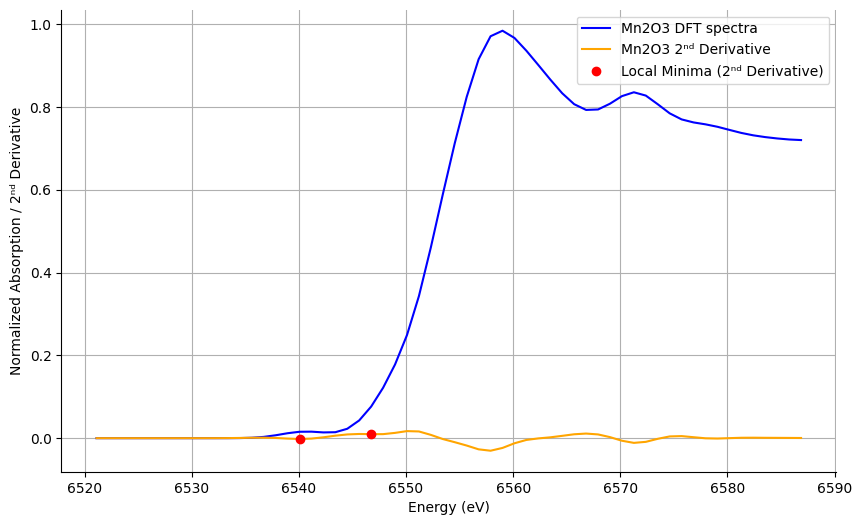

MnO2 error level: 0.0397
MnO2 error level: 0.0397
Local minima in second derivative (x > white line) for MnO2:
  x = 6540.68, y = -0.0042
  x = 6552.05, y = 0.0018
  x = 6558.88, y = -0.0534


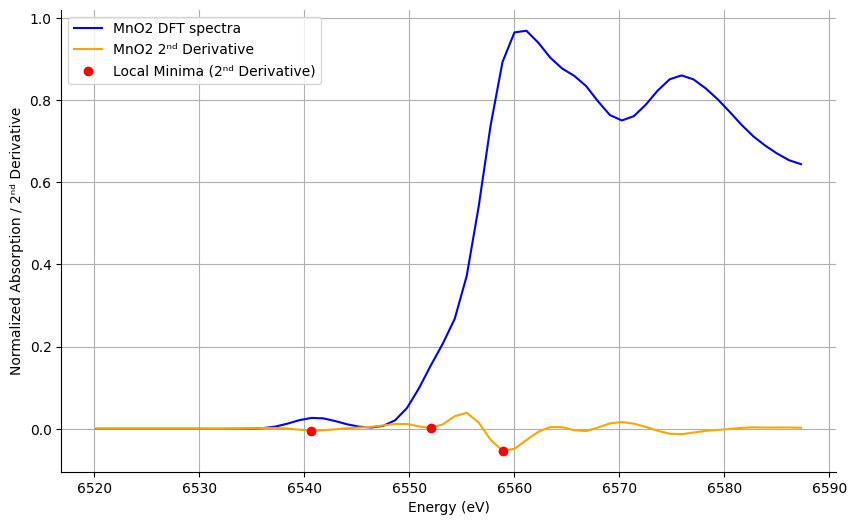

Mn2O7 error level: 0.0424
Mn2O7 error level: 0.0424
Local minima in second derivative (x > white line) for Mn2O7:
  x = 6544.74, y = -0.1350
  x = 6552.18, y = 0.0007


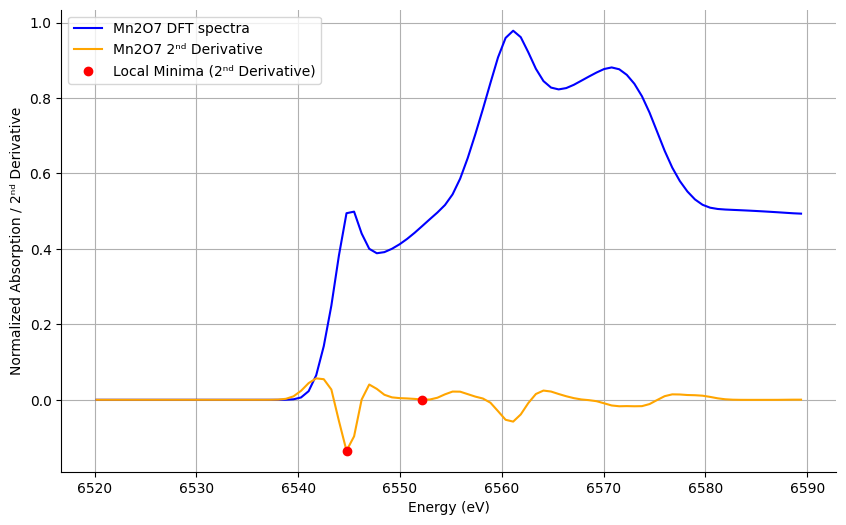

In [1124]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for x > white line
def find_post_white_line_minima(x, y, x_white_line, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')    
    # Calculate the second derivative
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Restrict the search to x > white line
    post_white_line_mask = (x < x_white_line)
    post_white_line_x = x[post_white_line_mask]
    post_white_line_d2y_dx2 = d2y_dx2[post_white_line_mask]
    
    # Find local minima (peaks of -d2y_dx2) in the second derivative for x > white line
    minima_indices, _ = find_peaks(-post_white_line_d2y_dx2)
    local_minima_x = post_white_line_x[minima_indices]
    local_minima_y = post_white_line_d2y_dx2[minima_indices]
    
    # Display the minima x-values and corresponding y-values
    print(f"Local minima in second derivative (x > white line) for {structure_name}:")
    for x_min, y_min in zip(local_minima_x, local_minima_y):
        print(f"  x = {x_min:.2f}, y = {y_min:.4f}")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    # Plot original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    
    # Plot second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    
    # Mark the minima points on the second derivative graph
    plt.scatter(local_minima_x, local_minima_y, color='red', label='Local Minima (2ⁿᵈ Derivative)', zorder=5)
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption / 2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Analysis for each structure
# MnO ring
x_MnO_DFT, y_MnO_DFT = extract_data(MnO_DFT, "MnO")
if x_MnO_DFT is not None and y_MnO_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_DFT, y_MnO_DFT, "MnO ring")

# MnO string
x_Mn2O3_DFT, y_Mn2O3_DFT= extract_data(Mn2O3_DFT, "Mn2O3")
if x_Mn2O3_DFT is not None and y_Mn2O3_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_Mn2O3_DFT, y_Mn2O3_DFT, "Mn2O3")

# OMnO
x_MnO2_DFT, y_MnO2_DFT = extract_data(MnO2_DFT, "MnO2")
if x_MnO2_DFT is not None and y_MnO2_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO2_DFT, y_MnO2_DFT, "MnO2")

# OMnOMnO
x_Mn2O7_DFT, y_Mn2O7_DFT = extract_data(Mn2O7_DFT, "Mn2O7")
if x_Mn2O7_DFT is not None and y_Mn2O7_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_Mn2O7_DFT, y_Mn2O7_DFT, "Mn2O7")


Mn₂O₇ error level: 0.0510
Local maxima of the first derivative in the pre-edge region:
  x = 6552.18, y' = 0.0253
  x = 6558.88, y' = 0.0981
Minimum in pre-edge region for Mn₂O₇:
  Minimum: x = 6544.74, y = 0.6341


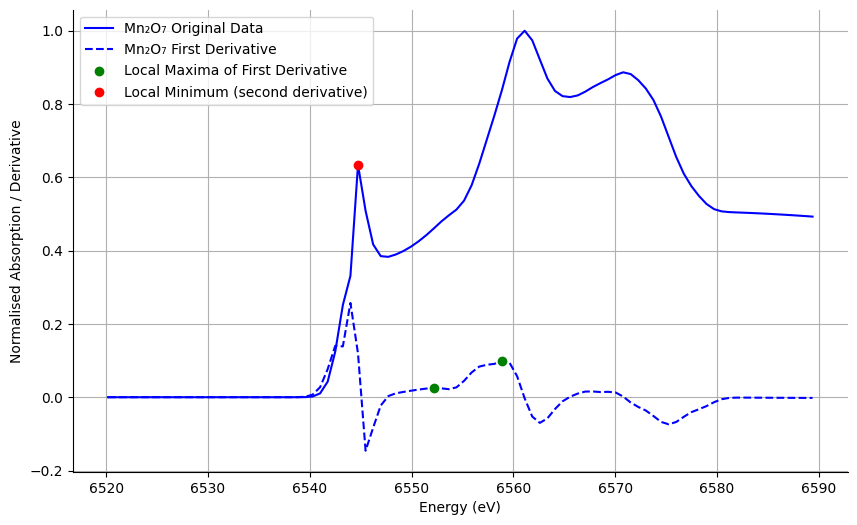

In [1125]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find local maxima of the first derivative
def find_local_maxima(x, dy_dx, white_line, E0):
    # Restrict to region x < white_line
    pre_edge_mask = (x < white_line) & (x > E0)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_dy_dx = dy_dx[pre_edge_mask]

    # Find local maxima (peaks) in the first derivative
    peaks, _ = find_peaks(pre_edge_dy_dx)
    
    local_maxima = pre_edge_x[peaks]
    peak_values = pre_edge_dy_dx[peaks]
    
    # Print the local maxima in the specified region
    print("Local maxima of the first derivative in the pre-edge region:")
    for x_peak, y_peak in zip(local_maxima, peak_values):
        print(f"  x = {x_peak:.2f}, y' = {y_peak:.4f}")
    
    return local_maxima, peak_values

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')    
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Find the white line position (where y is maximum)
    white_line = x[np.argmax(y)]
    
    # Find local maxima of the first derivative
    local_maxima, peak_values = find_local_maxima(x, dy_dx, white_line, E0)
    
    # Restrict to pre-edge region (between E₀ and white_line)
    pre_edge_mask = (x > E0) & (x < white_line)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    pre_edge_y = y[pre_edge_mask]

    # Find the true minimum point in the pre-edge region of the second derivative
    if len(pre_edge_x) > 0:
        min_index = np.argmin(pre_edge_d2y_dx2)
        x_min = pre_edge_x[min_index]
        y_min = pre_edge_y[min_index]

        # Display the minimum x and y values
        print(f"Minimum in pre-edge region for {structure_name}:")
        print(f"  Minimum: x = {x_min:.2f}, y = {y_min:.4f}")
    else:
        print(f"No valid pre-edge region found for {structure_name} between E₀ and the white line.")

    # Plot the original data, the first and second derivatives, and the local maxima
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} Original Data', color='blue')
    
    # Plot the first and second derivatives
    plt.plot(x, dy_dx, label=f'{structure_name} First Derivative', linestyle='--', color='blue')
    
    # Mark the local maxima of the first derivative
    plt.scatter(local_maxima, peak_values, color='green', label='Local Maxima of First Derivative', zorder=5)
    
    # Mark the minimum point if found
    if len(pre_edge_x) > 0:
        plt.scatter(x_min, y_min, color='red', label='Local Minimum (second derivative)', zorder=5)
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption / Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (assuming MnO_exp, Mn2O3_exp, and MnO2_exp are DataFrames with columns 'x' and 'y')
# Mn2O7
x_Mn2O7 = Mn2O7_DFT['Energy (eV)'].values
y_Mn2O7 = Mn2O7_DFT['Absorption'].values
E0_Mn2O7, _ = calculate_E0(x_Mn2O7, y_Mn2O7)
find_pre_edge_minima(x_Mn2O7, y_Mn2O7, E0_Mn2O7, "Mn₂O₇")


# **WHITE-LINE**

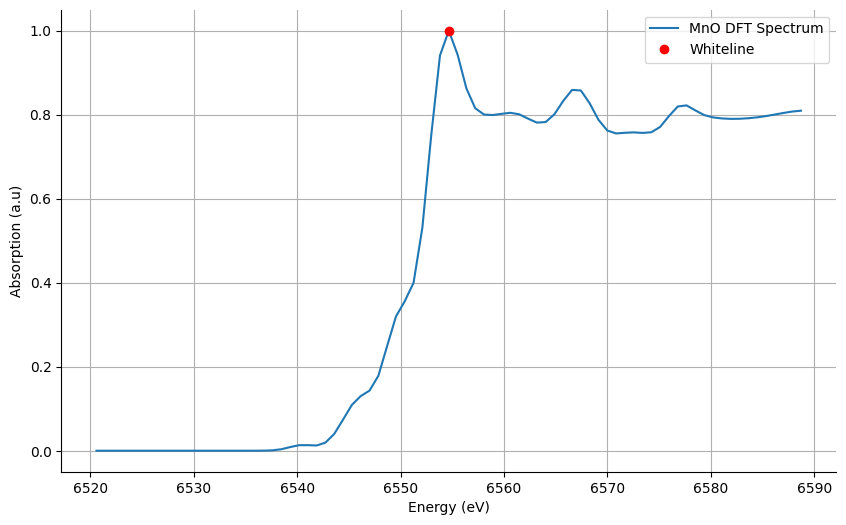

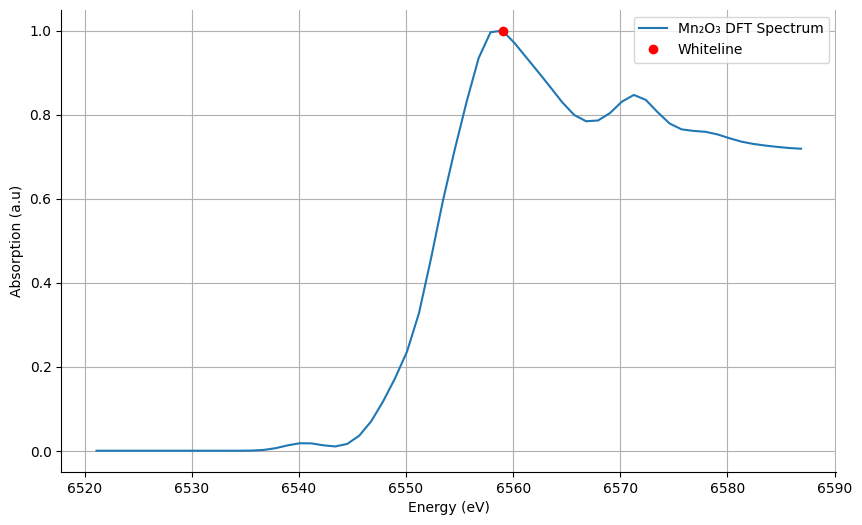

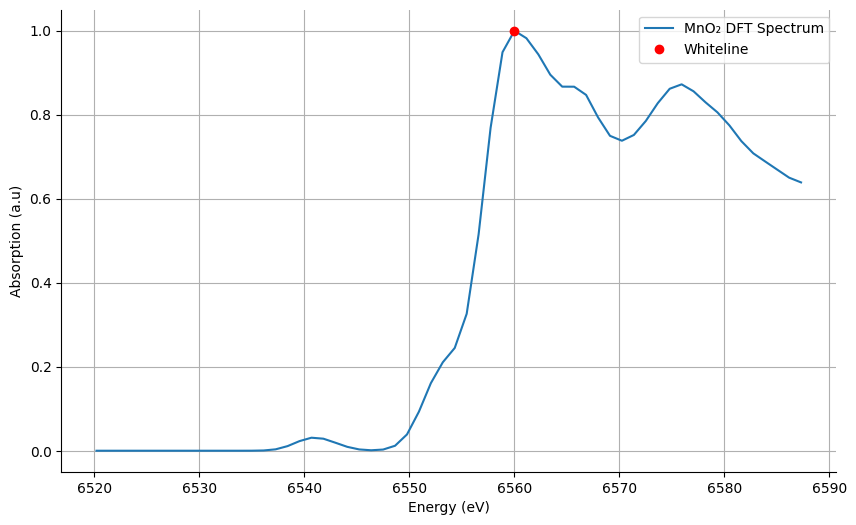

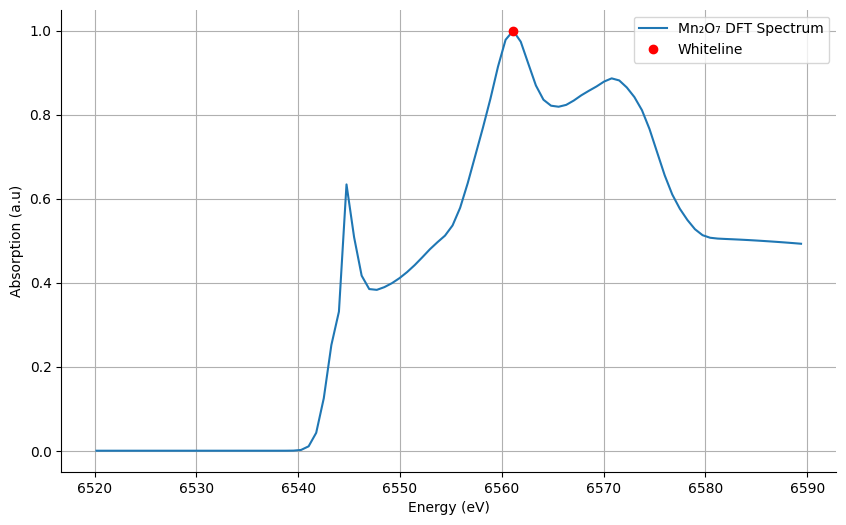

In [1126]:
# Function to plot spectra and mark the absolute maximum (whiteline)
def plot_spectrum_with_whiteline(data, structure_name):
    # Extract the x and y values from the DataFrame
    x = data['Energy (eV)']
    y = data['Absorption']

    # Find the index of the absolute maximum in the y column
    abs_max_index = y.idxmax()
    # Get the corresponding x and y values for the whiteline
    x_abs_max = x[abs_max_index]
    y_abs_max = y[abs_max_index]

    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} DFT Spectrum')
    plt.plot(x_abs_max, y_abs_max, 'ro', label='Whiteline')  # Mark the whiteline
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot each spectrum with whiteline marked
plot_spectrum_with_whiteline(MnO_DFT, "MnO")
plot_spectrum_with_whiteline(Mn2O3_DFT, "Mn₂O₃")
plot_spectrum_with_whiteline(MnO2_DFT, "MnO₂")
plot_spectrum_with_whiteline(Mn2O7_DFT, "Mn₂O₇")


# **FIRST POST-EDGE MAXIMUM**

MnO ring error level: 0.0386
MnO ring error level: 0.0386
Local minima in second derivative (x > white line) for MnO ring:
  x = 6560.62, y = -0.0038
  x = 6567.43, y = -0.0229
  x = 6572.54, y = 0.0028
  x = 6576.80, y = -0.0125
  x = 6587.87, y = -0.0010


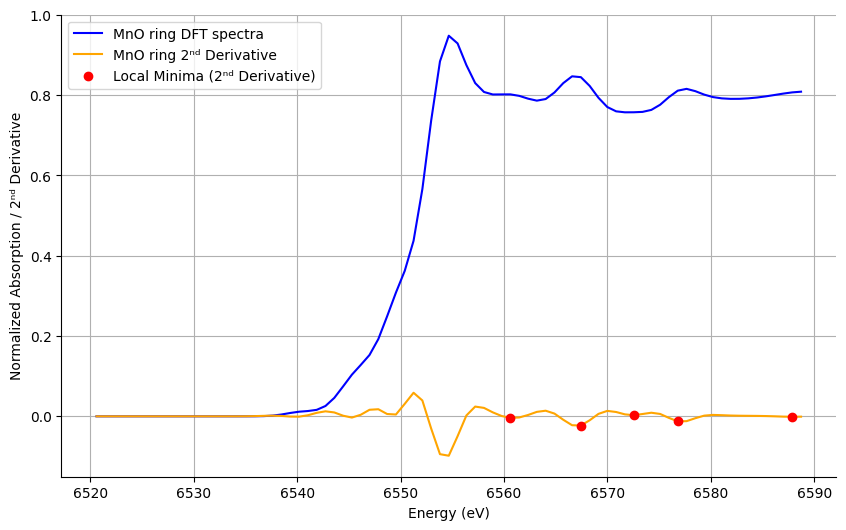

Mn2O3 error level: 0.0342
Mn2O3 error level: 0.0342
Local minima in second derivative (x > white line) for Mn2O3:
  x = 6571.27, y = -0.0114
  x = 6579.07, y = -0.0009


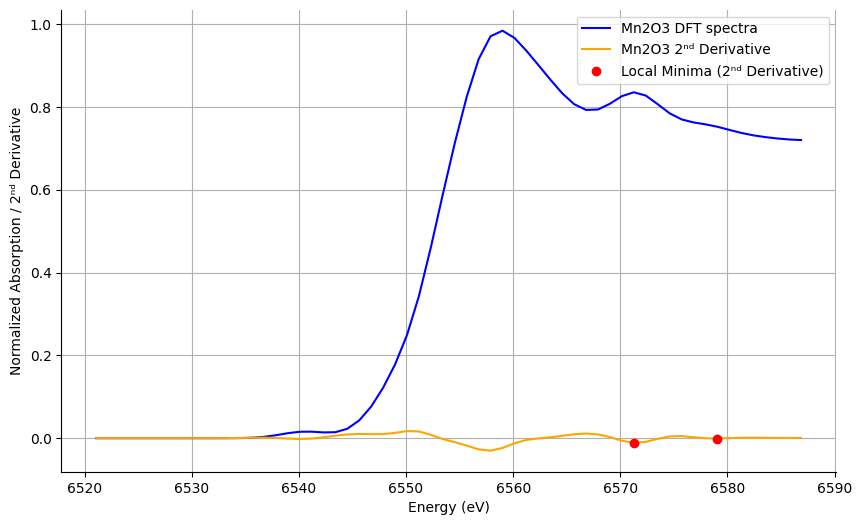

MnO2 error level: 0.0397
MnO2 error level: 0.0397
Local minima in second derivative (x > white line) for MnO2:
  x = 6566.84, y = -0.0055
  x = 6575.95, y = -0.0131
  x = 6583.91, y = 0.0030


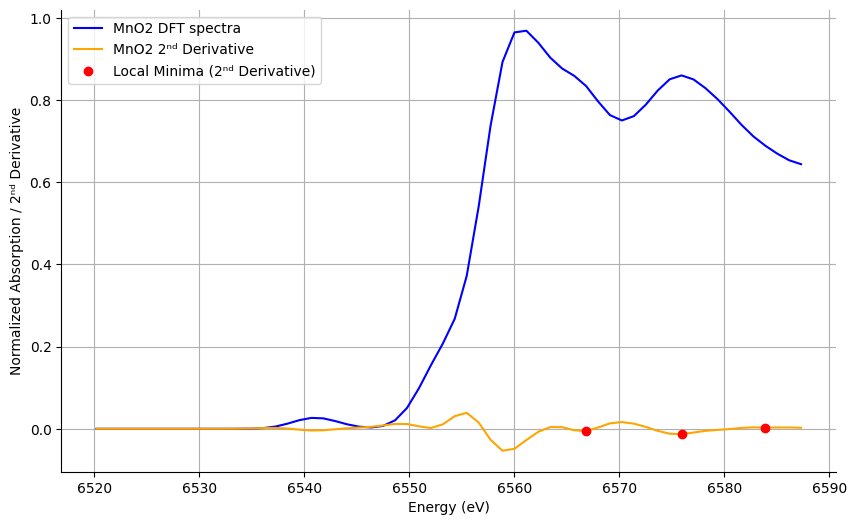

Mn2O7 error level: 0.0424
Mn2O7 error level: 0.0424
Local minima in second derivative (x > white line) for Mn2O7:
  x = 6571.53, y = -0.0171
  x = 6573.02, y = -0.0171
  x = 6584.18, y = -0.0001


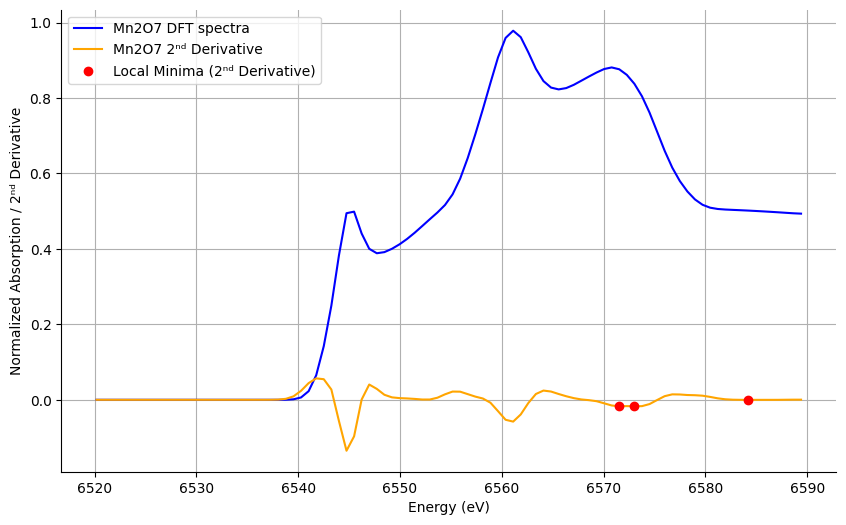

In [1127]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for x > white line
def find_post_white_line_minima(x, y, x_white_line, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    # Calculate the second derivative
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Restrict the search to x > white line
    post_white_line_mask = (x > x_white_line)
    post_white_line_x = x[post_white_line_mask]
    post_white_line_d2y_dx2 = d2y_dx2[post_white_line_mask]
    
    # Find local minima (peaks of -d2y_dx2) in the second derivative for x > white line
    minima_indices, _ = find_peaks(-post_white_line_d2y_dx2)
    local_minima_x = post_white_line_x[minima_indices]
    local_minima_y = post_white_line_d2y_dx2[minima_indices]
    
    # Display the minima x-values and corresponding y-values
    print(f"Local minima in second derivative (x > white line) for {structure_name}:")
    for x_min, y_min in zip(local_minima_x, local_minima_y):
        print(f"  x = {x_min:.2f}, y = {y_min:.4f}")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    # Plot original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    
    # Plot second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    
    # Mark the minima points on the second derivative graph
    plt.scatter(local_minima_x, local_minima_y, color='red', label='Local Minima (2ⁿᵈ Derivative)', zorder=5)
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption / 2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Analysis for each structure
# MnO ring
x_MnO_DFT, y_MnO_DFT = extract_data(MnO_DFT, "MnO")
if x_MnO_DFT is not None and y_MnO_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_DFT, y_MnO_DFT, "MnO ring")

# MnO string
x_Mn2O3_DFT, y_Mn2O3_DFT= extract_data(Mn2O3_DFT, "Mn2O3")
if x_Mn2O3_DFT is not None and y_Mn2O3_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_Mn2O3_DFT, y_Mn2O3_DFT, "Mn2O3")

# OMnO
x_MnO2_DFT, y_MnO2_DFT = extract_data(MnO2_DFT, "MnO2")
if x_MnO2_DFT is not None and y_MnO2_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO2_DFT, y_MnO2_DFT, "MnO2")

# OMnOMnO
x_Mn2O7_DFT, y_Mn2O7_DFT = extract_data(Mn2O7_DFT, "Mn2O7")
if x_Mn2O7_DFT is not None and y_Mn2O7_DFT is not None:
    find_white_line_and_local_maxima_and_minima(x_Mn2O7_DFT, y_Mn2O7_DFT, "Mn2O7")


# Stacking all experimental spectra

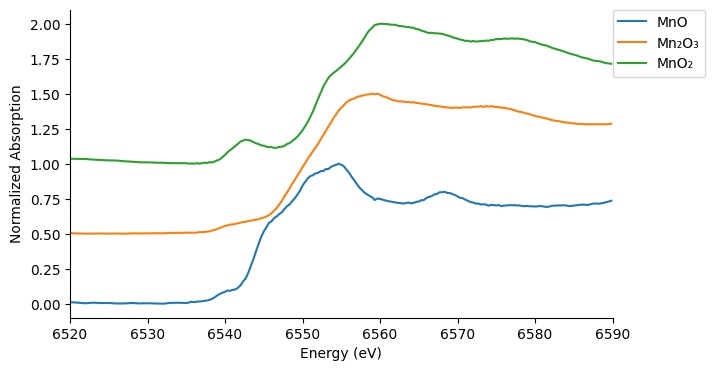

In [1128]:
# Function to plot stacked XANES DFT spectra with upward shift
def plot_stacked_xanes_spectra(dft_data_list, structure_names, shift_value=0.5):
    plt.figure(figsize=(7, 4))  # Set figure size
    
    # Loop over each DFT dataset and apply an upward shift
    for i, (x, y, structure_name) in enumerate(dft_data_list):
        # Apply a shift upwards for each subsequent spectrum
        shifted_y = y + i * shift_value
        
        # Plot the spectrum with a label indicating the structure name
        plt.plot(x, shifted_y, label=f'{structure_name}')
    
    # Customize the plot
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption')
    # plt.title('Stacked XANES experimental Spectra for bulk manganese')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
    plt.xlim(6520, 6590)
    plt.show()
   
# Convert to numpy arrays for plotting
x_MnO = MnO_exp['x'].values
y_MnO = MnO_exp['y'].values

x_Mn2O3 = Mn2O3_exp['x'].values
y_Mn2O3 = Mn2O3_exp['y'].values

x_MnO2 = MnO2_exp['x'].values
y_MnO2 = MnO2_exp['y'].values

# Create a list of tuples with (x, y, structure_name) for each dataset
dft_data_list = [
    (x_MnO, y_MnO, "MnO"),
    (x_Mn2O3, y_Mn2O3, "Mn₂O₃"),
    (x_MnO2, y_MnO2, "MnO₂")
]

# Call the function to plot the stacked spectra with a shift value of 0.5 (you can adjust this)
plot_stacked_xanes_spectra(dft_data_list, ["MnO", "Mn₂O₃", "MnO₂"], shift_value=0.5)


# Stacking all DFT modified spectra

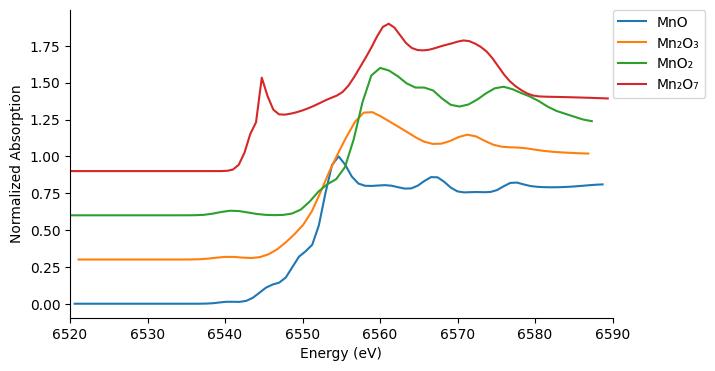

In [1129]:
# Function to plot stacked XANES DFT spectra with upward shift
def plot_stacked_xanes_spectra(dft_data_list, structure_names, shift_value=1):
    plt.figure(figsize=(7, 4))  # Set figure size
    
    # Loop over each DFT dataset and apply an upward shift
    for i, (x, y, structure_name) in enumerate(dft_data_list):
        # Apply a shift upwards for each subsequent spectrum
        shifted_y = y + i * shift_value
        
        # Plot the spectrum with a label indicating the structure name
        plt.plot(x, shifted_y, label=f'{structure_name}')
    
    # Customize the plot
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
    plt.xlim(6520,6590)
    plt.show()

# Example usage with the MnO, Mn2O3, and MnO2 datasets

# Assuming these are pandas DataFrames with 'x' and 'y' columns
# Convert to numpy arrays for plotting
x_MnO = MnO_DFT['Energy (eV)'].values
y_MnO = MnO_DFT['Absorption'].values

x_Mn2O3 = Mn2O3_DFT['Energy (eV)'].values
y_Mn2O3 = Mn2O3_DFT['Absorption'].values

x_MnO2 = MnO2_DFT['Energy (eV)'].values
y_MnO2 = MnO2_DFT['Absorption'].values

x_Mn2O7 = Mn2O7_DFT['Energy (eV)'].values
y_Mn2O7 = Mn2O7_DFT['Absorption'].values

# Create a list of tuples with (x, y, structure_name) for each dataset
dft_data_list = [
    (x_MnO, y_MnO, "MnO"),
    (x_Mn2O3, y_Mn2O3, "Mn₂O₃"),
    (x_MnO2, y_MnO2, "MnO₂"),
    (x_Mn2O7, y_Mn2O7, "Mn₂O₇")
]

# Call the function to plot the stacked spectra with a shift value of 0.5 (you can adjust this)
plot_stacked_xanes_spectra(dft_data_list, ["MnO", "Mn₂O₃", "MnO₂", "Mn₂O₇"], shift_value=0.3)


## **LOADING Co-Mn DATA**

In [1130]:
# Load the data for MnO
MnO_ring = np.loadtxt('MnO_ring_K_edge_updated_CORE_DIELECTRIC_IMAG.dat')
MnO_ring = pd.DataFrame(MnO_ring, columns=['Energy (eV)', 'Absorption'])

MnO_string = np.loadtxt('MnO_string_K_edge_CORE_DIELECTRIC_IMAG.dat')
MnO_string = pd.DataFrame(MnO_string, columns=['Energy (eV)', 'Absorption'])

OMnO_struct = np.loadtxt('MnO2_struct_K_edge_CORE_DIELECTRIC_IMAG.dat')
OMnO_struct = pd.DataFrame(OMnO_struct, columns=['Energy (eV)', 'Absorption'])

OMnOMnO_struct = np.loadtxt('OMnOMnO_struct_K_edge_CORE_DIELECTRIC_IMAG.dat')
OMnOMnO_struct= pd.DataFrame(OMnOMnO_struct, columns=['Energy (eV)', 'Absorption'])


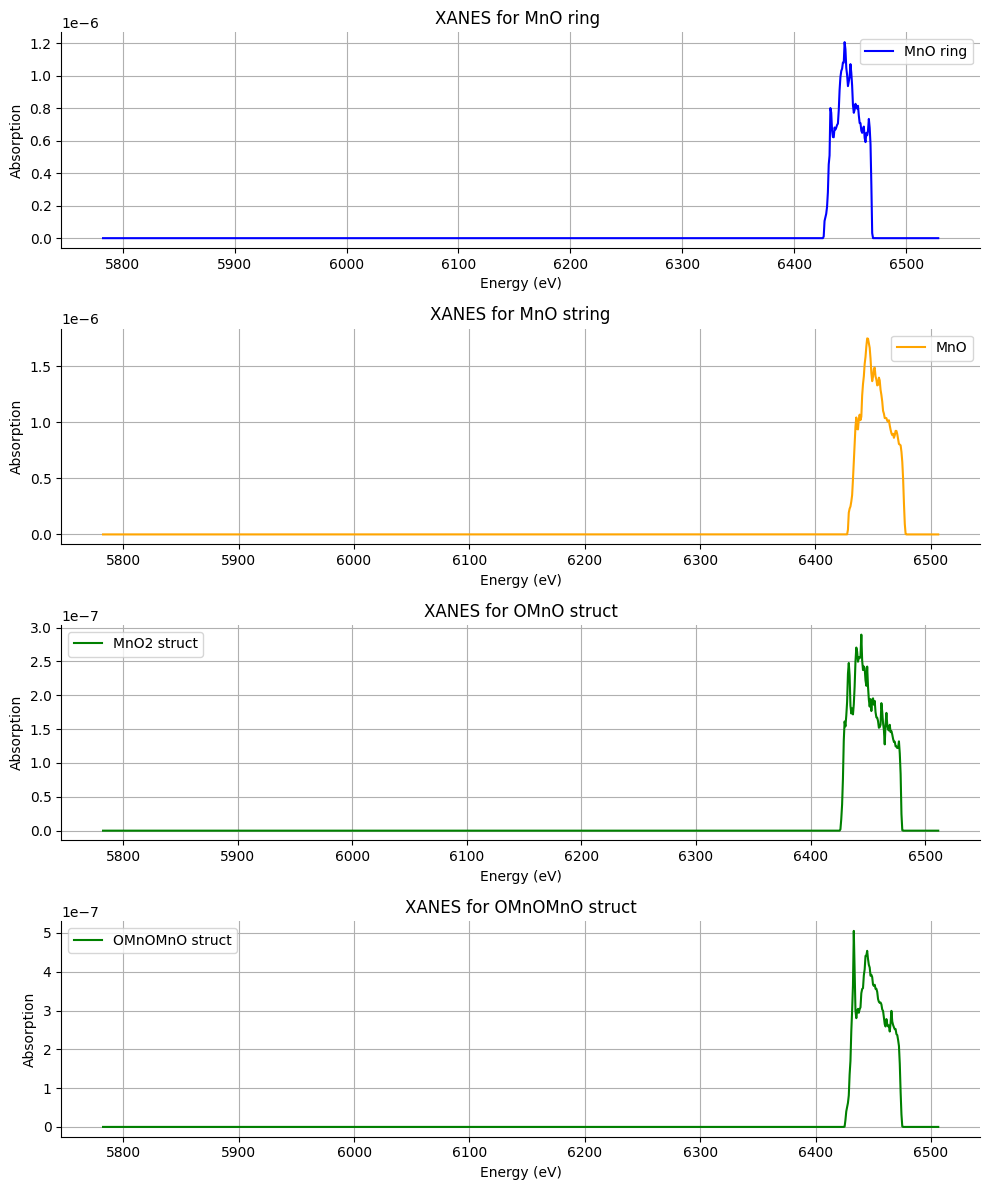

In [1131]:
# Create a figure with three subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))  # 3 rows, 1 column

# Plot for MnO
axs[0].plot(MnO_ring["Energy (eV)"], MnO_ring['Absorption'], color='blue', label='MnO ring')
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Absorption')
axs[0].set_title('XANES for MnO ring ')
axs[0].grid(True)
axs[0].legend()

# Plot for Mn2O3
axs[1].plot(MnO_string["Energy (eV)"], MnO_string['Absorption'], color='orange', label='MnO')
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel('Absorption')
axs[1].set_title('XANES for MnO string')
axs[1].grid(True)
axs[1].legend()

# Plot for MnO2
axs[2].plot(OMnO_struct["Energy (eV)"], OMnO_struct['Absorption'], color='green', label='MnO2 struct')
axs[2].set_xlabel('Energy (eV)')
axs[2].set_ylabel('Absorption')
axs[2].set_title('XANES for OMnO struct')
axs[2].grid(True)
axs[2].legend()

axs[3].plot(OMnOMnO_struct["Energy (eV)"], OMnOMnO_struct['Absorption'], color='green', label='OMnOMnO struct')
axs[3].set_xlabel('Energy (eV)')
axs[3].set_ylabel('Absorption')
axs[3].set_title('XANES for OMnOMnO struct')
axs[3].grid(True)
axs[3].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plots
plt.show()


# Shifting Co-Mn spectra 

In [1132]:
# Locate the index of the maximum Y value for the MnO experimental and DFT data
max_MnO_ring = MnO_ring['Absorption'].idxmax()

# Find the corresponding X values   
MnO_ring_whiteline = 6554
x_MnO_ring = MnO_ring.loc[max_MnO_ring, 'Energy (eV)']
shift_MnO_ring = MnO_ring_whiteline - x_MnO_ring
MnO_ring['Energy (eV)'] += shift_MnO_ring

# Load
max_MnO_string = MnO_string['Absorption'].idxmax()

# Find the corresponding X values
MnO_string_whiteline = 6554
x_MnO_string = MnO_string.loc[max_MnO_string, 'Energy (eV)']
shift_MnO_string = MnO_string_whiteline - x_MnO_string
MnO_string['Energy (eV)'] += shift_MnO_string

# Load
max_OMnO_struct = OMnO_struct['Absorption'].idxmax()

# Find the corresponding X values
OMnO_struct_whiteline = 6554
x_OMnO_struct = OMnO_struct.loc[max_OMnO_struct, 'Energy (eV)']
shift_OMnO_struct = OMnO_struct_whiteline - x_OMnO_struct
OMnO_struct['Energy (eV)'] += shift_OMnO_struct

# Load
max_OMnOMnO_struct = OMnOMnO_struct['Absorption'].idxmax()

# Find the corresponding X values
OMnOMnO_struct_whiteline = 6554
x_OMnOMnO_struct = OMnOMnO_struct.loc[max_OMnOMnO_struct, 'Energy (eV)']
shift_OMnOMnO_struct = OMnOMnO_struct_whiteline - x_OMnOMnO_struct
OMnOMnO_struct['Energy (eV)'] += shift_OMnOMnO_struct

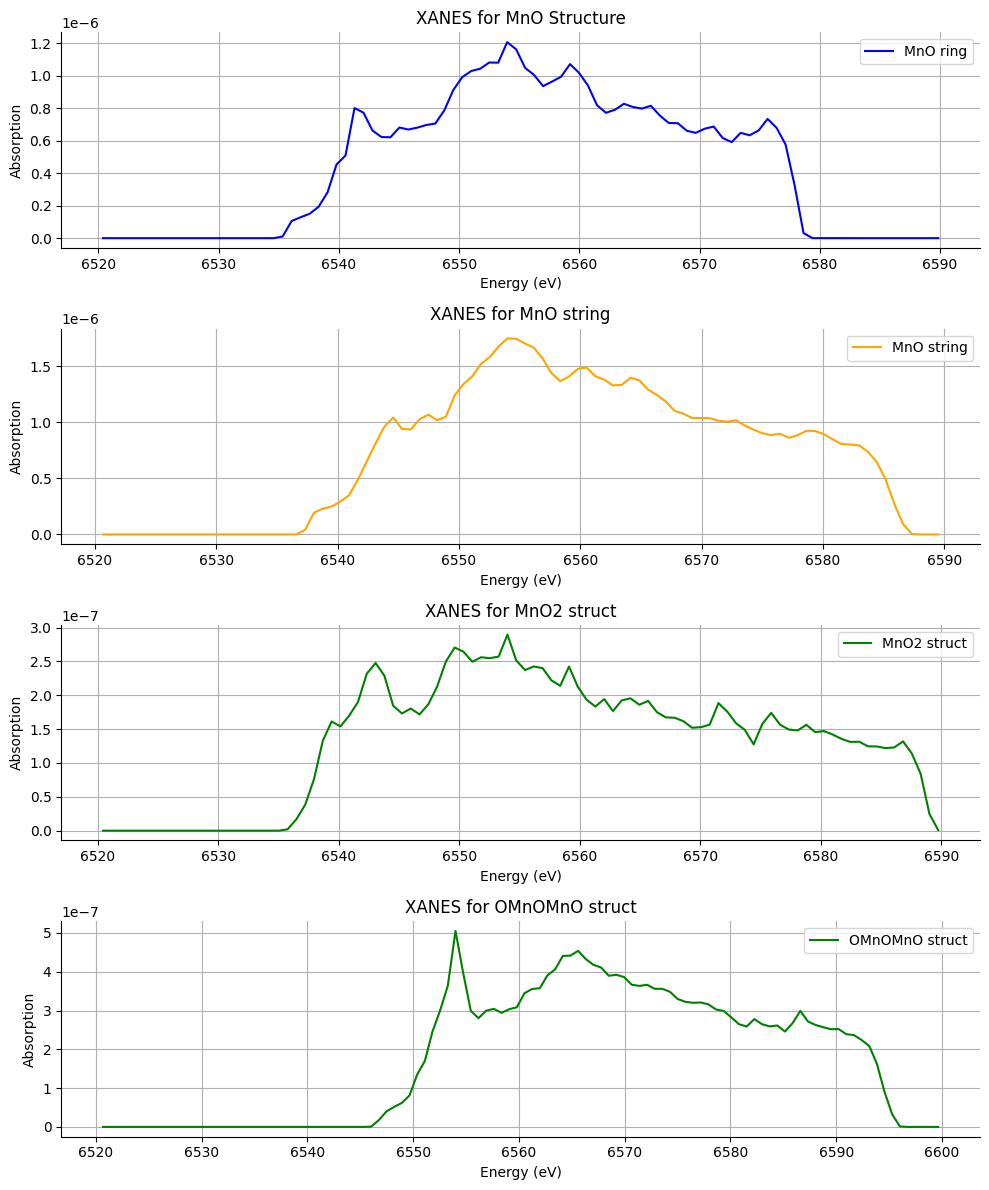

In [1133]:
#Filter the DataFrame to only include rows where Energy >= 6520
MnO_ring = MnO_ring[(MnO_ring["Energy (eV)"] >= 6520) & (MnO_ring["Energy (eV)"] <= 6590)]
MnO_string = MnO_string[(MnO_string["Energy (eV)"] >= 6520) & (MnO_string["Energy (eV)"] <= 6590)]
OMnOMnO_struct = OMnOMnO_struct[(OMnOMnO_struct["Energy (eV)"] >= 6520) & (OMnOMnO_struct["Energy (eV)"] <= 6600)]
OMnO_struct = OMnO_struct[(OMnO_struct["Energy (eV)"] >= 6520) & (OMnO_struct["Energy (eV)"] <= 6590)]

# Create a figure with three subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))  # 3 rows, 1 column

# Plot for MnO
axs[0].plot(MnO_ring["Energy (eV)"], MnO_ring['Absorption'], color='blue', label='MnO ring')
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Absorption')
axs[0].set_title('XANES for MnO Structure')
axs[0].grid(True)
axs[0].legend()

# Plot for Mn2O3
axs[1].plot(MnO_string["Energy (eV)"], MnO_string['Absorption'], color='orange', label='MnO string')
axs[1].set_xlabel('Energy (eV)')
axs[1].set_ylabel('Absorption')
axs[1].set_title('XANES for MnO string')
axs[1].grid(True)
axs[1].legend()

# Plot for MnO2
axs[2].plot(OMnO_struct["Energy (eV)"], OMnO_struct['Absorption'], color='green', label='MnO2 struct')
axs[2].set_xlabel('Energy (eV)')
axs[2].set_ylabel('Absorption')
axs[2].set_title('XANES for MnO2 struct')
axs[2].grid(True)
axs[2].legend()

axs[3].plot(OMnOMnO_struct["Energy (eV)"], OMnOMnO_struct['Absorption'], color='green', label='OMnOMnO struct')
axs[3].set_xlabel('Energy (eV)')
axs[3].set_ylabel('Absorption')
axs[3].set_title('XANES for OMnOMnO struct')
axs[3].grid(True)
axs[3].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plots
plt.show()


# Applying optimised parameters to Co-Mn data

Mn2O7 White Line (Energy): 6554.0 eV


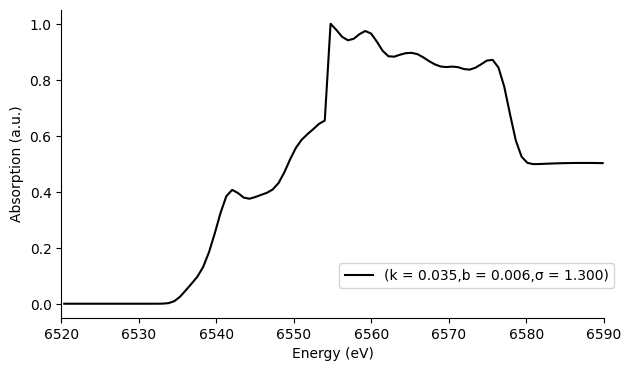

Mn2O7 White Line (Energy): 6554.0 eV


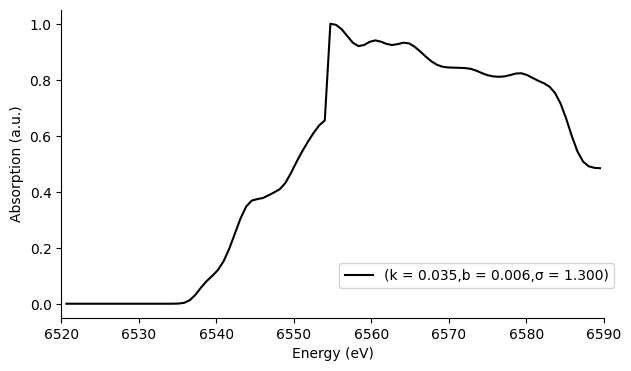

Mn2O7 White Line (Energy): 6554.0 eV


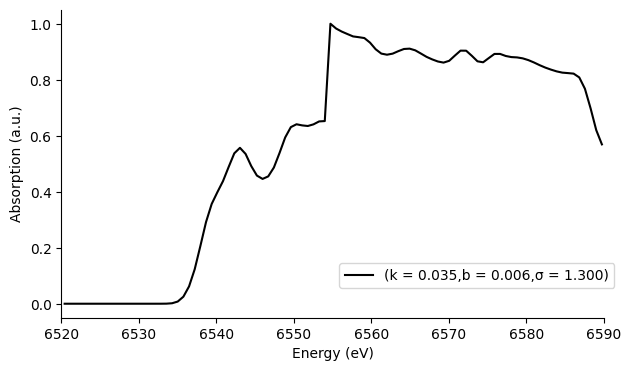

Mn2O7 White Line (Energy): 6554.0 eV


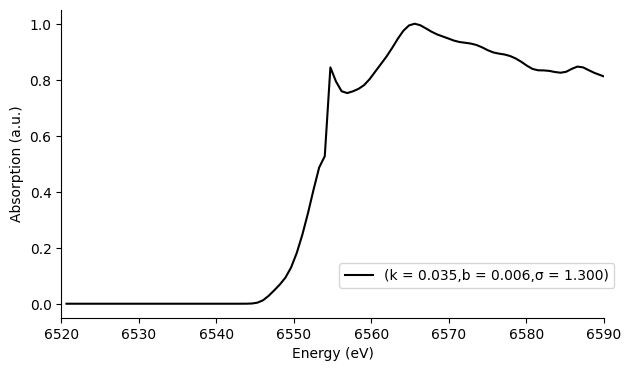

In [1134]:
# Function for applying Gaussian broadening
def apply_gaussian_broadening(y_dft, sigma):
    return gaussian_filter1d(y_dft, sigma)

# Heaviside step function for K optimization
def expression(E, K, white_line,b):
    return 0.5 + 0.5 * np.tanh(K * (E - white_line))-b*(E-white_line)

# Apply Heaviside and Gaussian broadening with average K and sigma
def apply_broadening_to_Co_Mn(dft_df, K_avg, sigma_avg,b_avg):
    x_dft = dft_df['Energy (eV)'].values
    y_dft = dft_df['Absorption'].values
    
    y_dft = y_dft/np.max(y_dft)
    # Find the white line (energy corresponding to maximum absorption in DFT data)
    white_line = x_dft[np.argmax(y_dft)]
    print(f"Mn2O7 White Line (Energy): {white_line} eV")

    # Apply Gaussian broadening
    y_dft_broadened = apply_gaussian_broadening(y_dft, sigma_avg)

    # Apply Heaviside values above the white line
    heaviside_values = expression(x_dft, K_avg, white_line,b_avg)

    # Modify only the values above the white line
    modified_y_dft = np.copy(y_dft_broadened)
    modified_y_dft[x_dft > white_line] += heaviside_values[x_dft > white_line]

    # Normalize the modified DFT absorption data
    renormalized_y_dft = modified_y_dft / np.max(modified_y_dft)
    
    # Plot the modified DFT data
    plt.figure(figsize=(7, 4))
    plt.plot(x_dft, renormalized_y_dft, label=f'(k = {K_avg:.3f},b = {b_avg:.3f},σ = {sigma_avg:.3f})', color='black')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.)')
    plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.2))
    plt.xlim(6520,6590)
    plt.show()

    # Save the renormalized data back into the DataFrame
    dft_df['Absorption'] = renormalized_y_dft

# Compute average K and sigma from previous results
K_avg = (0.011+0.056+0.037) / 3  # Replace these values with actual optimized K values
sigma_avg = (1.3 + 1.3 + 1.3) / 3  # Replace these values with actual optimized sigma values
b_avg = (0+0.006+0.011)/3        # Replace these values with actual optimized b values
# Apply the broadening to Mn2O7 DFT data
apply_broadening_to_Co_Mn(MnO_ring, K_avg, sigma_avg,b_avg)
apply_broadening_to_Co_Mn(MnO_string, K_avg, sigma_avg,b_avg)
apply_broadening_to_Co_Mn(OMnO_struct, K_avg, sigma_avg,b_avg)
apply_broadening_to_Co_Mn(OMnOMnO_struct, K_avg, sigma_avg,b_avg)

In [1135]:
# Load
max_OMnOMnO_struct = OMnOMnO_struct['Absorption'].idxmax()

# Find the corresponding X values
OMnOMnO_struct_whiteline = 6554
x_OMnOMnO_struct = OMnOMnO_struct.loc[max_OMnOMnO_struct, 'Energy (eV)']
shift_OMnOMnO_struct = OMnOMnO_struct_whiteline - x_OMnOMnO_struct
OMnOMnO_struct['Energy (eV)'] += shift_OMnOMnO_struct

# **Extract pre-edge of Co-Mn**

MnO ring error level: 0.0465
Minimum in pre-edge region for MnO ring:
  Minimum: x = 6541.30, y = 0.3843


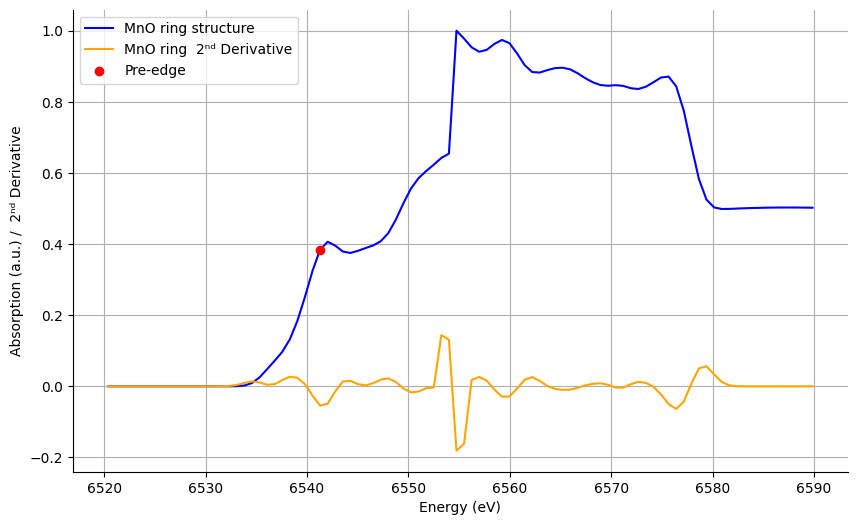

MnO_ string error level: 0.0439
Minimum in pre-edge region for MnO_ string:
  Minimum: x = 6543.85, y = 0.3468


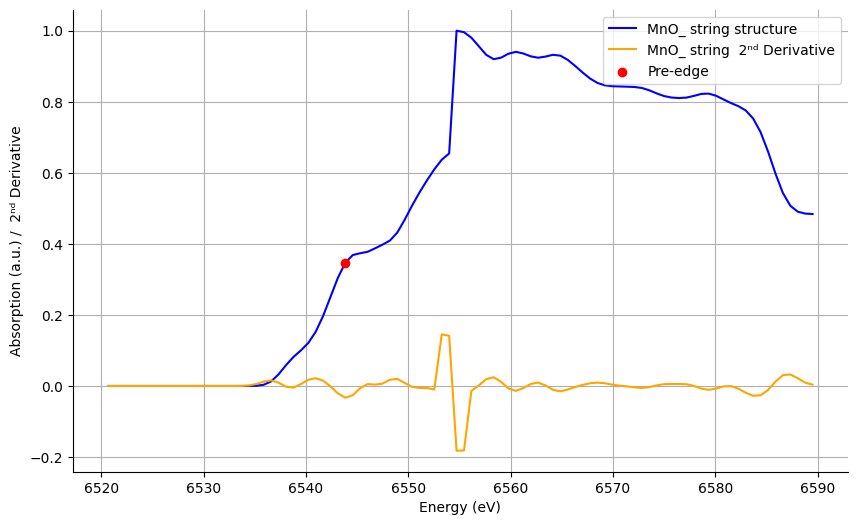

OMnO struct error level: 0.0478
Minimum in pre-edge region for OMnO struct:
  Minimum: x = 6543.05, y = 0.5568


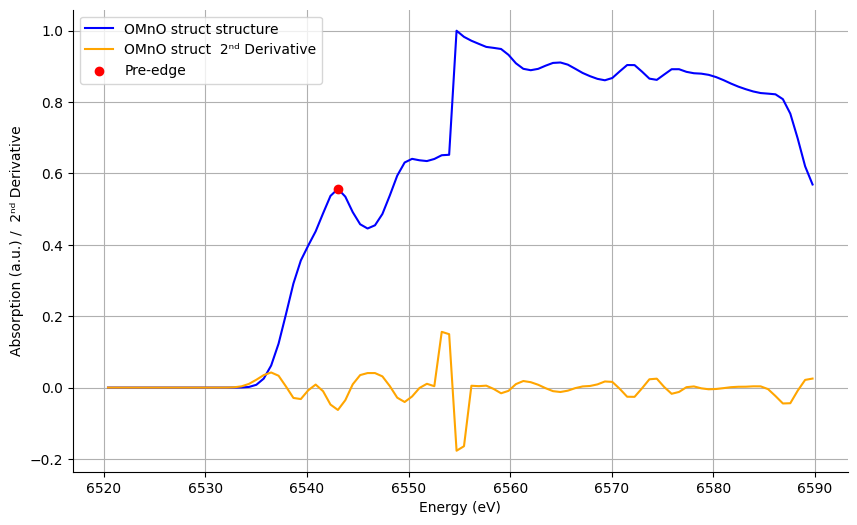

In [1136]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first derivative (dy/dx)
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    # Compute the second derivative (d²y/dx²)
    d2y_dx2 = np.gradient(dy_dx, x)

    # Restrict to pre-edge region (before E₀)
    pre_edge_mask = (x < E0)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    
    # Find the true minimum points in the pre-edge region of the second derivative
    min_index = np.argmin(pre_edge_d2y_dx2)  # Index of the absolute minimum
    x_min = pre_edge_x[min_index]
    y_min = y[pre_edge_mask][min_index]
    
    # Display the minimum x and y values
    print(f"Minimum in pre-edge region for {structure_name}:")
    print(f"  Minimum: x = {x_min:.2f}, y = {y_min:.4f}")

    # Plot the original data, the second derivative, and the minimum point
    plt.figure(figsize=(10, 6))
    
    # Plot the original spectrum
    plt.plot(x, y, label=f'{structure_name} structure', color='blue')
    
    # Plot the second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name}  2ⁿᵈ Derivative', color='orange')
    
    # Mark the minimum point
    plt.scatter(x_min, y_min, color='red', label='Pre-edge', zorder=5)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Absorption (a.u.) /  2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

x_MnO_ring = MnO_ring['Energy (eV)'].values
y_MnO_ring = MnO_ring['Absorption'].values
E0_MnO_ring, _ = calculate_E0(x_MnO_ring, y_MnO_ring)
find_pre_edge_minima(x_MnO_ring, y_MnO_ring, E0_MnO_ring, "MnO ring")

# Mn2O3
x_MnO_string = MnO_string['Energy (eV)'].values
y_MnO_string = MnO_string['Absorption'].values
E0_MnO_string, _ = calculate_E0(x_MnO_string, y_MnO_string)
find_pre_edge_minima(x_MnO_string, y_MnO_string, E0_MnO_string, "MnO_ string")

# MnO2
x_OMnO_struct = OMnO_struct['Energy (eV)'].values
y_OMnO_struct = OMnO_struct['Absorption'].values
E0_OMnO_struct, _ = calculate_E0(x_OMnO_struct, y_OMnO_struct)
find_pre_edge_minima(x_OMnO_struct, y_OMnO_struct, E0_OMnO_struct, "OMnO struct")


# **Extracting E₀**

MnO ring error level: 0.0465
Local maxima in first derivative (x < white-line): [6539.80751462 6549.51816251]


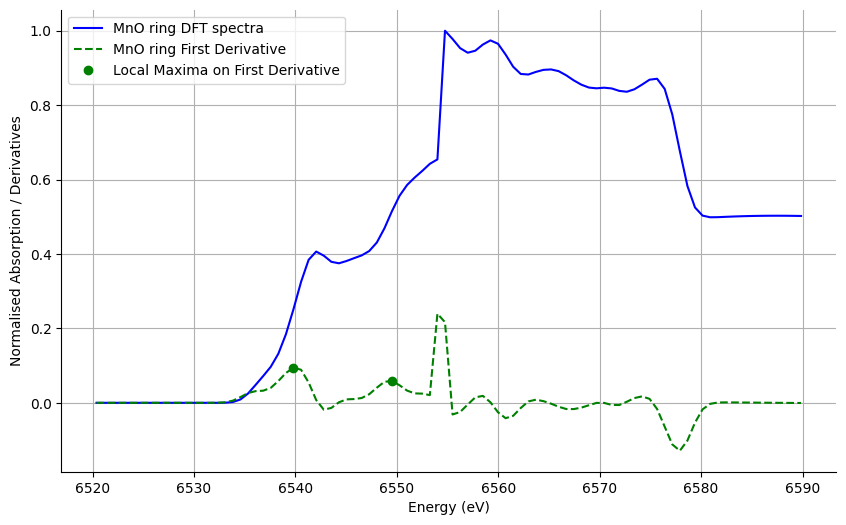

MnO string error level: 0.0439
Local maxima in first derivative (x < white-line): [6538.05671385 6542.4048828  6550.37652588]


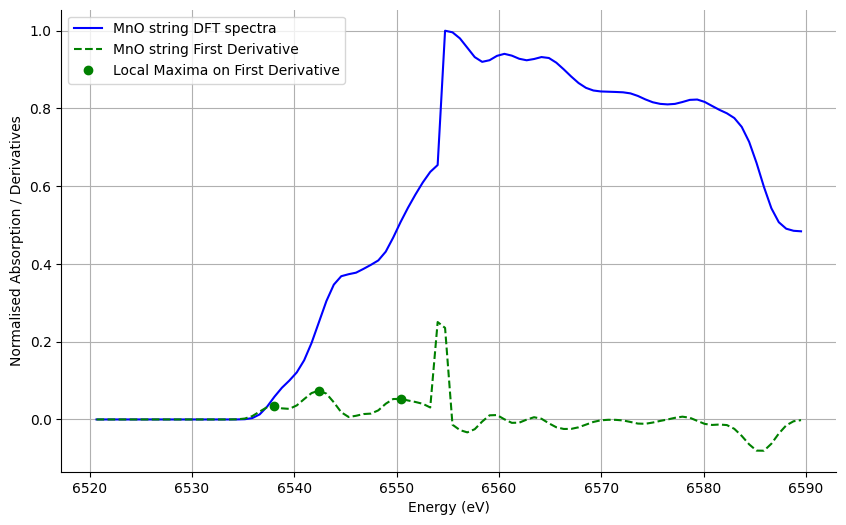

OMnO error level: 0.0478
Local maxima in first derivative (x < white-line): [6537.94574298 6541.59443776 6548.16208836 6552.54052209]


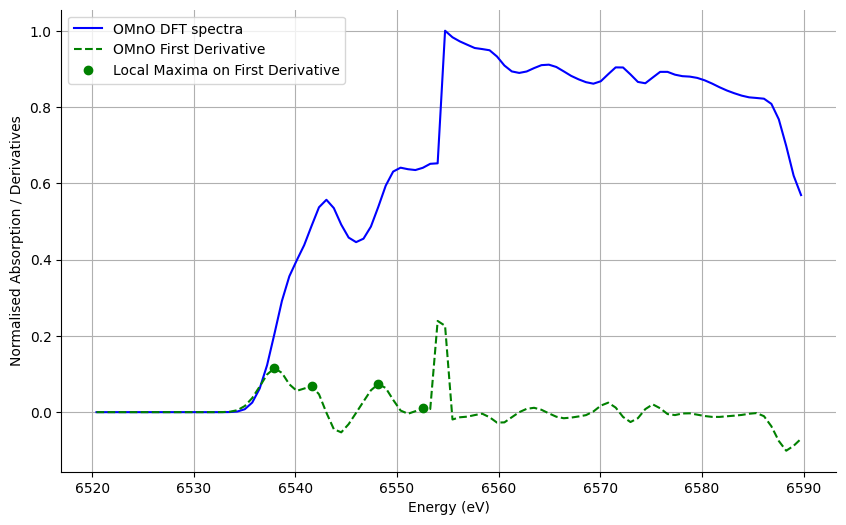

OMnOMnO error level: 0.0422
Local maxima in first derivative (x < white-line): [6540.95785741 6542.40698436 6548.92805566 6551.10174609]


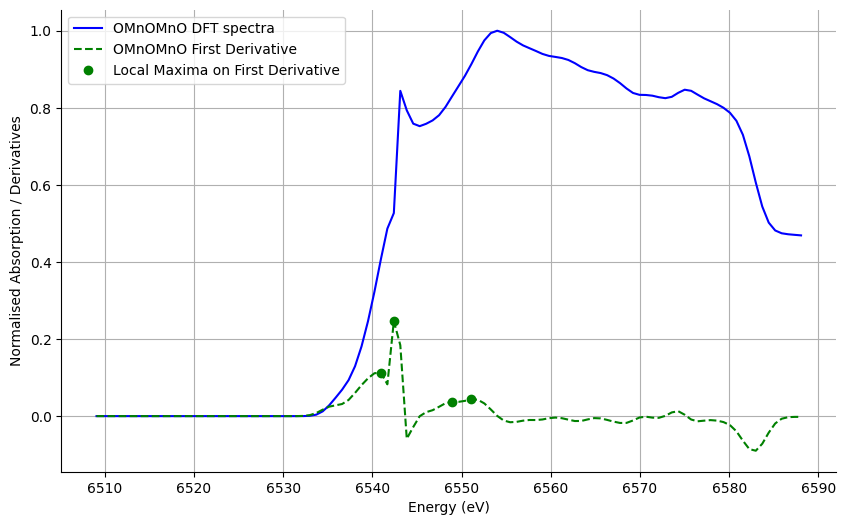

In [1137]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for the pre-edge region
def find_pre_edge_minima(x, y, E0, structure_name):
    # Compute the first and second derivatives
    dy_dx = np.gradient(y, x)
    d2y_dx2 = np.gradient(dy_dx, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    
    # Restrict to pre-edge region (before E₀)
    pre_edge_mask = (x < E0)
    pre_edge_x = x[pre_edge_mask]
    pre_edge_d2y_dx2 = d2y_dx2[pre_edge_mask]
    
    # Check if pre-edge region has values
    if len(pre_edge_x) == 0 or len(pre_edge_d2y_dx2) == 0:
        print(f"Warning: No data points found in pre-edge region for {structure_name}.")
        return
    
    # Find the true minimum point in the pre-edge region of the second derivative
    min_index = np.argmin(pre_edge_d2y_dx2)
    x_min = pre_edge_x[min_index]
    y_min = y[pre_edge_mask][min_index]
    
    # Find local maxima in the first derivative before the white-line
    abs_max_index = y.argmax()
    x_abs_max = x[abs_max_index]
    mask = x < x_abs_max
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]
    peaks, _ = find_peaks(dy_dx_below_white_line)
    local_maxima_x = x_below_white_line[peaks]
    local_maxima_y = dy_dx_below_white_line[peaks]
    
    # Print the x-values of local maxima in the first derivative before the white-line
    print("Local maxima in first derivative (x < white-line):", local_maxima_x)

    # Plot everything on a single plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    plt.plot(x, dy_dx, label=f'{structure_name} First Derivative', linestyle='--', color='green')
    plt.plot(local_maxima_x, local_maxima_y, 'go', label='Local Maxima on First Derivative')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption / Derivatives')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Select the columns of interest for each structure
# MnO
x_MnO_ring, y_MnO_ring = extract_data(MnO_ring, "MnO ring")
if x_MnO_ring is not None and y_MnO_ring is not None:
    E0_MnO_ring, dy_dx_MnO_ring = calculate_E0(x_MnO_ring, y_MnO_ring)
    find_pre_edge_minima(x_MnO_ring, y_MnO_ring, E0_MnO_ring, "MnO ring")
# MnO string
x_MnO_string, y_MnO_string = extract_data(MnO_string, "MnO string")
if x_MnO_string is not None and y_MnO_string is not None:
    E0_MnO_string, dy_dx_MnO_string = calculate_E0(x_MnO_string, y_MnO_string)
    find_pre_edge_minima(x_MnO_string, y_MnO_string, E0_MnO_string, "MnO string")
# OMnO
x_OMnO_struct, y_OMnO_struct = extract_data(OMnO_struct, "OMnO")
if x_OMnO_struct is not None and y_OMnO_struct is not None:
    E0_OMnO_struct, dy_dx_OMnO_struct = calculate_E0(x_OMnO_struct, y_OMnO_struct)
    find_pre_edge_minima(x_OMnO_struct, y_OMnO_struct, E0_OMnO_struct, "OMnO")
# OMnOMnO
x_OMnOMnO_struct, y_OMnOMnO_struct = extract_data(OMnOMnO_struct, "OMnOMnO")
if x_OMnOMnO_struct is not None and y_OMnOMnO_struct is not None:
    E0_OMnOMnO_struct, dy_dx_OMnOMnO_structt = calculate_E0(x_OMnOMnO_struct, y_OMnOMnO_struct)
    find_pre_edge_minima(x_OMnOMnO_struct, y_OMnOMnO_struct, E0_OMnOMnO_struct, "OMnOMnO")


# **Extract white line**

white line is at: 6554.746972914941


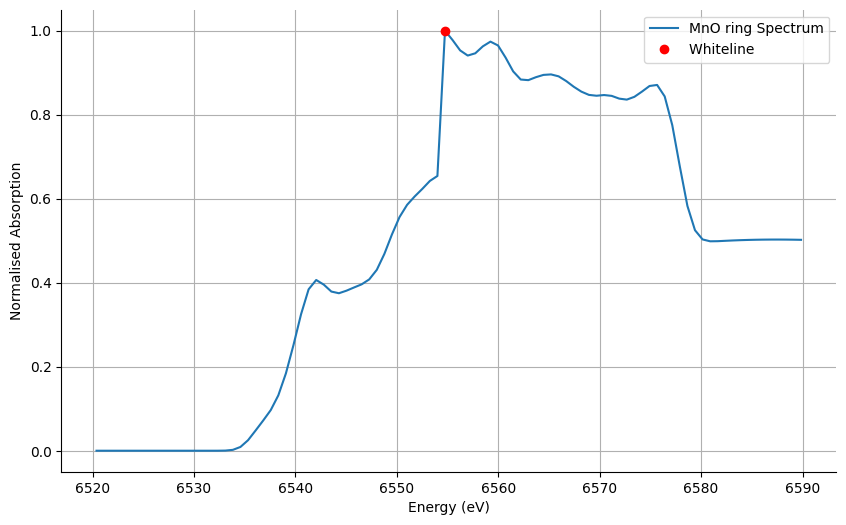

white line is at: 6554.72469482497


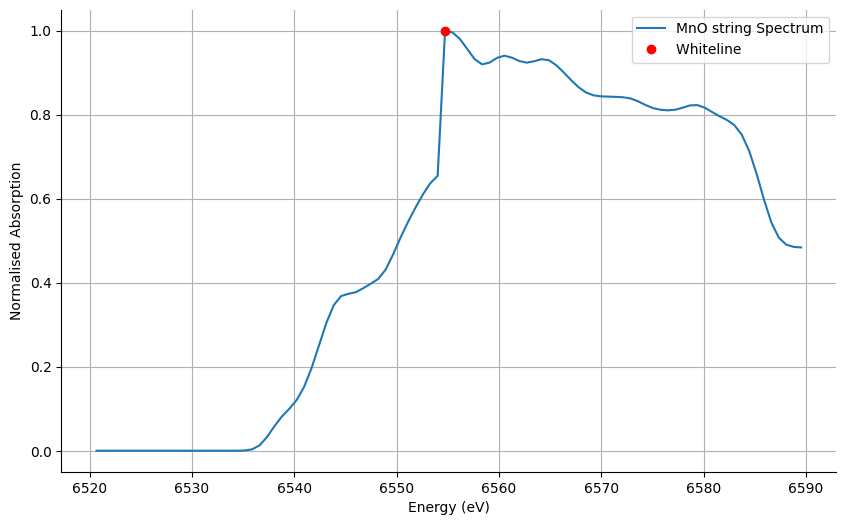

white line is at: 6554.729738955422


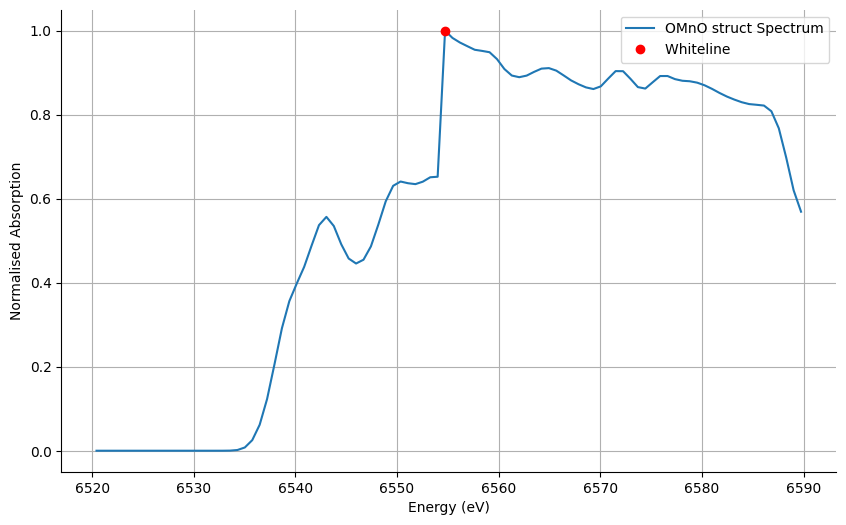

white line is at: 6554.0


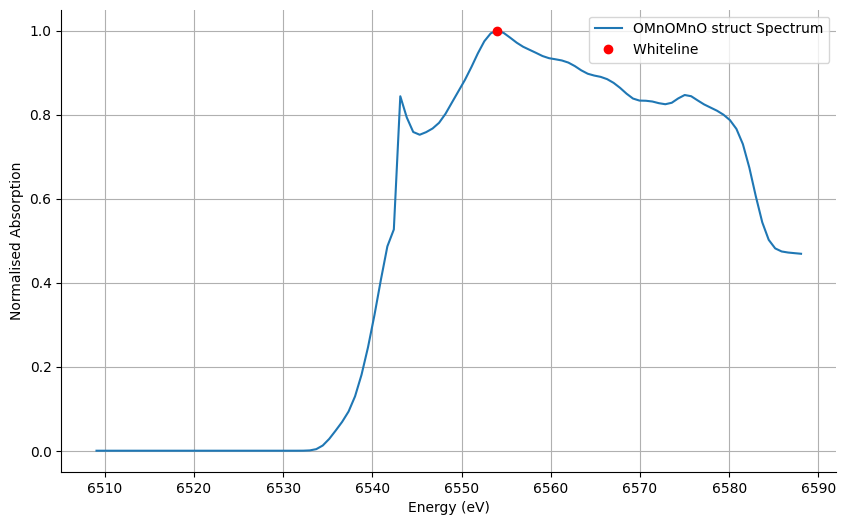

In [1138]:
# Function to plot spectra and mark the absolute maximum (whiteline)
def plot_spectrum_with_whiteline(data, structure_name):
    x = data['Energy (eV)']
    y = data['Absorption']

    # Find the index of the absolute maximum in the y column
    abs_max_index = y.idxmax()
    # Get the corresponding x and y values for the whiteline
    x_abs_max = x[abs_max_index]
    y_abs_max = y[abs_max_index]
    print(f'white line is at: {x_abs_max}')

    # Plot the spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} Spectrum')
    plt.plot(x_abs_max, y_abs_max, 'ro', label='Whiteline ')  
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalised Absorption')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot each spectrum with whiteline marked
plot_spectrum_with_whiteline(MnO_ring, "MnO ring")
plot_spectrum_with_whiteline(MnO_string, "MnO string")
plot_spectrum_with_whiteline(OMnO_struct, "OMnO struct")
plot_spectrum_with_whiteline(OMnOMnO_struct, "OMnOMnO struct")


# **FIRST POST-EDGE MAXIMUM**

MnO ring error level: 0.0465
Local minima in second derivative (x > white line) for MnO ring:
  x = 6559.23, y = -0.0295
  x = 6565.20, y = -0.0101
  x = 6571.18, y = -0.0039
  x = 6576.41, y = -0.0637
  x = 6584.63, y = -0.0002


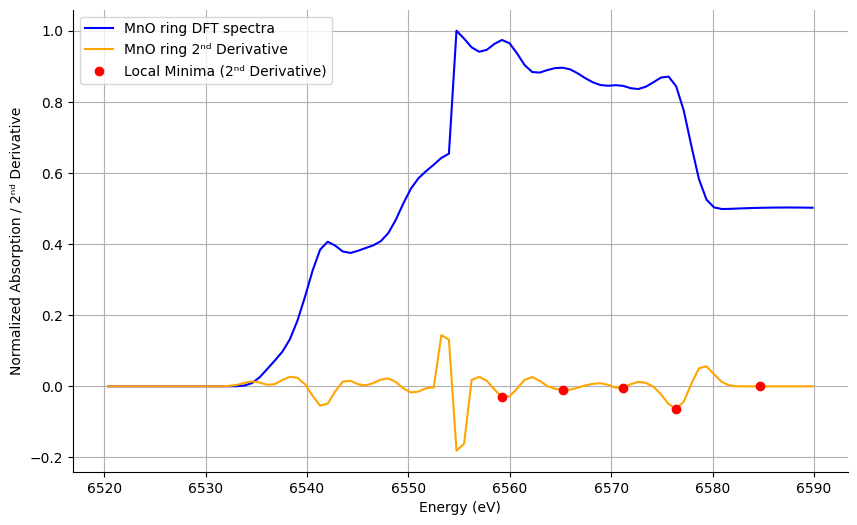

MnO string error level: 0.0439
Local minima in second derivative (x > white line) for MnO string:
  x = 6560.52, y = -0.0138
  x = 6564.87, y = -0.0151
  x = 6572.84, y = -0.0056
  x = 6579.36, y = -0.0109
  x = 6583.71, y = -0.0275


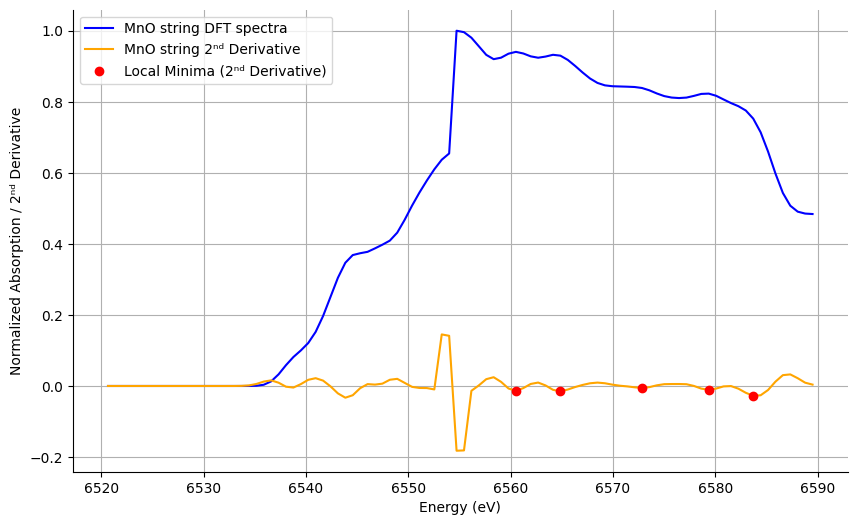

OMnO error level: 0.0478
Local minima in second derivative (x > white line) for OMnO:
  x = 6556.92, y = 0.0039
  x = 6559.11, y = -0.0160
  x = 6564.95, y = -0.0124
  x = 6572.24, y = -0.0260
  x = 6575.89, y = -0.0175
  x = 6579.54, y = -0.0048
  x = 6586.84, y = -0.0446


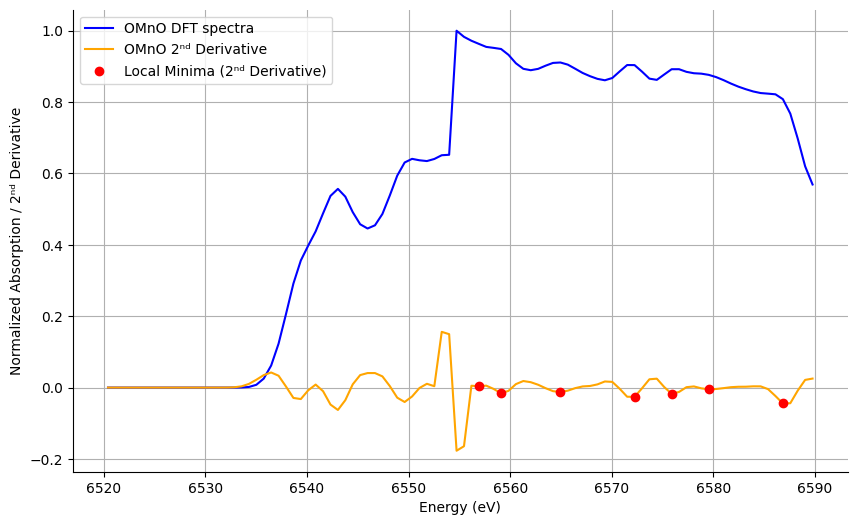

OMnOMnO error level: 0.0422
Local minima in second derivative (x > white line) for OMnOMnO:
  x = 6558.35, y = 0.0009
  x = 6561.97, y = -0.0051
  x = 6566.32, y = -0.0058
  x = 6571.39, y = -0.0020
  x = 6575.01, y = -0.0149
  x = 6581.53, y = -0.0319


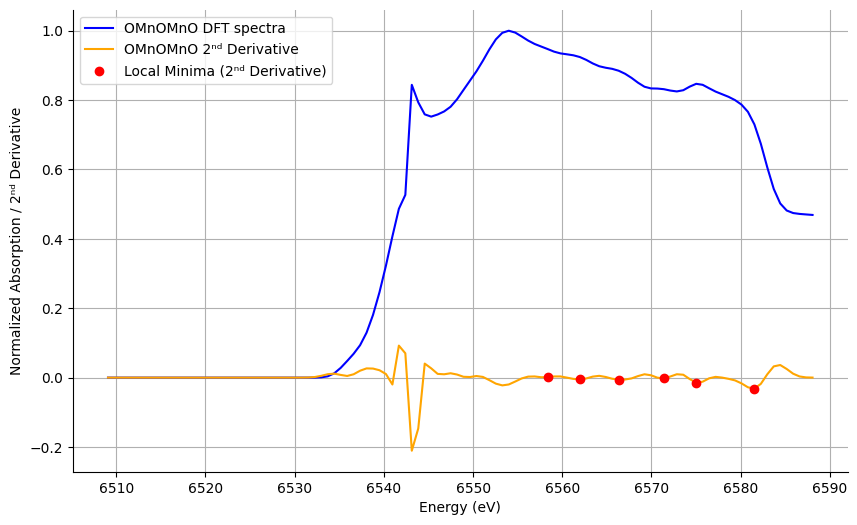

In [1139]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the energy corresponding to the maximum derivative (E₀)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    
    return E0, dy_dx

# Function to find minima based on the second derivative for x > white line
def find_post_white_line_minima(x, y, x_white_line, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    noise_level = np.std(dy_dx)

    print(f'{structure_name} error level: {noise_level:.4f}')
    # Calculate the second derivative
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Restrict the search to x > white line
    post_white_line_mask = (x > x_white_line)
    post_white_line_x = x[post_white_line_mask]
    post_white_line_d2y_dx2 = d2y_dx2[post_white_line_mask]
    
    # Find local minima (peaks of -d2y_dx2) in the second derivative for x > white line
    minima_indices, _ = find_peaks(-post_white_line_d2y_dx2)
    local_minima_x = post_white_line_x[minima_indices]
    local_minima_y = post_white_line_d2y_dx2[minima_indices]
    
    # Display the minima x-values and corresponding y-values
    print(f"Local minima in second derivative (x > white line) for {structure_name}:")
    for x_min, y_min in zip(local_minima_x, local_minima_y):
        print(f"  x = {x_min:.2f}, y = {y_min:.4f}")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    # Plot original spectrum
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    
    # Plot second derivative
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    
    # Mark the minima points on the second derivative graph
    plt.scatter(local_minima_x, local_minima_y, color='red', label='Local Minima (2ⁿᵈ Derivative)', zorder=5)
    
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption / 2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to find the white-line and local maxima in the first derivative
def find_white_line_and_local_maxima_and_minima(x, y, structure_name):
    # Calculate the first derivative
    dy_dx = np.gradient(y, x)
    
    # Find the white-line maximum in the original spectrum
    abs_max_index = y.argmax()
    x_white_line = x[abs_max_index]
    y_white_line = y[abs_max_index]
   
    # Restrict to x < white line for local maxima in first derivative
    mask = x < x_white_line
    x_below_white_line = x[mask]
    dy_dx_below_white_line = dy_dx[mask]
    
    # Find local maxima in the first derivative where x < white line
    peaks, _ = find_peaks(dy_dx_below_white_line)
    local_maxima_x = x_below_white_line[peaks]
        
    # Call function to find local minima in second derivative where x > white line
    find_post_white_line_minima(x, y, x_white_line, structure_name)

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Analysis for each structure
# MnO ring
x_MnO_ring, y_MnO_ring = extract_data(MnO_ring, "MnO ring")
if x_MnO_ring is not None and y_MnO_ring is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_ring, y_MnO_ring, "MnO ring")

# MnO string
x_MnO_string, y_MnO_string = extract_data(MnO_string, "MnO string")
if x_MnO_string is not None and y_MnO_string is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_string, y_MnO_string, "MnO string")

# OMnO
x_OMnO_struct, y_OMnO_struct = extract_data(OMnO_struct, "OMnO")
if x_OMnO_struct is not None and y_OMnO_struct is not None:
    find_white_line_and_local_maxima_and_minima(x_OMnO_struct, y_OMnO_struct, "OMnO")

# OMnOMnO
x_OMnOMnO_struct, y_OMnOMnO_struct = extract_data(OMnOMnO_struct, "OMnOMnO")
if x_OMnOMnO_struct is not None and y_OMnOMnO_struct is not None:
    find_white_line_and_local_maxima_and_minima(x_OMnOMnO_struct, y_OMnOMnO_struct, "OMnOMnO")


# **EXTRACT SHOULDERS**

Local minima in second derivative (x < white line) for MnO ring:
  x = 6536.07, y = 0.0042
  x = 6541.30, y = -0.0545
  x = 6545.78, y = 0.0024
  x = 6550.27, y = -0.0173


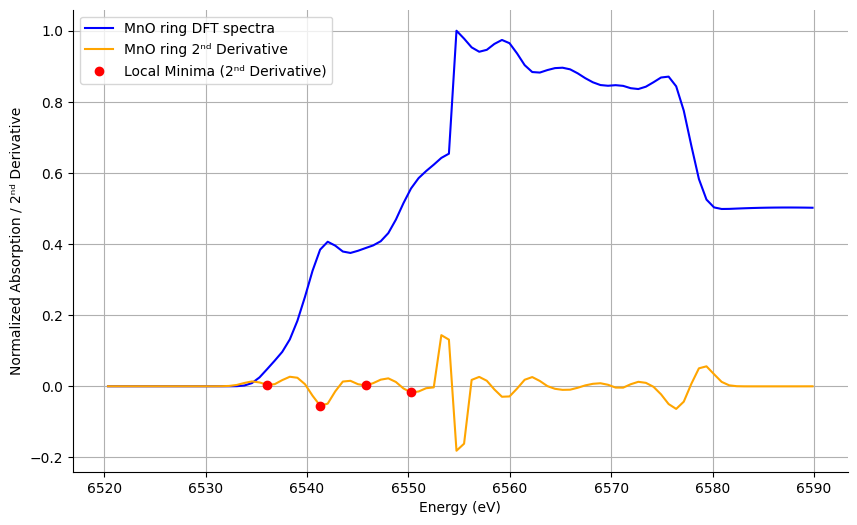

Local minima in second derivative (x < white line) for MnO string:
  x = 6538.78, y = -0.0044
  x = 6543.85, y = -0.0330
  x = 6546.75, y = 0.0038
  x = 6552.55, y = -0.0097


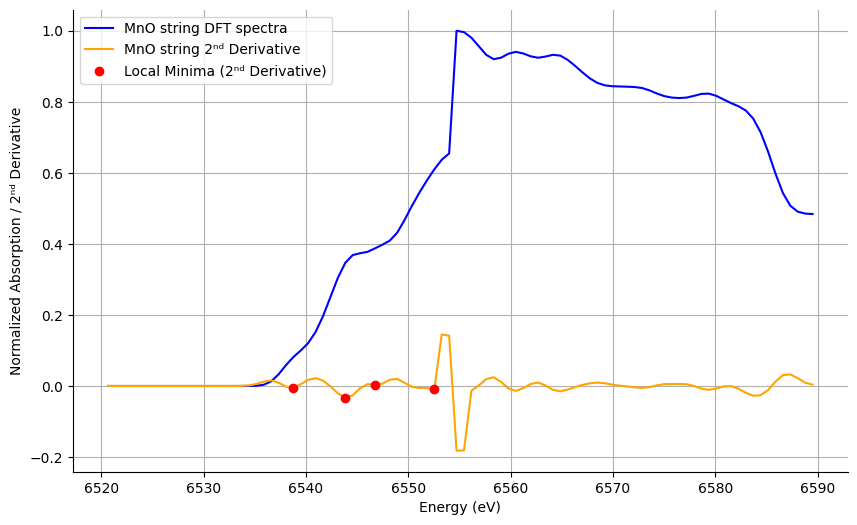

Local minima in second derivative (x < white line) for OMnO:
  x = 6539.41, y = -0.0322
  x = 6543.05, y = -0.0628
  x = 6549.62, y = -0.0404
  x = 6552.54, y = 0.0038


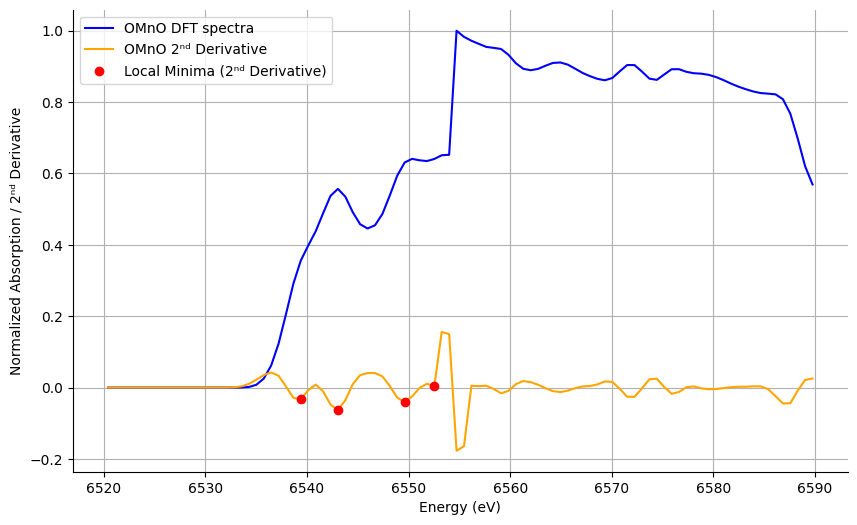

Local minima in second derivative (x < white line) for OMnOMnO:
  x = 6535.89, y = 0.0047
  x = 6540.96, y = -0.0198
  x = 6543.13, y = -0.2108
  x = 6546.75, y = 0.0096
  x = 6549.65, y = 0.0017


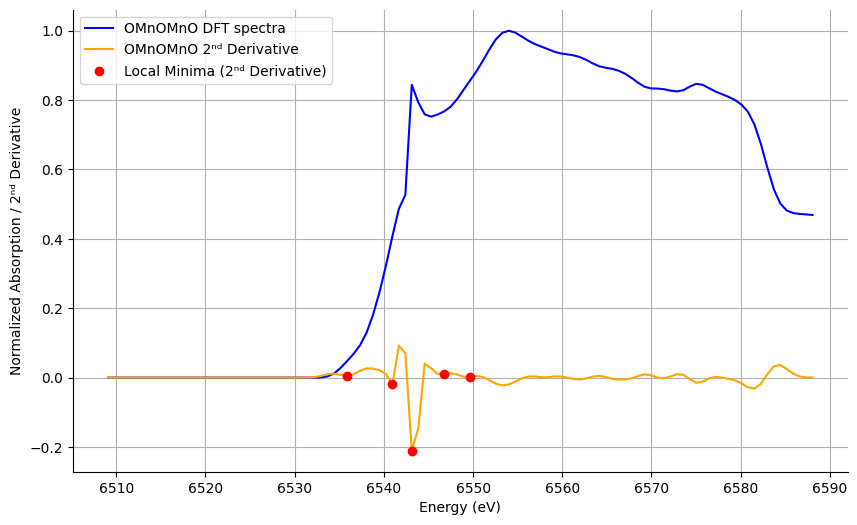

In [1140]:
# Polynomial function (for fitting)
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Function to calculate E₀ from the maximum of the first derivative
def calculate_E0(x, y):
    dy_dx = np.gradient(y, x)
    E0_index = np.argmax(dy_dx)
    E0 = x[E0_index]
    return E0, dy_dx

# Function to find minima in the second derivative for values below the white line
def find_pre_white_line_minima(x, y, x_white_line, structure_name):
    # Calculate first and second derivatives
    dy_dx = np.gradient(y, x)
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Restrict the data to x < white line
    pre_white_line_mask = (x < x_white_line)
    pre_white_line_x = x[pre_white_line_mask]
    pre_white_line_d2y_dx2 = d2y_dx2[pre_white_line_mask]
    
    # Find local minima (negative peaks in d2y_dx2) for x < white line
    minima_indices, _ = find_peaks(-pre_white_line_d2y_dx2)
    local_minima_x = pre_white_line_x[minima_indices]
    local_minima_y = pre_white_line_d2y_dx2[minima_indices]
    
    # Print minima values
    print(f"Local minima in second derivative (x < white line) for {structure_name}:")
    for x_min, y_min in zip(local_minima_x, local_minima_y):
        print(f"  x = {x_min:.2f}, y = {y_min:.4f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label=f'{structure_name} DFT spectra', color='blue')
    plt.plot(x, d2y_dx2, label=f'{structure_name} 2ⁿᵈ Derivative', color='orange')
    plt.scatter(local_minima_x, local_minima_y, color='red', label='Local Minima (2ⁿᵈ Derivative)', zorder=5)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption / 2ⁿᵈ Derivative')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to find the white line and call the minima function
def find_white_line_and_local_maxima_and_minima(x, y, structure_name):
    dy_dx = np.gradient(y, x)
    abs_max_index = y.argmax()
    x_white_line = x[abs_max_index]
    y_white_line = y[abs_max_index]
   
    # Call function to find local minima in second derivative for x < white line
    find_pre_white_line_minima(x, y, x_white_line, structure_name)

# Function to validate DataFrame columns and extract data
def extract_data(df, structure_name):
    if 'Energy (eV)' in df.columns and 'Absorption' in df.columns:
        x = df['Energy (eV)'].values
        y = df['Absorption'].values
        return x, y
    else:
        print(f"Error: Required columns missing in {structure_name} DataFrame. Available columns are: {df.columns}")
        return None, None

# Analysis for each structure
# MnO ring
x_MnO_ring, y_MnO_ring = extract_data(MnO_ring, "MnO ring")
if x_MnO_ring is not None and y_MnO_ring is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_ring, y_MnO_ring, "MnO ring")

# MnO string
x_MnO_string, y_MnO_string = extract_data(MnO_string, "MnO string")
if x_MnO_string is not None and y_MnO_string is not None:
    find_white_line_and_local_maxima_and_minima(x_MnO_string, y_MnO_string, "MnO string")

# OMnO
x_OMnO_struct, y_OMnO_struct = extract_data(OMnO_struct, "OMnO")
if x_OMnO_struct is not None and y_OMnO_struct is not None:
    find_white_line_and_local_maxima_and_minima(x_OMnO_struct, y_OMnO_struct, "OMnO")

# OMnOMnO
x_OMnOMnO_struct, y_OMnOMnO_struct = extract_data(OMnOMnO_struct, "OMnOMnO")
if x_OMnOMnO_struct is not None and y_OMnOMnO_struct is not None:
    find_white_line_and_local_maxima_and_minima(x_OMnOMnO_struct, y_OMnOMnO_struct, "OMnOMnO")


# **Clasisification of Co-Mn structure**

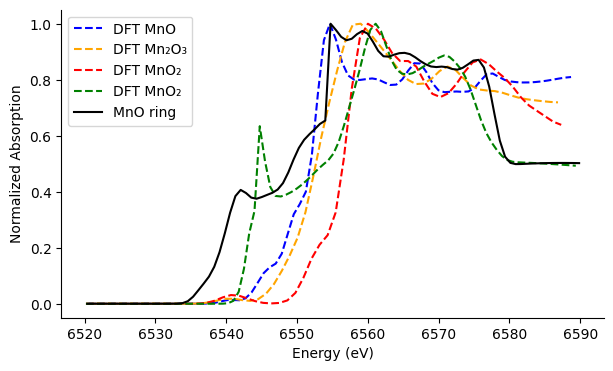

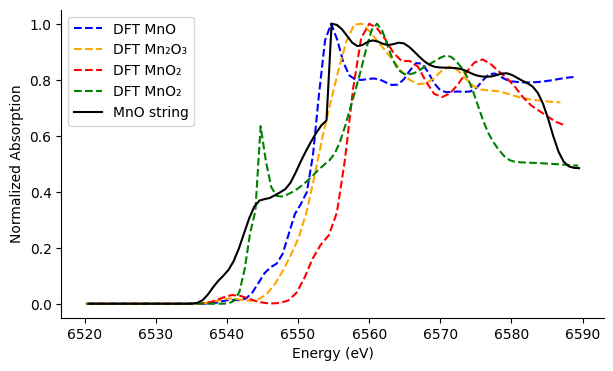

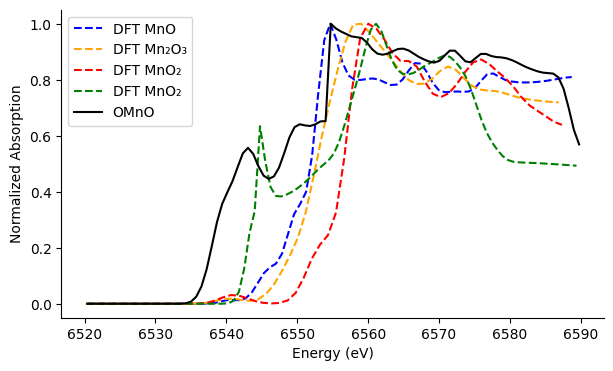

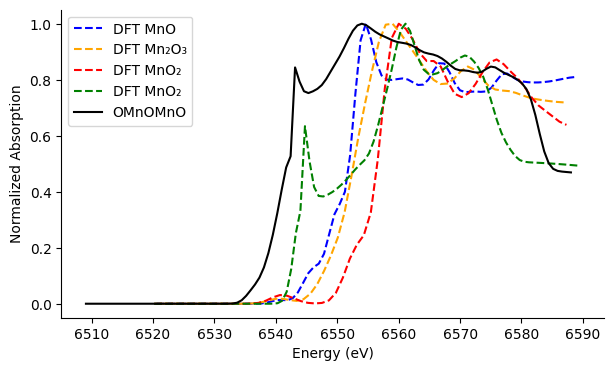

In [1141]:

# Plot for MnO ring
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='DFT MnO',linestyle='--')
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='Orange', label='DFT Mn₂O₃',linestyle='--')
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='Red', label='DFT MnO₂',linestyle='--')
plt.plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='Green', label='DFT MnO₂',linestyle='--')
plt.plot(MnO_ring["Energy (eV)"], MnO_ring['Absorption'], color='Black', label='MnO ring')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# Plot for MnO string
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='DFT MnO',linestyle='--')
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='Orange', label='DFT Mn₂O₃',linestyle='--')
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='Red', label='DFT MnO₂',linestyle='--')
plt.plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='Green', label='DFT MnO₂',linestyle='--')
plt.plot(MnO_string["Energy (eV)"], MnO_string['Absorption'], color='Black', label='MnO string')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# # Plot for OMnO
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='DFT MnO',linestyle='--')
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='Orange', label='DFT Mn₂O₃',linestyle='--')
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='Red', label='DFT MnO₂',linestyle='--')
plt.plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='Green', label='DFT MnO₂',linestyle='--')
plt.plot(OMnO_struct["Energy (eV)"], OMnO_struct['Absorption'], color='Black', label='OMnO')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# # Plot for OMnOMnO
plt.figure(figsize=(7, 4))
plt.plot(MnO_DFT["Energy (eV)"], MnO_DFT['Absorption'], color='blue', label='DFT MnO',linestyle='--')
plt.plot(Mn2O3_DFT["Energy (eV)"], Mn2O3_DFT['Absorption'], color='Orange', label='DFT Mn₂O₃',linestyle='--')
plt.plot(MnO2_DFT["Energy (eV)"], MnO2_DFT['Absorption'], color='Red', label='DFT MnO₂',linestyle='--')
plt.plot(Mn2O7_DFT["Energy (eV)"], Mn2O7_DFT['Absorption'], color='Green', label='DFT MnO₂',linestyle='--')
plt.plot(OMnOMnO_struct["Energy (eV)"], OMnOMnO_struct['Absorption'], color='Black', label='OMnOMnO')
plt.xlabel('Energy (eV)')
plt.ylabel('Normalized Absorption')
plt.legend()
plt.show()

# Stacking all Co-Mn Structures

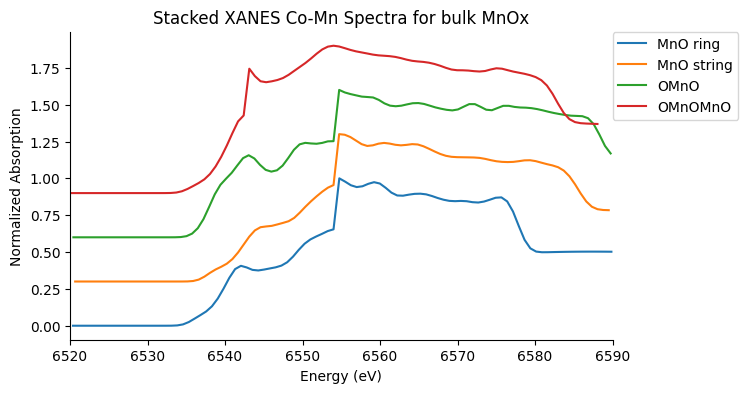

In [1142]:
# Function to plot stacked XANES DFT spectra with upward shift
def plot_stacked_xanes_spectra(dft_data_list, structure_names, shift_value=1):
    plt.figure(figsize=(7, 4))  # Set figure size
    
    # Loop over each DFT dataset and apply an upward shift
    for i, (x, y, structure_name) in enumerate(dft_data_list):
        # Apply a shift upwards for each subsequent spectrum
        shifted_y = y + i * shift_value
        
        # Plot the spectrum with a label indicating the structure name
        plt.plot(x, shifted_y, label=f'{structure_name}')
    
    # Customize the plot
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized Absorption')
    plt.title('Stacked XANES Co-Mn Spectra for bulk MnOx')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
    plt.xlim(6520,6590)
    plt.show()

# Example usage with the MnO, Mn2O3, and MnO2 datasets

# Assuming these are pandas DataFrames with 'x' and 'y' columns
# Convert to numpy arrays for plotting
x_MnO_ring = MnO_ring['Energy (eV)'].values
y_MnO_ring =MnO_ring['Absorption'].values

x_MnO_string = MnO_string['Energy (eV)'].values
y_MnO_string = MnO_string['Absorption'].values

x_OMnO_struct = OMnO_struct['Energy (eV)'].values
y_OMnO_struct= OMnO_struct['Absorption'].values

x_OMnOMnO_struct = OMnOMnO_struct['Energy (eV)'].values
y_OMnOMnO_struct = OMnOMnO_struct['Absorption'].values

# Create a list of tuples with (x, y, structure_name) for each dataset
dft_data_list = [
    (x_MnO_ring, y_MnO_ring, "MnO ring"),
    (x_MnO_string, y_MnO_string, "MnO string"),
    (x_OMnO_struct, y_OMnO_struct, "OMnO"),
    (x_OMnOMnO_struct, y_OMnOMnO_struct, "OMnOMnO")
]

# Call the function to plot the stacked spectra with a shift value of 0.5 (you can adjust this)
plot_stacked_xanes_spectra(dft_data_list, ["MnO ring", "MnO string", "OMnO", "OMnOMnO"], shift_value=0.3)